# The final DpoDetection Tool :
***

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/media/concha-eloko/Linux/depolymerase_building"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
DpoDetection_path = f"{path_work}/DepoDetection.T12.4Labels.1908.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

In [3]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-11): 12 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inpla

In [4]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


def plot_token(tokens) :
    tokens = np.array(tokens)  # convert your list to numpy array for convenience
    plt.figure(figsize=(10,6))
    for i in range(len(tokens) - 1):
        if tokens[i] == 0:
            color = 'black'
        elif tokens[i] == 1:
            color = 'blue'
        elif tokens[i] == 2:
            color = 'red'
        else :
            color = 'green'
        plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.title('Label for each token')
    plt.xticks(rotation='vertical')
    plt.yticks(np.arange(2), ['0', '1'])  
    plt.grid(True)
    plt.show()

***
# Predictions Bea

> Make predictions 

In [22]:
path_out = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/genomes"
from Bio import SeqIO
from tqdm import tqdm 

prediction_results = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if len(record.seq) >= 200 :
            protein_seq = record.seq.translate()
            prediction, sequence_outputs = predict_sequence(model_classifier, str(protein_seq))
            if prediction[0] == 1 :
                a = (prediction , record.description)
                tmp_results.append(a)
            else :
                pass
    prediction_results[fasta_file] = tmp_results



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [12:21<00:00, 16.13s/it]


> Save / Open predictions

In [8]:
import os
from tqdm import tqdm
from Bio import SeqIO

path_bea = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea"

#dpos = set([prot_id[1] for file in prediction_results for prot_id in prediction_results[file]])

#with open("/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.tsv", "w") as outfile : 
#    for dpo in dpos :
#        outfile.write(dpo + "\n")

dpos = open("/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.tsv").read().split("\n")

In [6]:
dpos

['lcl|ON602740.1_cds_UVX30347.1_5 [locus_tag=A1l_00005] [protein=tail protein] [protein_id=UVX30347.1] [location=complement(8381..10741)] [gbkey=CDS]',
 'lcl|ON602736.1_cds_UVX30096.1_198 [locus_tag=M5a_00221] [protein=hypothetical protein] [protein_id=UVX30096.1] [location=complement(125811..126230)] [gbkey=CDS]',
 'lcl|ON602735.1_cds_UVX29830.1_7 [locus_tag=D7c_00007] [protein=tail fiber protein] [protein_id=UVX29830.1] [location=6265..8493] [gbkey=CDS]',
 'lcl|ON602754.1_cds_UVX31298.1_2 [locus_tag=A1j_00002] [protein=tail protein] [protein_id=UVX31298.1] [location=complement(1418..3778)] [gbkey=CDS]',
 'lcl|ON602755.1_cds_UVX31392.1_45 [locus_tag=A3c_00045] [protein=hypothetical protein] [protein_id=UVX31392.1] [location=36235..37875] [gbkey=CDS]',
 'lcl|ON602736.1_cds_UVX30050.1_152 [locus_tag=M5a_00175] [protein=tail fiber protein] [protein_id=UVX30050.1] [location=96188..97225] [gbkey=CDS]',
 'lcl|ON602764.1_cds_UVX31929.1_22 [locus_tag=A2a_b_00022] [protein=tail fiber protein] 

In [22]:
boundaries_bea = {}
for fasta_file in os.listdir(f"{path_bea}/genomes") :
    multi_fasta = SeqIO.parse(f"{path_bea}/genomes/{fasta_file}" , "fasta")
    for record in multi_fasta :
        if record.description in dpos : 
            if len(record.seq) >= 200 :
                protein_seq = record.seq.translate()
                prediction, sequence_outputs = predict_sequence(model_classifier, str(protein_seq))
                #print(record.description, sequence_outputs, sep = "\n")
                boundaries = find_longest_non_zero_suite_with_n_zeros(sequence_outputs , 10)
                boundaries_bea[record.description] = boundaries


In [24]:
with open(f"{path_bea}/DepoScope.raw_boundaries.tsv" , "w") as outfile :
    for protein in boundaries_bea :
        outfile.write(f"{protein}\t{boundaries_bea[protein]}\n")

> Check the differences between the calls made by DepoScope and Bea's report

In [45]:
dpos = [prot_id[1].split("locus_tag=")[1].split("]")[0] for file in prediction_results for prot_id in prediction_results[file]]

path_pdb = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/pdb_depolymerase_proteins_Bea"

deposcope_plus = []
for dpo in dpos : 
    if f"{dpo}.pdb" not in os.listdir(path_pdb) :
        deposcope_plus.append(dpo)

for dpo in deposcope_plus : 
    print(dpo)

A1o_00041
A1c_00046
A1d_00013
A1q_00010
A1q_00023
A1r_00013
A1f_00024
A1g_00045
A3b_00016
A1j_00002
A2a_00010
A1m_00045
A1n_00050
A1p_00055
A3d_00036
A3c_00039
A1l_00005
A3a_00045
A2b_00022
M5a_00175
M5a_00221
A1b_00036
A1e_00012
A1e_00024
A1a_00002
A1h_00009
A1k_00018
M5b_00032
A2a_b_00036
A1i_00037


In [47]:
deposcope_forgotten = []
for dpo_pdb in os.listdir(path_pdb) :
    if dpo_pdb.split(".pdb")[0] not in dpos :
        deposcope_forgotten.append(dpo_pdb.split(".pdb")[0])

len(deposcope_forgotten) , len(os.listdir(path_pdb)) , len(dpos)

(8, 51, 73)

In [48]:
deposcope_forgotten

['S9a_00074',
 'S9a_00076',
 'S8a_00015',
 'S9a_00079',
 'S8c_00002',
 'A1q_00009',
 'S9a_00075',
 'S8c_00001']

> Get the plots for each dpo

  0%|                                                                                                                                                   | 0/46 [00:00<?, ?it/s]

lcl|ON602737.1_cds_UVX30183.1_55 [locus_tag=S13c_00055] [protein=tail fiber protein] [protein_id=UVX30183.1] [location=complement(28158..31880)] [gbkey=CDS]


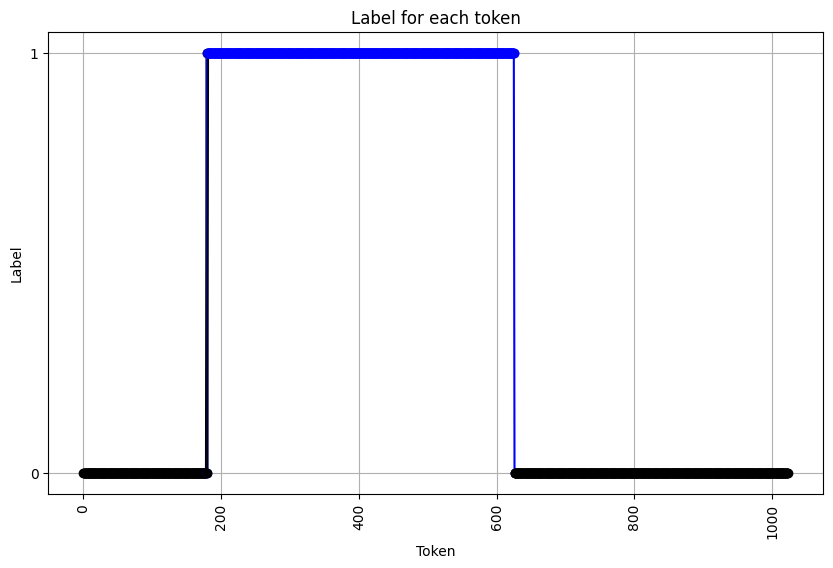

  2%|███                                                                                                                                        | 1/46 [00:04<03:10,  4.24s/it]

MATNPTNNPIPSEDPRDLKFNAGKIDEEVNGSADYYTDRFGVQRLTNAGRNHQFQDAQAERSSLFTEQLTSQEEEFTTQISGQEDQFNQQISEQHSEFTAQITEQRNEFNDMLAASGYSWLADYVDGPVTFTNRSQVTVYNGVAYRLSAATDIPFTTTGNNATSWANDSTHLVAIGDNDIRQQVQYQFGQWLPSVAAALISNDTYSSIRTRGFYAPNDGGDGVWIATGNTVPSKAGTHDPAKARIYNANGVEYQLNVQSGFEINAKANGVNAVDDVDAETEDFVCLGQAINGITSRVKTMVNDEDLKTYLKVTIPSEYPLRIGKSSIKAYSRLKLDFQQANIYVRPSPSNRQEVTGVYMNAIERGIEDIQAISAKFSGATSYSNMTLSDFHIEGGKLYGDHTTDKGVADCSTGTGLFTYNMENSSIRNTWFQGFACGRQYNRTGPGYYFDNLGNKVVGTLVPEVTTSGTGSYEGVKEWSVTAYGCRYLYLRVLSNWARFDNCKFGTYANWSSSPDGNQCEYFIENRGAGVVFSGGVIEANTAAANPTKGYVRDFARGCTFEGVYYENCLSAGWVVAIPEKSQYNRANGLFLTAIGSQFTLSSKGAPLIKFEEGYFGSYNPATGLYETGGWETNYQYAGGVNTWSVGQPVVDSGAFPHGGYDFKYGTYGIHYSGSVPDVDSLRDTPEGNEFLSPYGLPVNSGILLFTTLSPAYQSNIVVWYKDLTGNFDPRNIVVGDFDNNNVSDGTSNALYRTNGFHYYDYGNGYKAAIVPYVNPRALDNRMTTSAGRKLKITVTSDAPIILKNIQAFVGGTPLFPPALKEYVPRSQRDRAWGTMSAGSTDSGAYYGPLVGGGIFRPGDVVLPFVPFSNAALMNPASYTDISAGYGSNTDTAVITGGAAWGAGLAGATFTLTVEAQDTTNNWTTVSVPSAYLPYVFTGMPVNVTANSSGGATGLINTVRRIINSDGTMSNKYVLSGALGAAGTTLTASTNGSYTVRSGVS

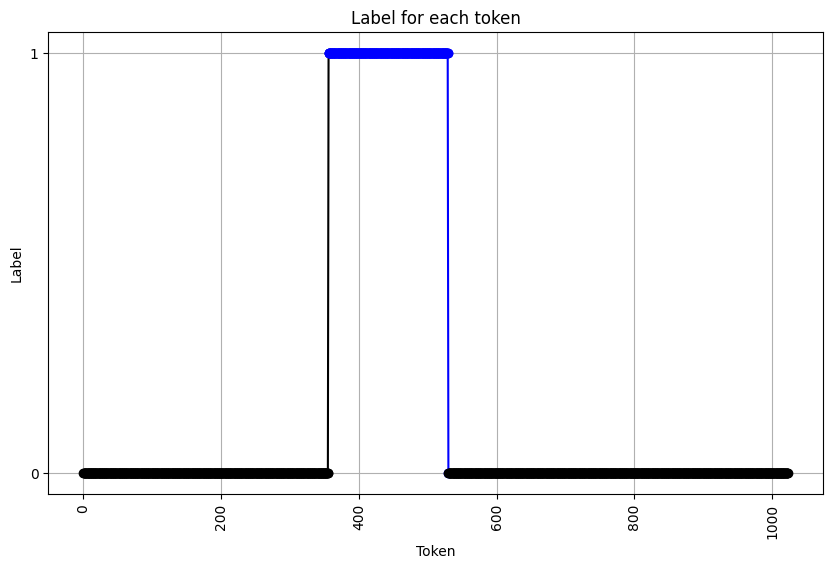

  4%|██████                                                                                                                                     | 2/46 [00:05<01:46,  2.41s/it]

MANCSDYISADDLKTGKQAVQHIEHVAKSKDANGANALTVTDTIRGEQVTNLTLDGMEAQFQDAQADKEARFQQFLLNSGYQFLGDYENGPYTISAHNQIIRYQNEFWRLNAATNPPYTTTGINSASWTTDVTHLVSVGDANLRQDLSSETGAMKVYRNASPLARIIRSSIFEYLTEADQQALLTIPGVNVIADYALKKAIADGVMVLDIPWNVGALNFGLDPAMLPLGFQFIGWGCRRPYTIAGDSSFINCGVVIRVAAGASFPFYSTGRHVFRDIVFDGRDKTTYLFYSPSTATQFNGTRLEGCGFYRFAIGIGWASGGTARYIGTMKAYFCSISGNGDGVRNLIDSMMFGCTINANDRGVALTGGANNNFFGGCRNEWNTGDNWYAFQSVENQIFGELCDRAGRGGVVAGAKSSWILNGVNVRRSGANQPVGNDYSANFIIIDDGKIELSGVRTGVGANDSGDGGTISPSYNVSALGSGGGTLQVSGSDMTGFVTSAINQKATTLNKSITGNLGMDDDVNIGMTQVVKGRRIIGSQSSGTLAGSVGATLSLTKTNISQNAYDTYVTRAILVECRIGSSALGDDIKIPVRIRREGSYYLDVITAGIVASSGRIGISGTGVTVALSIDSSTGLITVLLTNVDGQARTVNVSMLPSM*


lcl|ON602724.1_cds_UVX29033.1_41 [locus_tag=A1o_00041] [protein=tail protein] [protein_id=UVX29033.1] [location=26268..28628] [gbkey=CDS]


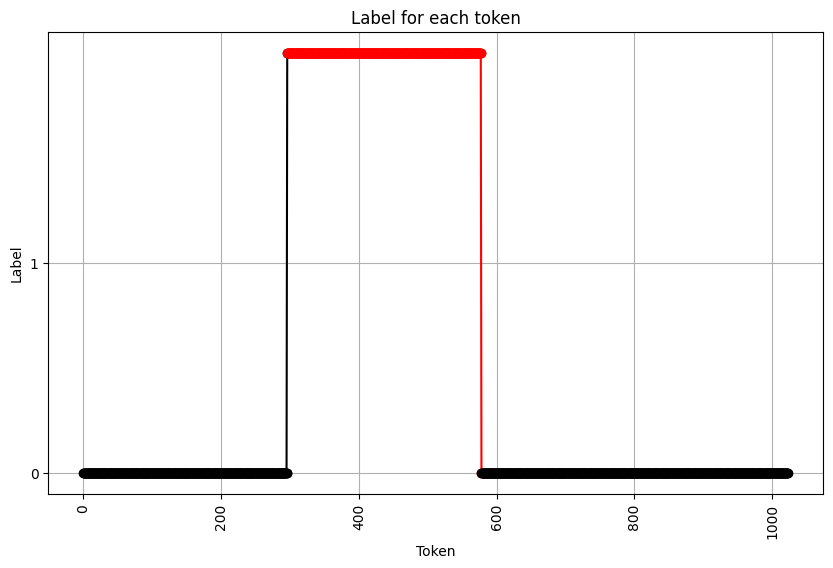

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPSGNVGVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMSGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTIPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602724.1_cds_UVX29037.1_45 [locus_tag=A1o_00045] [protein=tail fiber protein] [protein_id=UVX29037.1] [location=35670..38012] [gbkey=CDS]


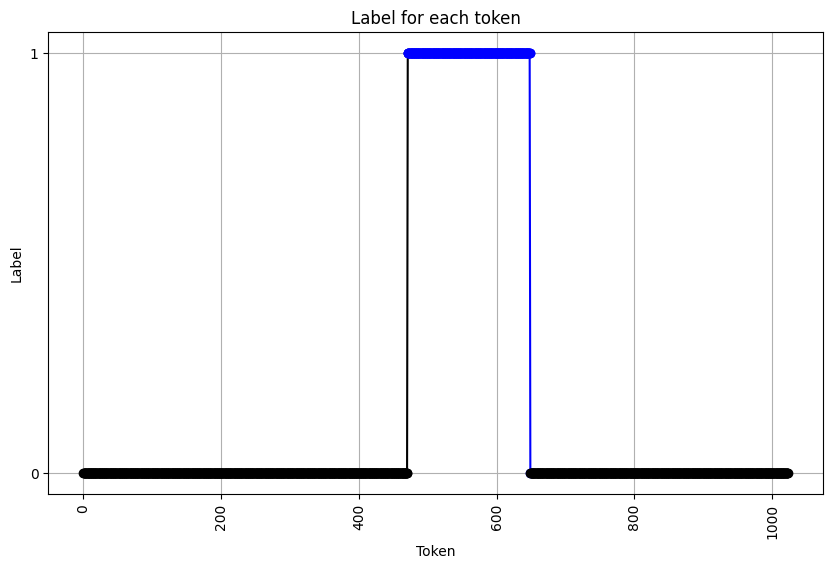

  7%|█████████                                                                                                                                  | 3/46 [00:09<02:09,  3.02s/it]

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNMQLLHLAQELVEGRYIEGFYGDINMHRYRITYVGDPVDALDAANKQYVDGGDARLDQRIDAEHAAWMAGDAALDSRVVNLEQTYFGANTNSFPWWTILTSDTDTVTPGMPFTKAKVRVNGLTKTAGYSYTVNSGVVKFTEVLPAGTLVDMTIGIDTEADTSAVSSILELLTAPSGASLISSGNAPVSVLLRRSIFEFMSAGDRTLITGTVGTEVLVDYAIAAAVAAGVTELYFPPVPGIYVVGQTPVTLPAGFSITGVAAKPYTAPSNASFNSRGTVIRLASGATAPFILTNRHRFLNVILDGRNSSVNLMKGVGSDQTQYCRFDSCGIYRWLNGIGGSSSSGYTATVQVIGCALASNYRGVRNVIDSRFTDCTINANTYNGVELNAGANNNSFLNVRNEWNGAHNYFASGAKRNVVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAVVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSCTLSTSGANSDEKTFIATGSRLGGFTGTSWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFAVSSDGARSQYSEPLVRKLEITARNNTSTGSVSRFYADLIISRESATAAVAVDASSVKTHSTLSGGTWGLASASPTGVSVTPTISADGSTLTVTLTAVDNAPRLIWAQLRG*


lcl|ON602748.1_cds_UVX30914.1_34 [locus_tag=A1c_00034] [protein=tail fiber protein] [protein_id=UVX30914.1] [location=complement(21949..23904)] [gbkey=CDS]


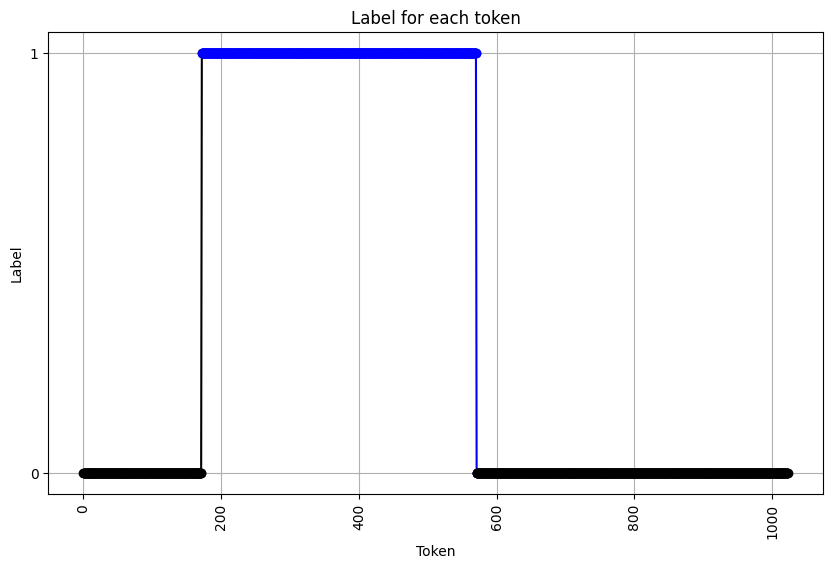

MALIRLVAPERVFSDLASMLAYPNFQVQDKIILLGSAGGDFTFTTAASVVDNGTVFAVPGGYLLRKFVGPAYSSWFSNWAGIVTFMSAPNRHLVVDTVLQATSVLNIKSNSTLEFTDTGRILPDAAVARQVLNIIGSAPSAFVPLAADATAGSKVITVAAGALSAVKGTYLYLRSNKLCDGGPNTYGVKISQIRKVVGVSTSGGVTSIRLDKALHYNYYLSDAAEVGVPTMVENVTLVSPYINEFGYDDLNRFFTIGISANFAADLHIQDGVIIGNKRPGASDIEGRSAIKFNNCVDSTVKGTYFYNIGWYGVEVLGCSEDTEVHDIHAMGVRHAISLNWQSTADGDKWGEPIEFLGVNCEAYSTTHAGFDTHDIGKRVKFVRCVSYDSADDGFQARTNGVEYLNCRAHRAALDGFASNTGVGFPIYRECLAYDNVRSGFNCSYGGGYLYDCEAHGSQNGVRINGGRVKGGRYTRNSSSHIFITKDVAETAQPALEIDGVSMRYDGTGRAVYFHGTMGIDPTLVSMSNNDMTGHGVFWALLSGYTMQPTPPRMSRNLLDDTGIRGVATLVAGEATVNARVRGNFSSVANSFKWVSEVKLTRLTFPSSAGALTVTSVAQNQDVPTPNPDLNSFVIRSSNAADVSQVAWEVYL*


lcl|ON602748.1_cds_UVX30926.1_46 [locus_tag=A1c_00046] [protein=tail protein] [protein_id=UVX30926.1] [location=complement(35881..38196)] [gbkey=CDS]


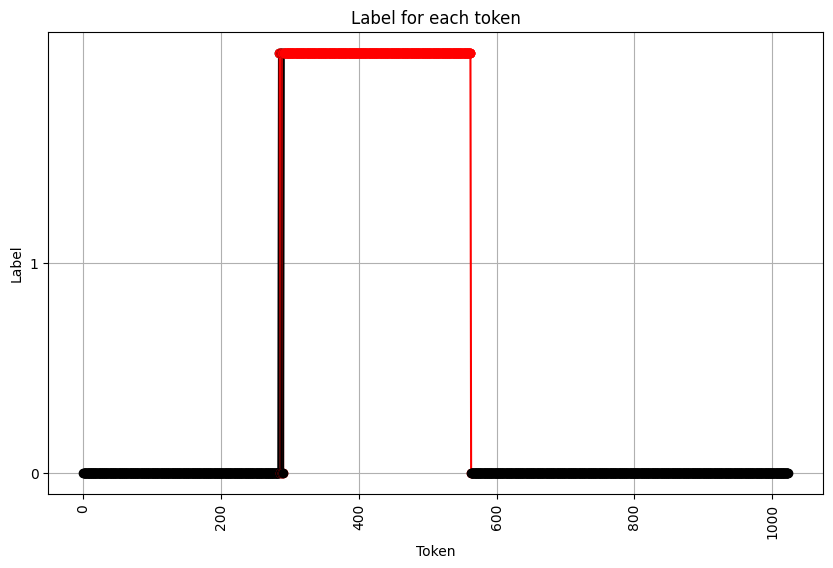

  9%|████████████                                                                                                                               | 4/46 [00:11<02:00,  2.86s/it]

VSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPPAEIAWQSTIDNPGLDELFVEYVERGTDGRHLLINTANGNWWLLSKNGQGIVNSGNDPYFVTTVGQTSIQTASIAGLTYILNTEMRPNTTVDNTGRTDPSTTGFFYVKSAAFQKRWNVTVTSGGTDYSGNYTAPAAGSTSGNAEEVSGAYVVAQLRDSLVANGLPAGNVSIRGAYMFFFGLTNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPSEANGAMCRVGTASSETAWYKFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNENPGFVENGYITGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRITPVMAGQTVIYPNKRNDRYAGVLELIPSPYTSSQYTTQDATVHLPRYVPGRVLQMQNSSVTNMAFMRFSGDRKSLLVYEFMWGGTDGAKMQAAWHKWTLPYNLVGVQALEDEVFLYMQGPSPGNKLLVLSMDPRAGYNLGEEYTEAYSDLQVQVTVSGGVLTVPAVLRPLAWADTFKEDLVLTYPADSPMGPTEVGLQAIAGENQLSVVRGVPDGQYVIGRRYKSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVTDTPRDVDWSGELTGILMNSKELTLGQTLRMDLATITVPCRTNADTTEVTMFTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602762.1_cds_UVX31810.1_9 [locus_tag=A1d_00009] [protein=tail fiber protein] [protein_id=UVX31810.1] [location=complement(4314..6797)] [gbkey=CDS]


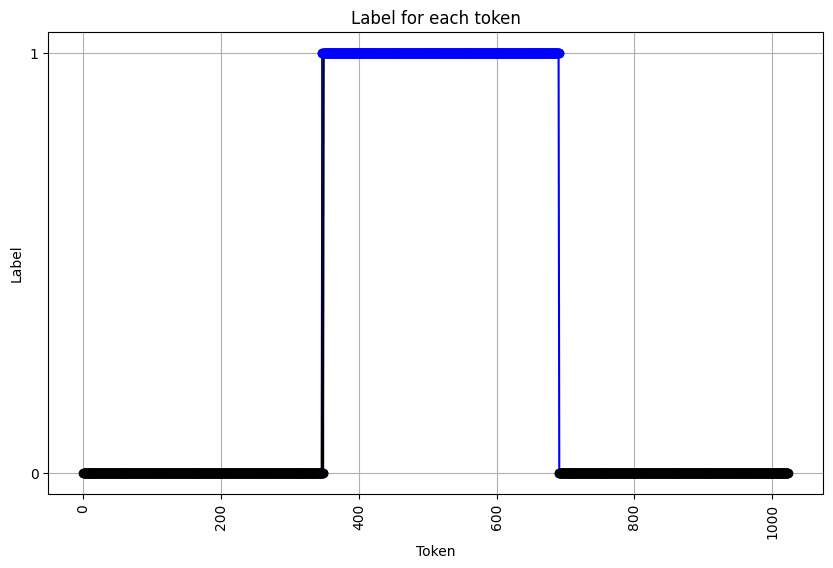

MAFSWQESTVASGTQNITCDLEYLDKSYIHVYLDGQETTAFSWTSDTVIRLDAALTAETVVLLTRKTEREYLYIMFASGAPFIEANVDTQNKQFLHLAQELVEGRAIEGFYGDISFNGYRITNVGTPEEDADAANKAYVDATVQSEAVLRVAADAKIQQDVDCNELRSLRFPEGVEEMPGVTGRANSLQGYNDAGKPVPIFDMTATADLAMKLASSGDGLGAGLVGYDIASAYSNNTVGKKLNLLLSPWDFGAVADGTLHPLSEYYTTLAAAQAVYPFVTSLDQSIDYAAMQKCVNAMITRGAAGMTMGGRGRFCINSTVQFNKTGSVDEANKTIDFSGALIESYCGAQVLNDTVFTSWTLQGGVTVDSGTLVFAGDSTTQAQAAIALTGLTVGKSYAVSVRIETYTSTGYLRIRLNGTPISRTNEAGPGVRHAEFTATATTHVLQLRDDTWTGTPAHCIVSEVDVRELAYPLRFYQLGTAITHGSAAVYNLRMYNRNSAGFGGLRADNLNHAAFNGVTSFVGFYGPGMHMCNTLSWSENDTVDVLLAANCREAIRFTRPVAGTGFNSYARTNIKRIVFAGCRYAAVFEAGTSVYDSVIGSVSGNLTSNFRAVFSLHGDQSSSVVESIRVENNSAPSTAGIFEYGLNDLRRINLRAVGFYLGIPLLAANSWAAGTVSLENTISGTDFRPARPYFGATVHLPPSGTLGIGAVYSAGTYTWSEILLAVEPATATTIGGTYGLTPAHGVVELDISLRNADGTSMQGTKHTIKLMKATVFGADVSKVVVYDSEAPVNSELITITWPANSAPRITHSAAEARSIQVYARWTV*


lcl|ON602762.1_cds_UVX31814.1_13 [locus_tag=A1d_00013] [protein=tail protein] [protein_id=UVX31814.1] [location=complement(13839..16199)] [gbkey=CDS]


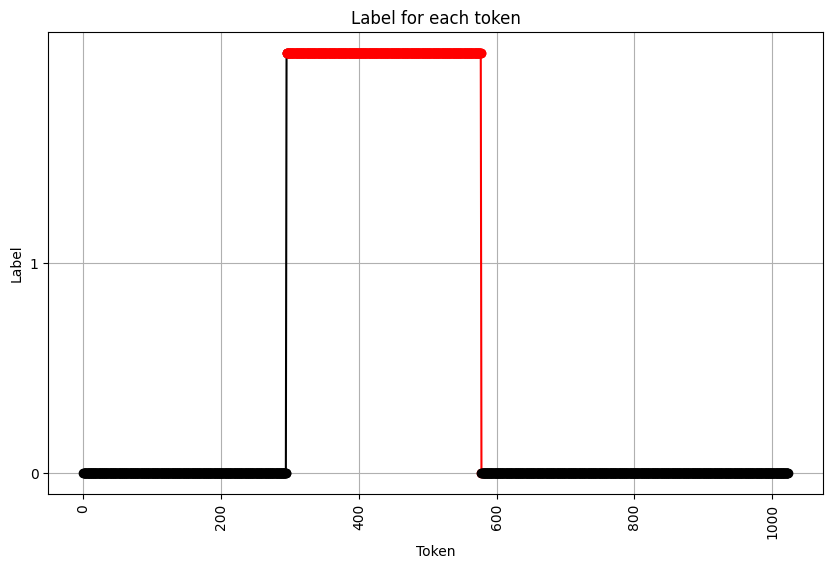

 11%|███████████████                                                                                                                            | 5/46 [00:14<01:57,  2.86s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNITVTSAGVDYSGDYSAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAEVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFEVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602726.1_cds_UVX29113.1_10 [locus_tag=A1q_00010] [protein=tail spike protein] [protein_id=UVX29113.1] [location=complement(4324..5277)] [gbkey=CDS]


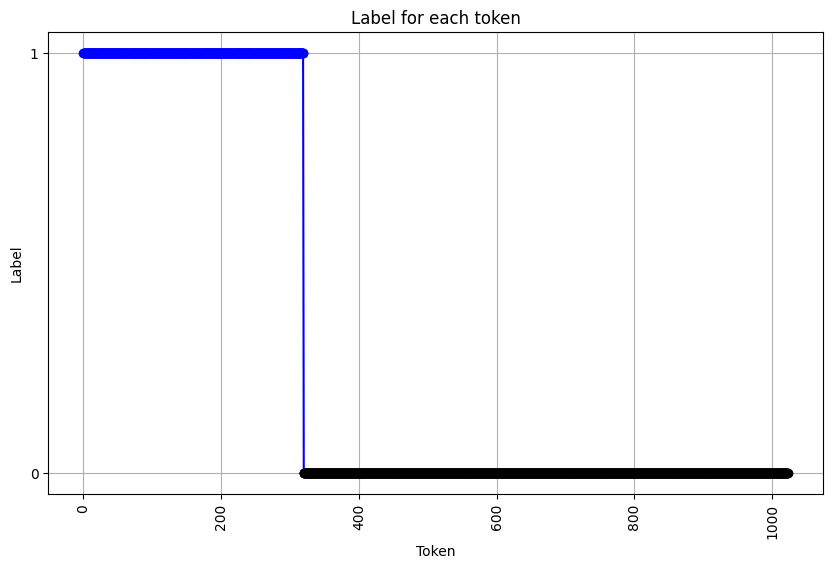

MALVENVQTRYYSQDDLWCRVADYLAKDAPVLTGLRPDSSGNYAAAIERVSAKGVKVLRVPVGSYYVGDCHLTNPMLFIGDDLEGVNPLGAVFIKPSTAAKMFYFDGTSTRGTGGGFLRMRLQGAVSSDSGLMVEVTSWSYFGAENSAFNNLAGSALVLRDCMESHISGNLFRRMGASNGSVILLGDYVDIPNNNVNNLHIQNNTFGLCSGAWVKSTTSSNPDLIWVTDNKFEWDSVPYGANTATQHVLDFGQLSRAWITRNGFTHFRPDSDHNLYAGCIRIRSGAVGPIVISDNKAYGCEGEFWTIEGGLCRCLRQ*


lcl|ON602726.1_cds_UVX29122.1_19 [locus_tag=A1q_00019] [protein=tail fiber protein] [protein_id=UVX29122.1] [location=complement(9429..11804)] [gbkey=CDS]


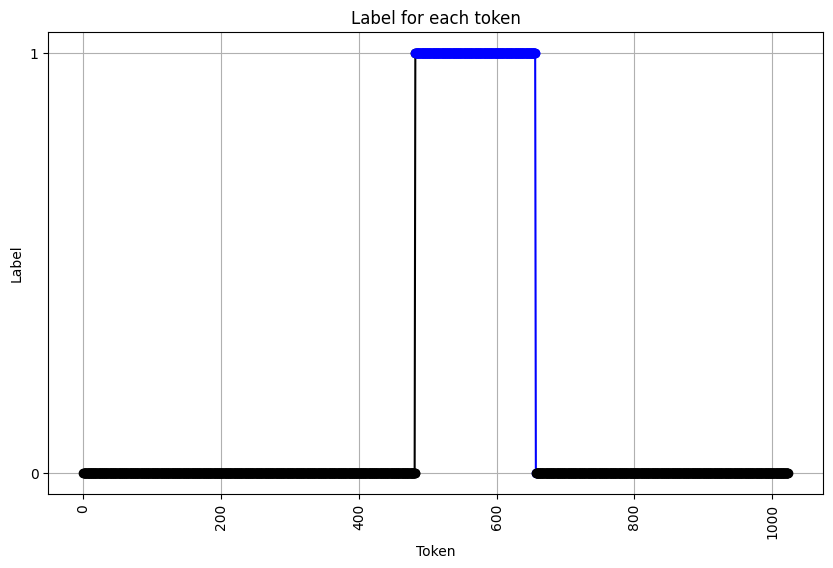

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEVNVDTQNTQFLHLAQELVEGRSIEGFYGDINMHRYRITNMGDPVDARDAANKQYVDAGDARLDQRIDAEHAAWVAAVANEASIREAADDALDVRTTNLEQTYFNANTNSFPWWTVLTADTDTVTPGMPFTKAKVRVNGVTQTAGYSYTVTAGVVKFAEVLPAGTLVDMTIGIDTEADTSAVSSVLELLTDPSGASLISSGNAPVSVLLRRSIFEFMSAGDRTLITGTVGTEVLVDYAIAAAVAAGVTELYFPPVPGIYVVGQSPVTLPAGFSITGVAAKPYTASSNASFNSRGTVIRLASGATAPFILTNRHRFLNVILDGRNSSVNLMKGVGSDQTQYCRFDSCGIYRWLNGIGGSSSSGYTATVQVIGCAIASNYRGVRNVIDSRFTDCTINANTYNGVELNAGANNNSFLNVRNEWNGAHNYFASGAKRNVVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAAVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSYTLSTSGANSDEKTFIATGSRLGGFTGTYWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFTVSSDGARSQYSEPLVRKLEITARNNTDTGSVSRFYADLIISRELATATVAVDASSVKTHSTLSGGTWGLASASPTGVSVTPTISADGSTLTVTLTAVDNAPRRIWAQLRG*


lcl|ON602726.1_cds_UVX29126.1_23 [locus_tag=A1q_00023] [protein=tail protein] [protein_id=UVX29126.1] [location=complement(18846..21206)] [gbkey=CDS]


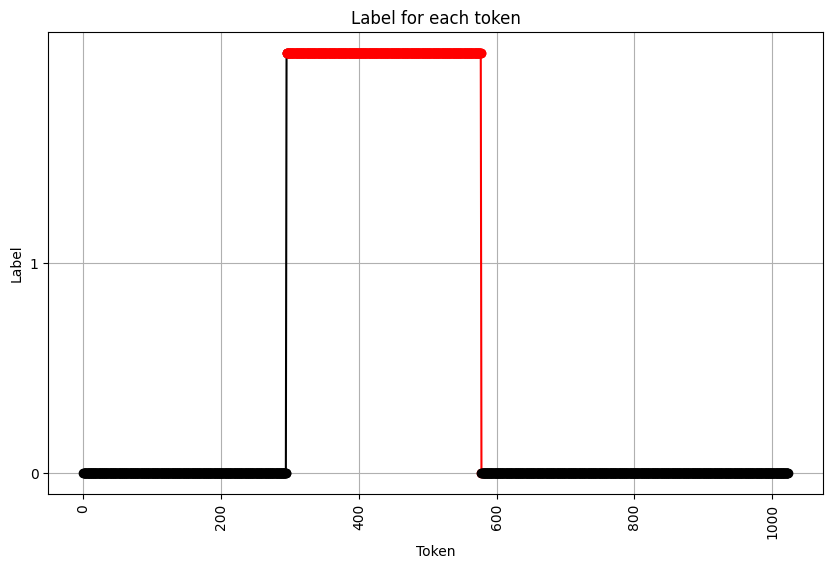

 13%|██████████████████▏                                                                                                                        | 6/46 [00:18<02:04,  3.12s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTILNSGNDPYFITTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNTAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPQDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602725.1_cds_UVX29055.1_9 [locus_tag=A1r_00009] [protein=tail fiber protein] [protein_id=UVX29055.1] [location=complement(4472..6814)] [gbkey=CDS]


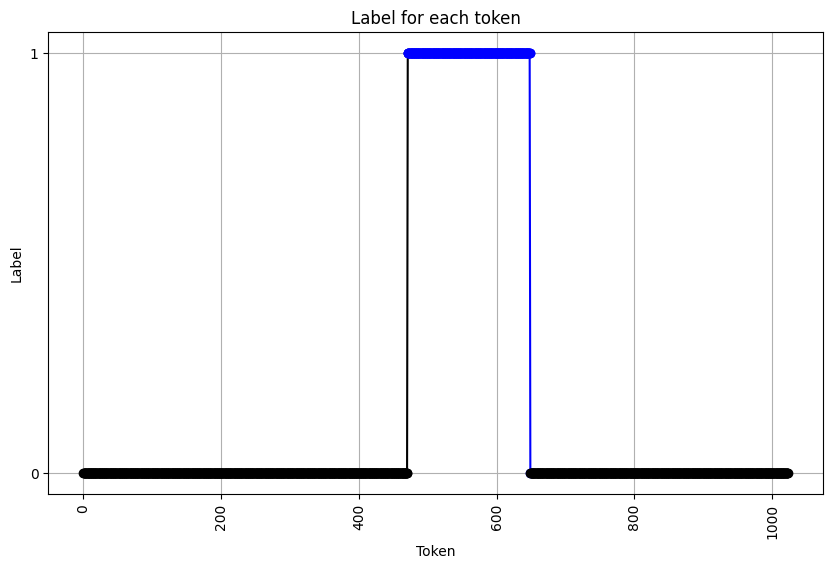

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNMQLLHLAQELVEGRYIEGFYGDINMHRYRITYVGDPVDALDAANKQYVDGGDARLDQRIDAEHAAWMAGDAALDSRVVNLEQTYFGANTNSFPWWTILTSDTDTVTPGMPFTKAKVRVNGLTKTAGYSYTVNSGVVKFTEVLPAGTLVDMTIGIDTEADTSAVSSILELLTAPSGASLISSGNAPVSVLLRRSIFEFMSAGDRTLITGTVGTEVLVDYAIAAAVAAGVTELYFPPVPGIYVVGQTPVTLPAGFSITGVAAKPYTASSNASFNSRGTVIRLASGATAPFILTNRHRFLNVILDGRNSSVNLMKGVGSDQTQYCRFDSCGIYRWLNGIGGSSSSGYTATVQVIGCALASNYRGVRNVIDSRFTDCTINANTYNGVELNAGANNNSFLNVRNEWNGAHNYFASGAKRNVVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAVVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSCTLSTSGANSDEKTFIATGSRLGGFTGTSWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFAVSSDGARSQYSEPIVRKLEITARNNTSTGSVSRFYADLIISRESATAAVAVDASSVKTHSTLSGGTWGLAGASPTGVSVTPTISSDGSTLTVTLTAVDGAPRLIWAQLRG*


lcl|ON602725.1_cds_UVX29059.1_13 [locus_tag=A1r_00013] [protein=tail protein] [protein_id=UVX29059.1] [location=complement(13856..16216)] [gbkey=CDS]


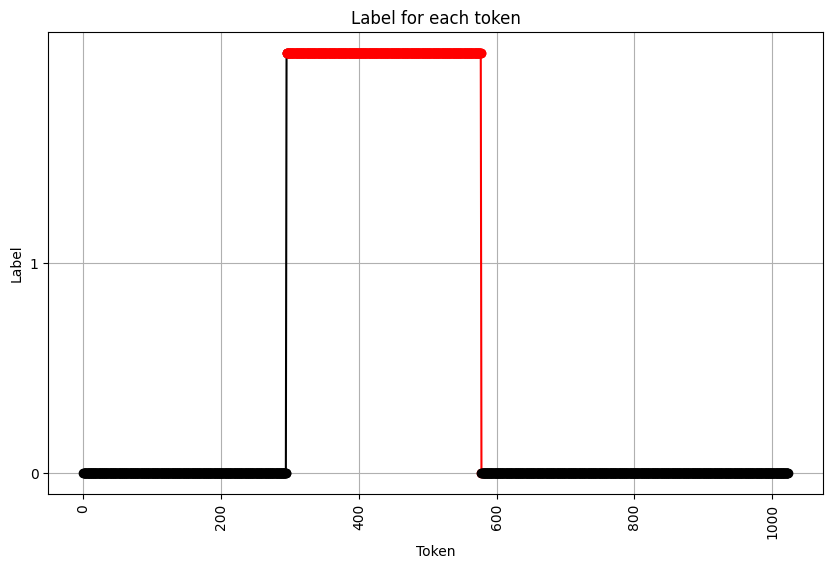

 15%|█████████████████████▏                                                                                                                     | 7/46 [00:20<01:54,  2.94s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTILNSGNDPYFITTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNTAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPQDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602749.1_cds_UVX30943.1_11 [locus_tag=P4a_00011] [protein=tail protein] [protein_id=UVX30943.1] [location=5844..8408] [gbkey=CDS]


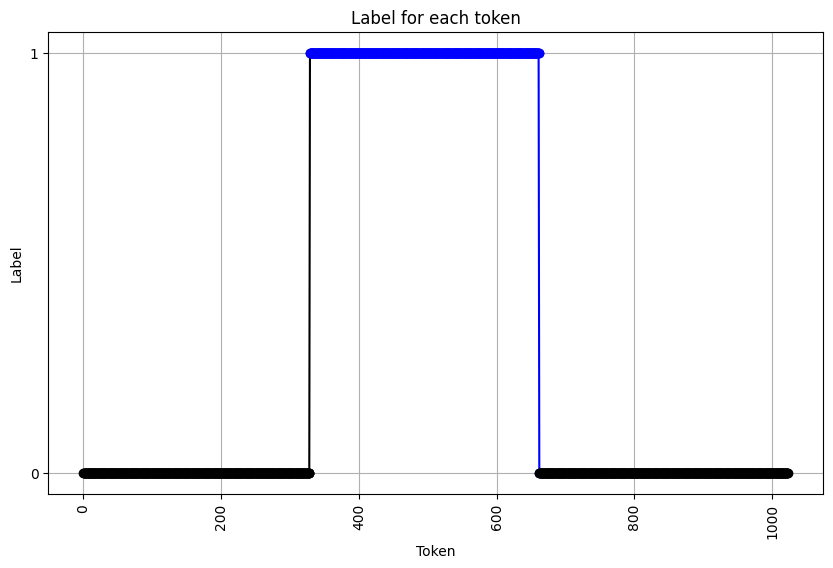

MNSHNPFNTGGSGCTNDFRSGDQLVDRIIGDAYHVVKEVYLALGNLSYIYNYLQKYGLIITVDSEEAIKDIPLSIGKFARVYSKSDTVGYYFTDYLYVEDDTTGIPPNDPTATGSWISTKATGSNASFVRIWKYRAVTDGETVIQLPTDMPIVDVQTIYVQGVRQDIDEGFTYNEGDATITLADELEAGNLVTVIIGITDPDLDIDIFAVLKGTDGASNIGTATGDTVEARLASLDLKVDPTLRQNLGSGEGFKLIGQFNSVDELRNYVPSVAGESVLVKSYHPGWAAVSDSPCGGGEFYYDANDTSSADDGVFTFVTAGGHRLKRKGLNGVVSLAQAGAPVDGTSNADEAFARLHNAILARTDLWQVDGENLTYVRTTPLLQDISRYSVNNMYLMYTGVTDFGPDNPFYAWKPSDSIGTSKRTFTRKMKNVTFHGPGYRIDTNIHALLLHMQTESETLRQMKFENVNVRDFNKGHVYGDHAYLITFENCNIWRCYAGLSDREIVEGASLTDSGENIRYAECLLDSLHQCANLGTQELNITFDTTSFDYTGRTSTESFIQWIIGGTHEITLRDCFIESGNVNAGWYNYGFYTTAAANIRIIRGIIRLVSTTYNTCPSFFYDASGLASFEIDGTTINGWGVKKWANTGLRKFRPTLKGLTSQFTLYTTDDPILWNPTKVNNLDYQVRALTTSTYTNKYTNERIKVEPSSITKEDGTVIPTLLVTKLAGYGQFADFIVKVRKPVKADHNASMHGKITFVPGTAMSSARVITAITGCCTPGKVNNVGVMSEFASTTITSTQLSLLDSVNWYDINASWGANKSASFLTFEEDMIRLDLSNLALGDAIHVHSLQWFGAF*


lcl|ON602749.1_cds_UVX30945.1_13 [locus_tag=P4a_00013] [protein=tail protein] [protein_id=UVX30945.1] [location=8688..11204] [gbkey=CDS]


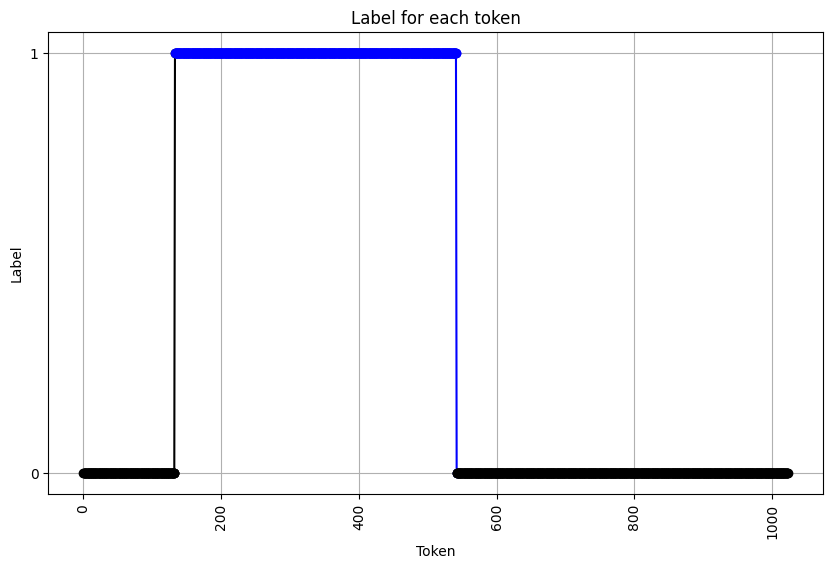

 17%|████████████████████████▏                                                                                                                  | 8/46 [00:24<02:02,  3.23s/it]

MNKMFTQPSGPVAKQTNKQAIARVNSIKQSEVCILNTLTAVDSYKILYDTATQTSWFRGEASGIPTSWTVSGNSLTLVTSSGEFVLQLADLRQNLASIEDGMGSYMVGAARNPLAAAISTAISVATALSSISVSIWEFRNHVTDRPDEEDQNTWDWSPAIEAAFNSIGTYLPYTMGTNTRHASATLLFPPGYYRCSEQVLADFSSYSGYVYGRPRLTITGYGASIGCGVEQNFTWKVIGTLLNMSGLDFVTDPTVNYSYAMKLGDETKTTSNYAVTGVLRDIRGFNLTKFVTFGWAFDMRIEGPYATGFKQDPAATEPATYFEILEHVSDNCNHLVFIRPQGETANTKNFEYFRINGNSHLSTHHNIHMFGGHFESHQYGIKFVNAVKNASGRPAVHQCSFNGVVFLENGSGDAALDALTPAASTHMLELDQASSIELNCCRVATTNTTTETFDSSKHKALIKYSGSALSLVIRGGYFVTAFASVAGSNQNRYTLIDISEHSAGKRAVEFAGRYSMNNFSTAHSTGRVLSGWISGNRKWIEEVSDDGLEYSWSYSTSSDLTGTPTKIFSVDSTGTFSINGIKVSTFDASSVLRIGYNNTTPGQRSINFYGAGTTDLTGQVYCNSAGSITVTSTNNIFLAANGGSGETMYTGNLKPNAAGSYSFGTSSFYPNNIYSQNAVTVVSDVNYKANVKVLSEEEEYQTLISAVGSVPFSAWQLKSAIAEKGVDSARWHVGVIAQQVKSAITDAGLDWTKYGLITYESFSQVVTKGDDGYYYPVVDEEEASKIPVNASGYIDAIYGADSVITADDGTITYTREIYMLRMEEFFALRMAHIESKLS*


lcl|ON602756.1_cds_UVX31408.1_12 [locus_tag=A1f_00012] [protein=tail fiber protein] [protein_id=UVX31408.1] [location=complement(6684..8438)] [gbkey=CDS]


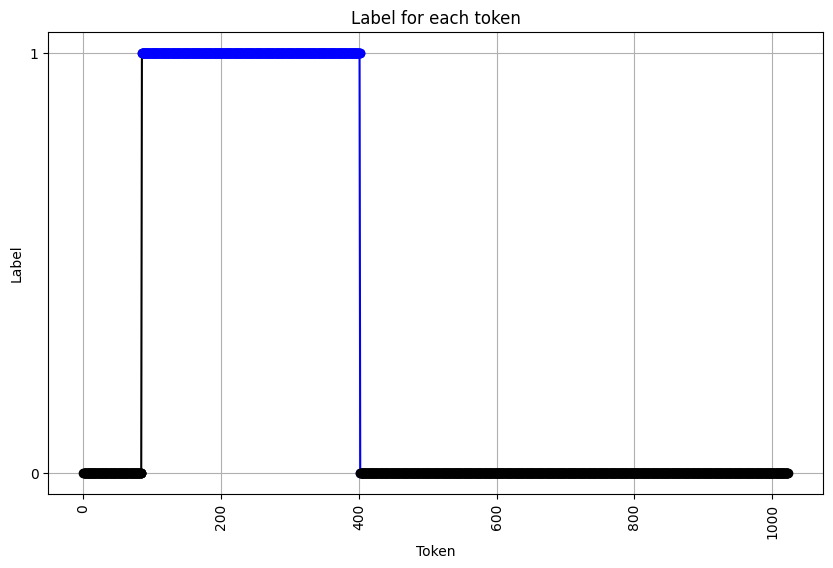

MALTKLVAVQSPTGNQRDCANIAALRAFTCSHVGQEVTLREHTSGQGSGGGVWYCHALTAGSAVDDNGCQIINNAGQVLRRRDLKELTSSYFGLKAGDIIDPVLDNMYKASRTFNIYEAKIENPGFDKGYLLTGGKRYYCGDKPFYILSYSIGTLRGPNIWHTGDNVGITFSRFKTDGTSEQAWSGGGIRGFRIWGAASYLVQGNEGVNAAPVRLSDMWQGEACDLWVTGYTGNTNGAVVSLYNEYAWTEGAIVENIMVRQSLRGLTFLRNHGTTATDSFFRVVADISFNAGVSGKATQVMVVGDGTAAGACLVYGHDIKLTQWMSAGSWHDIVRLEDYSIIAETGVIKIVADGYGISKTTVPSTEVVHSINVRGLNARFRSRVENWSNQAGGWGLDFLNIIFQSSMYTNAMTFYESDFDALPTINPVGMKIRYNGTFTVAERQSGKVYTLNGLIPGTTLKVKLTSRNGGDLNDAVVQEWKVFVRSTNLPCIVVPMSGSANIATTDGLAVTNISPVQTATFLKTVTPTQARNFIGQNYGLTVKNANDDNSLSYAVNSGRKIRFILPANPGATTTSPYSVEIEVL*


lcl|ON602756.1_cds_UVX31420.1_24 [locus_tag=A1f_00024] [protein=tail protein] [protein_id=UVX31420.1] [location=complement(20395..22755)] [gbkey=CDS]


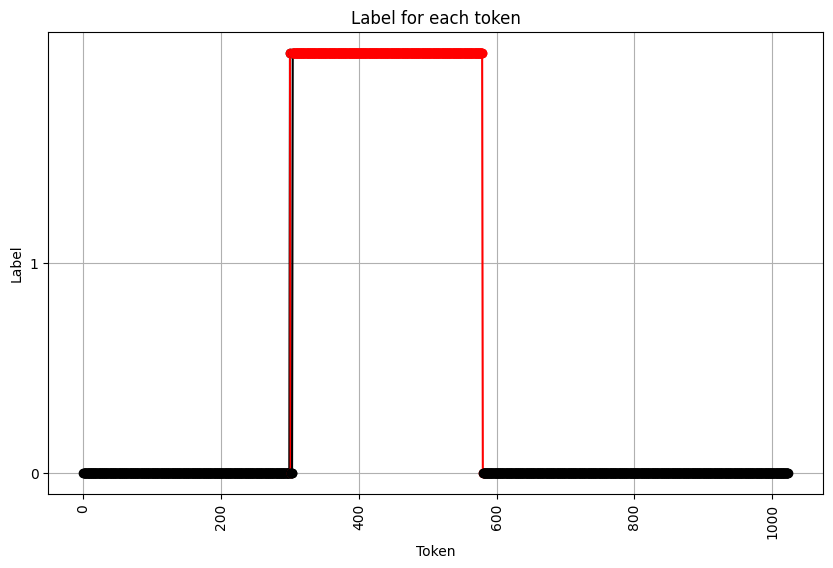

 20%|███████████████████████████▏                                                                                                               | 9/46 [00:28<02:02,  3.30s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGYYTAPAAGTTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGMEYRGAYSDLQKQVQVQDGVFTVPAVLRPVGWADRYREEIILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILLDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602761.1_cds_UVX31789.1_45 [locus_tag=A1g_00045] [protein=tail protein] [protein_id=UVX31789.1] [location=27287..29647] [gbkey=CDS]


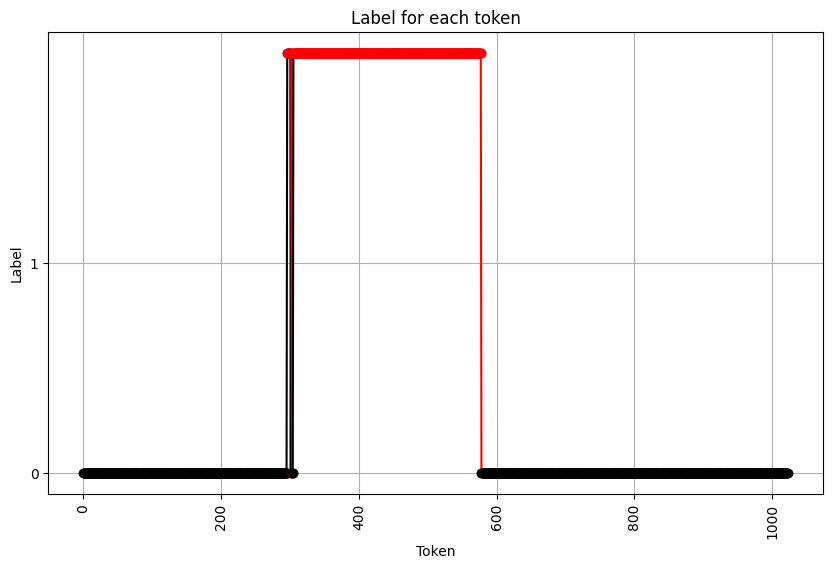

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPSGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFNYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSDPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602761.1_cds_UVX31801.1_57 [locus_tag=A1g_00057] [protein=tail spike protein] [protein_id=UVX31801.1] [location=41625..43403] [gbkey=CDS]


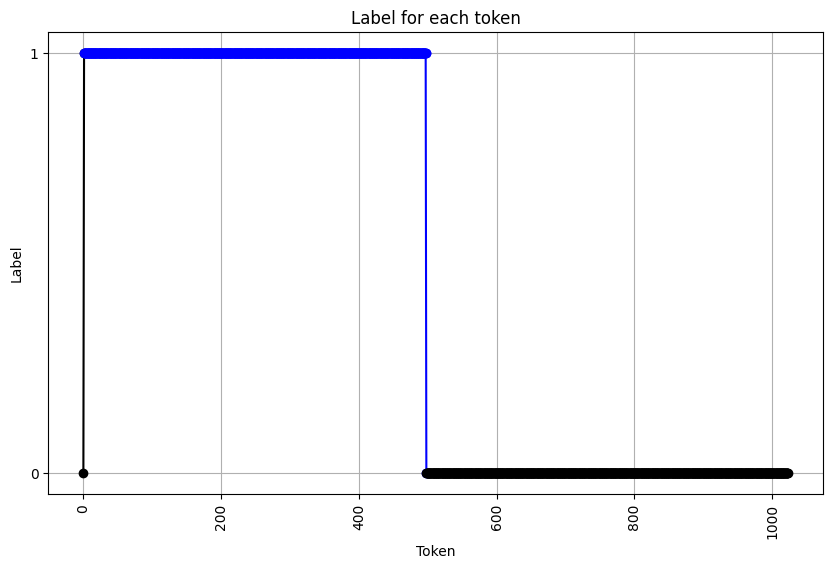

 22%|██████████████████████████████                                                                                                            | 10/46 [00:31<02:00,  3.34s/it]

MALTQLTRARRPVLDLGYVDVRDYGAKGDGVTDDTQAFLEAVAANSSVYVPVGSYLVKDLVLDAIPYLALQGEGKIVQGTDTPVLVSNCADLKISGIHFEGRVNAGRSGVLRLRGCSRASVSDCIFSNMGELGGLILETSTNVSITGNTFLNAQVASDRGFTIASDIRVWNTNSKVTIHDNIFSSNGAYAVNVNAQSPGSVVEDVIVTGNHISGYAAYGVMAYRNRQTAAENHVGIGLIVSGNIISDITGANPESPTSSRKTFGAGIYVQGWEKSVVSANKIFNVAQQTTDDLLAAAGVGVANCGSFVIDGNLVDTSGFYGIKVNDSVDLGDATASAAITNNVIRNTVRDGIQVVQRDNINVSSNSVTSSQRHGIILQGNPSGPAVRSRKLVVGNMVSDIAQDGITIAYQNQAEVSGNLINGCAQGIVADYSSFFLIKDNMLKSVTGISIRVNSTCSGGAAANLVSTNMAQDSGTGRLFVAAEASQLNNVGMTPEGAYGDMRRITAPATSLSVSGVSLLTLAFNTLSDLNTLSGGYVGQRITFFIEAGRTNFVHGTNLMLAGSANYTPPANARISFLCISSGRWVETGRVTP*


lcl|ON602742.1_cds_UVX30492.1_16 [locus_tag=A3b_00016] [protein=tail protein] [protein_id=UVX30492.1] [location=9964..12339] [gbkey=CDS]


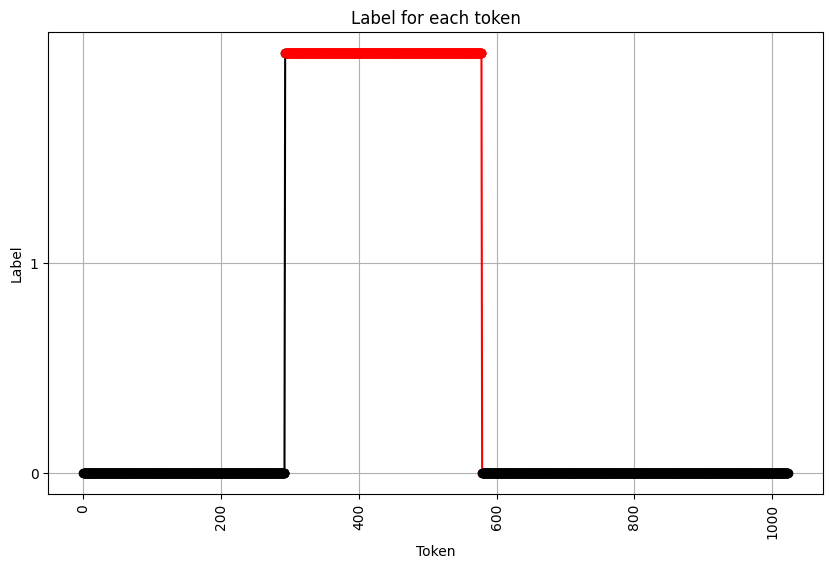

MALVSQSIKNLKGGISQQPEILRYPEQGSLQVNGWSSETEGLQKRPPMVFIKSLGPRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGDRSYVTVNNPKDNLRMVTVADYTFIVNRTRQVRENQNMTNGGTFRDNVDALINVRGGQYGRKLEVNINGVWVSHQLPPGDNAKEDPPKVDAQAIAEALATLLRAAHPTWTFNVGTGFIHCIAPADTTIDILETKDGYADQLINPVTHYVQSFSKLPLNAPDGYMVKIVGDTSKTADQYYVKYDKSQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHDWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVMSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFACVLTKGATSKVFIYKFLYMDENIRQQSWSHWDFGDGVEVMAANCINSTMYLLMRNAYNVWIAAVDFKKESTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITEYEPMGDSWDSTPDIRISGDISGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDSGRLQLRRAWVNYQNTGAFTVSVDNGSREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602742.1_cds_UVX30497.1_21 [locus_tag=A3b_00021] [protein=tail protein] [protein_id=UVX30497.1] [location=19715..22093] [gbkey=CDS]


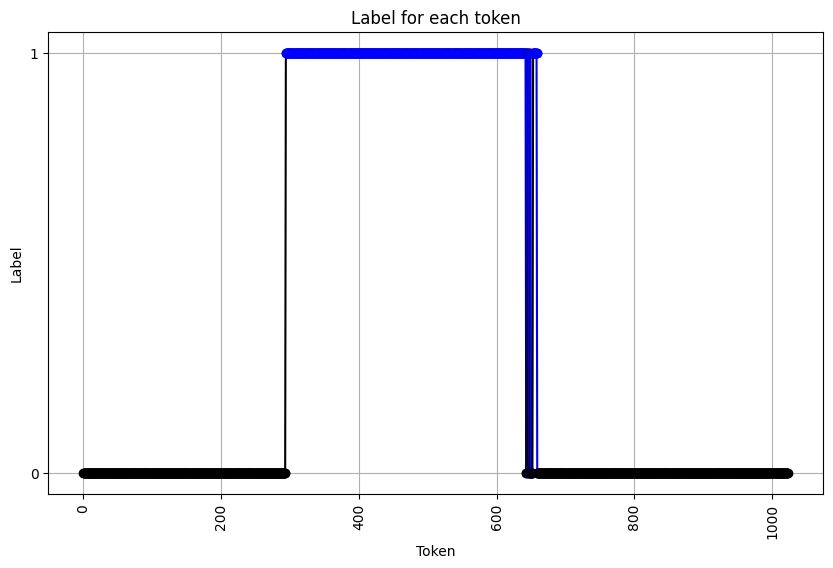

 24%|█████████████████████████████████                                                                                                         | 11/46 [00:35<02:00,  3.44s/it]

MDQDIKTVIQYPVGATEFDIPFDYLSRKFVRVSLVSDDNRRLLSNITEYRYVSKTRVKLLVDTSGFDRVEIRRFTSASERIVDFSDGSVLRAADLNVSQIQSAHIAEEARDAALMAMPQDDAGNLDARNRRIVRLAPGIDGTDAINKNQLDTTLGEAGGILSEIKGEKEQFYEYLEKFADDTTMIRGVTWVYNGGSAVGGETSIVINKPTAVFAVPYIEINGDRQEVGYQYDFNASTQTITLAKPLVAGDFLMAMTSESHLPLESLLAGTTGASSIGTKDGGTVQSALDNLGYYIVPESFGAKGDGVTDDTAAVQAAINAAKGKTLWLDASKMYICQNLVIPHAMTIAAGGRRQGGGLIPKGNSGPVVHSGDFILITAEQTVTMFNVTIDARGRPLTKVDGQRLNGLRQVDNTSGVYKSGFQLYNCNISGFSGLNIIGGASRSFGIIKDTQCESADLTCIRIQGVDWRIDHTYVGRSGTGHGIELRNESNVVSNCDSYFNKKSGVVYTQATGKTFFKLIACTLNSNGEHGVYIACPDMQPAGIIIVDNRFWNNSTSSDGVYSNITLSYGRGHIVVGNIHEAYQPADGSNSARAAYCVNLLNGARPAHMLDNYDPAYSYRTDFCNINVVDKINYNTHHIGSAKTFSVGVSSATSQAIGVFVDGESFPRASVGNGGIRFGKGDSAPTVGFGFDNNYPNHVVSFKGLAVLGSWDTSTFRVGGYRIWAGNGAGQLYFQYGADPTSQTDGKLFVGRTVTPPAASSSSGNTGDIAIDSGFLYVCVAFNTWKRVALSTF*


lcl|ON602754.1_cds_UVX31298.1_2 [locus_tag=A1j_00002] [protein=tail protein] [protein_id=UVX31298.1] [location=complement(1418..3778)] [gbkey=CDS]


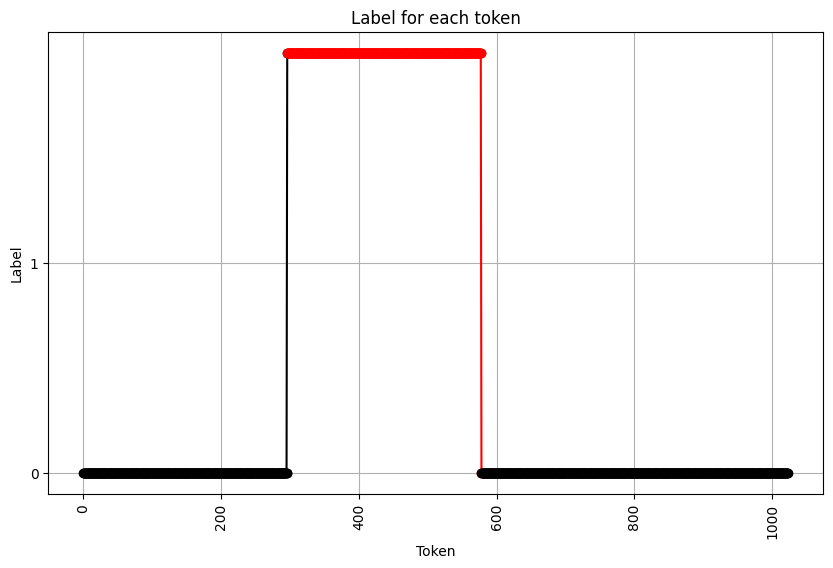

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATAHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602754.1_cds_UVX31336.1_40 [locus_tag=A1j_00040] [protein=tail fiber protein] [protein_id=UVX31336.1] [location=complement(29581..31851)] [gbkey=CDS]


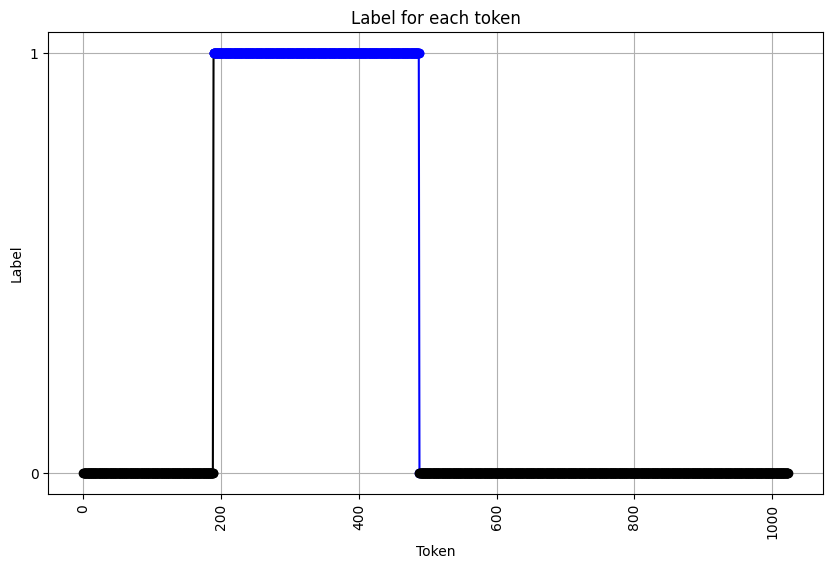

MSLTGLVKAKDPVLQLDYLRVSDVGTVGAGGDDTAVILAAIARANAEKKSLQFPERAHLKISGNVPLRFKYGADFNHSTLDVDDFTSKIYIERPAELQPYTLSNTSPEVQAIVTKGETLWGGLINAWANNTSLKNAYLVIRTSTNAFEYRNGIFKVVARNRLYRGGALAHNFDYPITPASIESIDVYPVPDYETQFGNLIVHRTSDPKDLFQVEHSRLKMHNIQCNHDGGLVSTGMIWINADNCFDVTYDSICTPFGNRYLSNPADPSSLLASYVFRFGDSYNVHLKNLHSNGLEWGTIGTDEVTNCLVEDCTLARYDSHRPFHGYLVMVGCHFGARGLSVQGAGSFMLLERCDFLNNSINDYSPNNGLPFFINSRGDAGGFVDVDLIIRDCRFVNNLGQAVHVIAQTWAPDFSSGLPAGSPYRNVTFRTVTIENPVVQTDPSNSASQVDFGVREALTGGSGTPTALNTPDMPTKITLINVNSRLSGKAVFTLNNTRPASPTRAVSVLDTDANPMTMPTNLSLVMRDCVWAAEAGVPVTLTDTTETYSADIVWDNVRNSSDSNPLSMRLFMPARMRASKSRIREIRPFYNSTTLIKPMQFLFDSCEIYPPDTLISWDSSKTNHVCSLTGCSVLGDTMAVLAKVAEHRLSGCQYFLTGSGKVRVPITTSLASGSGTFLSVANLNVDNLYMLNTAQGDWPLRIPAPANAAYMHVGFTEDGATAKRIKLYRSSGNGGAIALTLFPADGAAPLPTFVYLP*


lcl|ON602754.1_cds_UVX31345.1_49 [locus_tag=A1j_00049] [protein=tail fiber protein] [protein_id=UVX31345.1] [location=complement(36016..38412)] [gbkey=CDS]


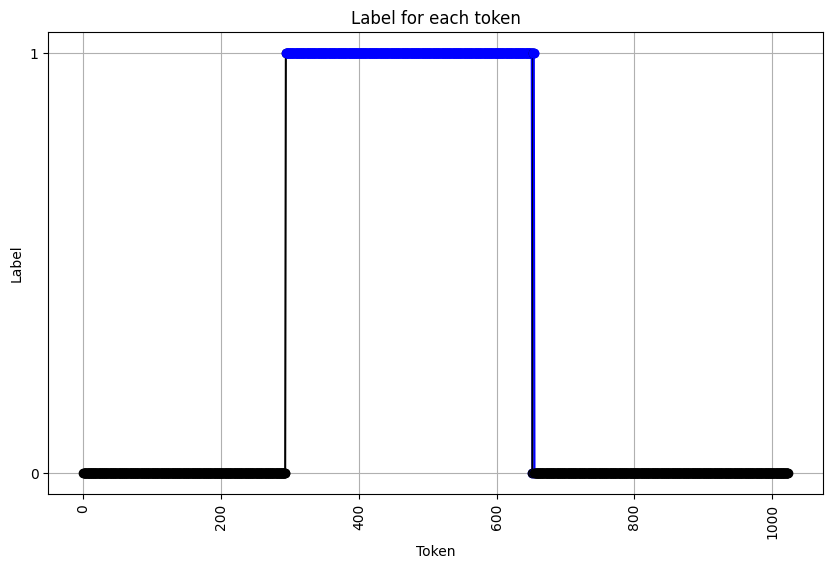

 26%|████████████████████████████████████                                                                                                      | 12/46 [00:40<02:16,  4.01s/it]

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNTQFLHLAQELVEGRSIEGFYGDINMHRYRITNLGDPVDARDAANRQYVDAGDARLDQRIDAEHAAWVAAVANEASIRKAADDALDVRTTNLEQTYFNANTNSFPWWTVLTTATDTVIPGIPFSKAKVRLNGVTQTTGYSYTVNAGVVKFAEVLPAGTLVDMTIGIDTEADTSAVSTVMGVLAAQTGAGYIGLAPGGTVAGAISYVFPEQFNVDYSNATAGLQAAIDYAVANGIRLVATNRKFIIKSQLKIPTQLNADFTGSEILADPSITSGAAVLVDGEGSVVLSQYAGTIHNLCVRRALVDGHADTTSSVDGISFGGASGQASDMRWYNMQVYGFRDGVRFDGPNTYLNHFLLPRIGFHHRRGVAVYASVNSNENHGFIGGSIFNVNNTSFNGVGLYVDSGASDTELYLSHCSIDYCDESVNLRLGRLNLNSCHLENNNNNPHIRLQYTAGKERPTVIVNGGMMAGGPGVTSWTGIPPESDGGRPALIYVHAAGSVHIHLYGCKVGDYEAGVVRNTQIVQVENNNPDVLASFVCHPLIDAGNSDSGSRPLRICDALNLLYVNAYNLNSWTQSVSRDDGTITFTAEPTVSQDPAYPGARKYVGTAGFSTSIYQTINCFAGEMFNFHAFIKVESISAGYAALRVDFLDANGNVINSEQKQVSAVTAGWQQLWVFKKVPNGAITCRVQEYYNSFTGVAYFSRESLWRH*


lcl|ON602763.1_cds_UVX31864.1_10 [locus_tag=A2a_00010] [protein=tail protein] [protein_id=UVX31864.1] [location=complement(11758..14142)] [gbkey=CDS]


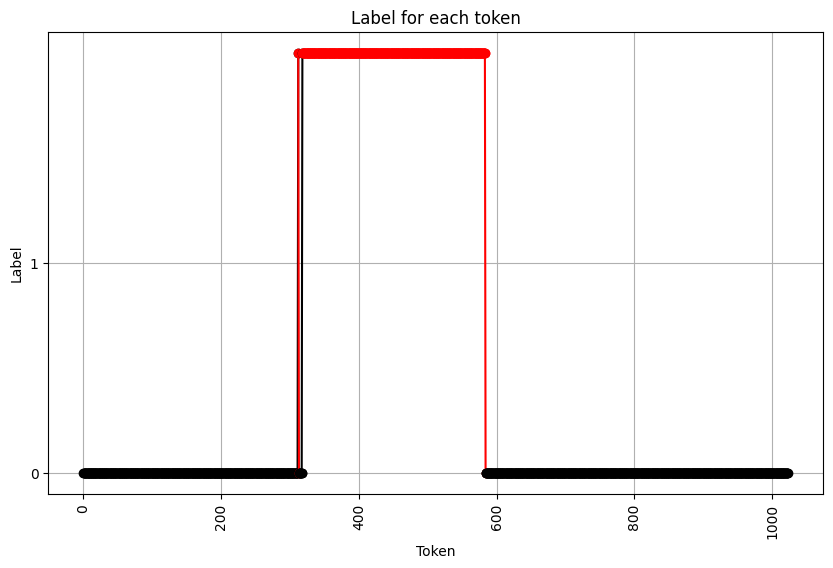

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQNNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAAVYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGESASDVETIRTEVIAEQLYTNLLTWAGVSDYTVSRLGTTIVIKRNDGANFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPVGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFEGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDSLTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYALKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602763.1_cds_UVX31903.1_49 [locus_tag=A2a_00049] [protein=tail fiber protein] [protein_id=UVX31903.1] [location=complement(41220..43532)] [gbkey=CDS]


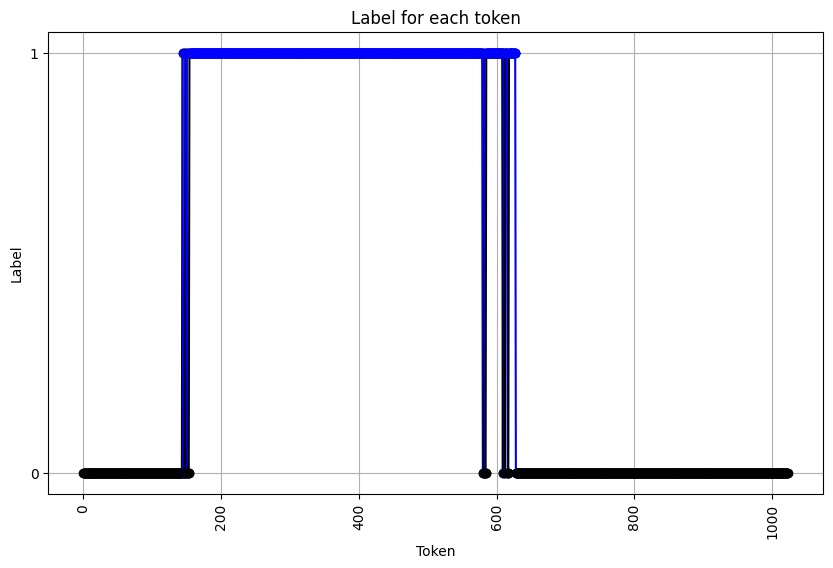

 28%|███████████████████████████████████████                                                                                                   | 13/46 [00:44<02:08,  3.89s/it]

MALTKATMVSANLVRRFKADGTEGNTLADRWSRALRSSDFGIKCDGSDETAKYIAAIAECNAKKLPLLFDNDGTGTLLLSGSDNITSYYSVDFGGNKIDISQFTGKFLIERPPEYSPTTYLASSPEVQAIVTKGETLWGGVINAWASLTNLKNAYIKITTNVNAFEYRNGLFPVVARNLLYRGGILAHHLDYPIFPSSIVSIQLFPVPDKVTTFGNAVVVKESDPRDFIVAKGSRLRIHDLQLNHNSQTVSTGMIWINNEECYDLELDNLTTPYCTKYMPGGTIAASYTFRVSDSYNVYMHDLHSSGGEWGTIGTDEVTNCHLERCSLSRYDSHRPFHGTLSGVDCNFGMRGLSIQGAGDKMVWSRCYFLDASSNDYTPNFALPYIFNSRGDMGGICDADAILDNCTFANNLNQTIHVFAQTVGPEFSNGLPSGSPYRQVSFRTITIINPTVNTIPGSNSSVIDFGLRESRTGADLPITAQNSPDMPFNITLNNVKSRDGGLCSFSINNTRPASASRATSVTNATTNPYEMITNLEINMTDCVWTDRDVSMAITDTTDTYSLRMNMKNVRQMSDIQPVFMRLYMAALISGTGCRIREIRPFFNSATLLKPMGFSFSNSEIYPNGTIFISWSETVNNRFCNLSACNIIGDSMAALSKMAAYKLAGCQYFIIGTGKVNVPISSVLTGDTGSFLYPTWLNMDNNYQLATAQGTFPIKVPAPGSAIYMVVGFTEDGTIIKRVKVYRSTGTGGGIALTKFPTDSAAPILDAIYLP*


lcl|ON602727.1_cds_UVX29207.1_45 [locus_tag=A1m_00045] [protein=tail protein] [protein_id=UVX29207.1] [location=27634..29994] [gbkey=CDS]


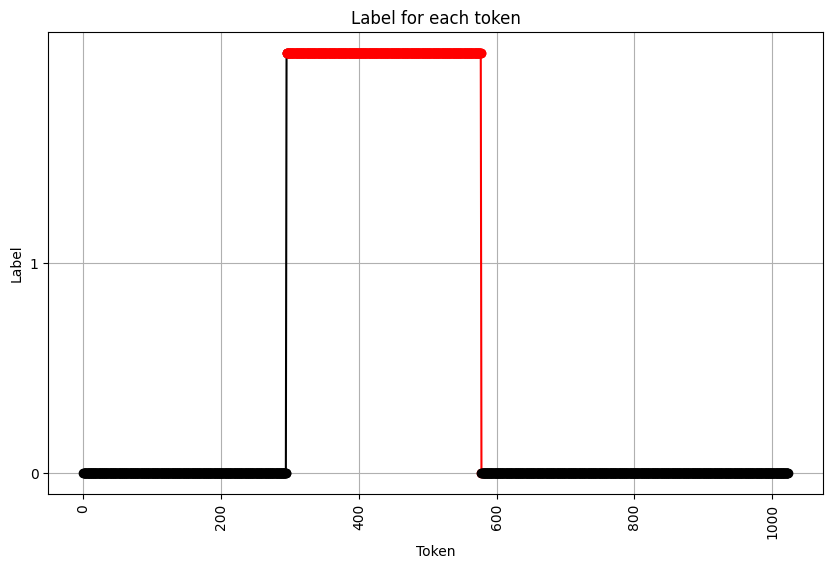

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPTEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602727.1_cds_UVX29211.1_49 [locus_tag=A1m_00049] [protein=tail fiber protein] [protein_id=UVX29211.1] [location=37035..39377] [gbkey=CDS]


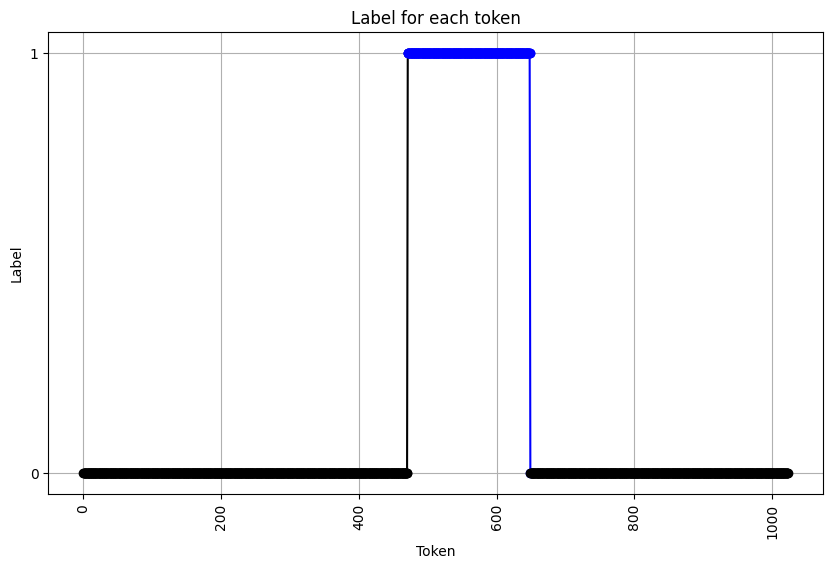

 30%|██████████████████████████████████████████                                                                                                | 14/46 [00:47<02:01,  3.81s/it]

MAFSWQESVKPAGTQNIQCDIEYLDKSYIHVYLDGAETTAFTWTSPTNIRLNSPLPAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNMQLLHLAQELVEGRYIEGFYGDINMHRYRITYVGDPVDALDAANKQYVDGGDARLDQRIDAEHAAWMAGDAALDSRVVNLEQTYFGANTNSFPWWTILTSDTDTVTPGMPFTKAKVRVNGLTKTAGYSYTVNSGVVKFTEVLPAGTLVDMTIGIDTEADTSAVSSILELLTAPSGASLISSGNAPVSVLLRRSIFEFMSAGDRTLITGTVGTEVLVDYAIAAAVAAGVTELYFPPVPGIYVVGQTPVTLPAGFSITGVAAKPYTASSNASFNSRGTVIRLASGATAPFILTNRHRFLNVILDGRNSSVNLMKGVGSNQTQYCRFDSCGIYRWLNGIGGSSSSGYTATVQVIGCALASNYRGVRNVIDSRFTDCTINANTYNGVELNAGANNNSFLNVRNEWNGAHNYFASGAKRNVVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAVVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSCTLSTSGANSDEKTFIATGSRLGGFTGTSWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFAVSSDGARSRYSEPLVRKLEITARNHTSTGSVSRFYADLIISRESATAAVAVDASSVKTHSTLSGGTWGLAGASPTGVSVTPTISSDGSTLTVTLTAVDGAPRLIWAQLRG*


lcl|ON602750.1_cds_UVX31064.1_43 [locus_tag=D7b_00043] [protein=tail fiber protein] [protein_id=UVX31064.1] [location=22093..24474] [gbkey=CDS]


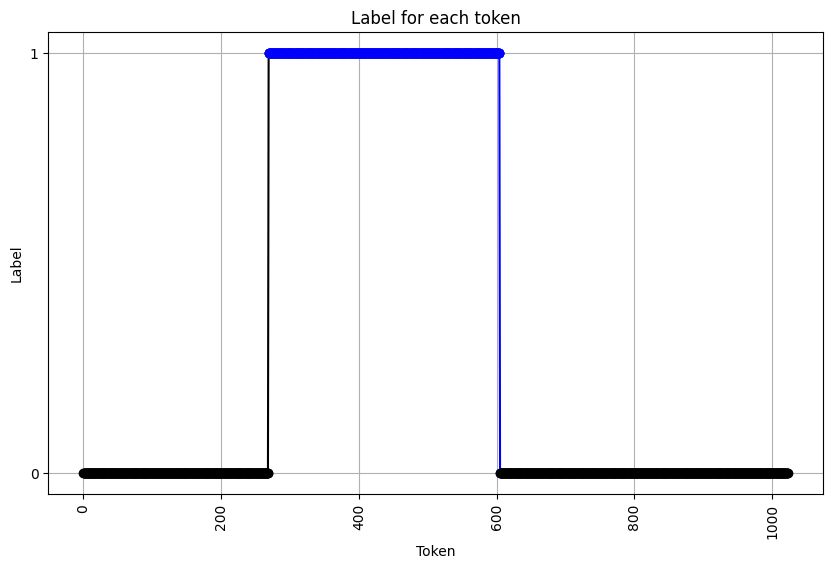

 33%|█████████████████████████████████████████████                                                                                             | 15/46 [00:49<01:37,  3.16s/it]

MALYREGKAAMAADGTVTGTGTKWQSSLSLIRPGATIMFLSSPIQMAVVNKVVSDTEIKAITTKGAVVASTDYAILLSDSLTVDGLAQDVAETLRYYQSQETVIAEAVEFFKDFDFEALQNLANQVKADSEAAESSALAAATSESKAKDSETKAKASENAAKTSEVAAETARDQVQQIINDAGDQSTLVVLAQPNGFSKVGKFASVNQMRSQFIGTVNGESVLLDSYHPGSNAGGGEFYFDASDLTSADDGVFTFVTVSGARLKRKGLDGVITLSQAGAPIDGTTNSDDAFSRLHAAIAARPEVWKVDGEGITYKRTTPLQHDISKYSINNMYLDYSAATDYSATTPFYAYMPTDSVGSSDRRNTRSMSNVIFKGPAYRTSDNIHGLRLHMDGESETLRQTVLDNVVVRDFNKGVVFGSHAYLITFRNCELWRCFAGFSDIEKVEGITFTDAGENIRFFSGLFNSLHQCFDFGTKELNINFYGTSFDYTGRTAAEAYDQFVFGDGATHQINLTECFFESGNANAGWFGKGFKANGAVTIRIVGGVIRLNQNNQCSHFFYDESGLASFSIDGATINGWGVQQWANRGLTKFRPQLKGDTSQFTLKTTDDPIVNNVKFVNGLDYQARGLNTSTYTDKATNDRIKIEQSTITKEDGTVIPSLKITKLAGYGQFADAIIKFKRPVRAQHNASIHGNIKFVAGPNMSSARVITAITGSMTPGFTNNQGVDLGFRSTTTTSNSLSLLDQEAWYSINTSWGANKSNSYLEFEYDNVRLDLTNLALNDVIHVFNLEWHGAF*


lcl|ON602728.1_cds_UVX29269.1_50 [locus_tag=A1n_00050] [protein=tail protein] [protein_id=UVX29269.1] [location=31872..34130] [gbkey=CDS]


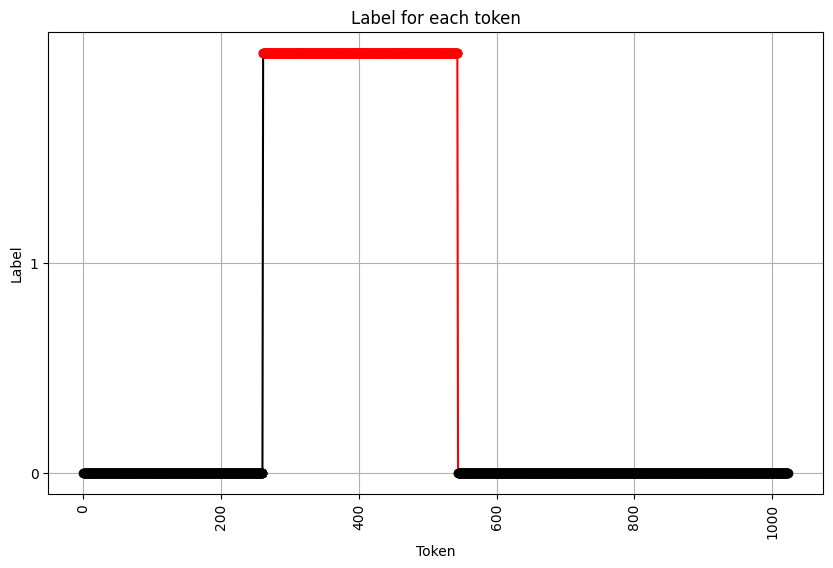

 35%|████████████████████████████████████████████████                                                                                          | 16/46 [00:51<01:22,  2.75s/it]

MLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602723.1_cds_UVX28987.1_55 [locus_tag=A1p_00055] [protein=tail protein] [protein_id=UVX28987.1] [location=32970..35228] [gbkey=CDS]


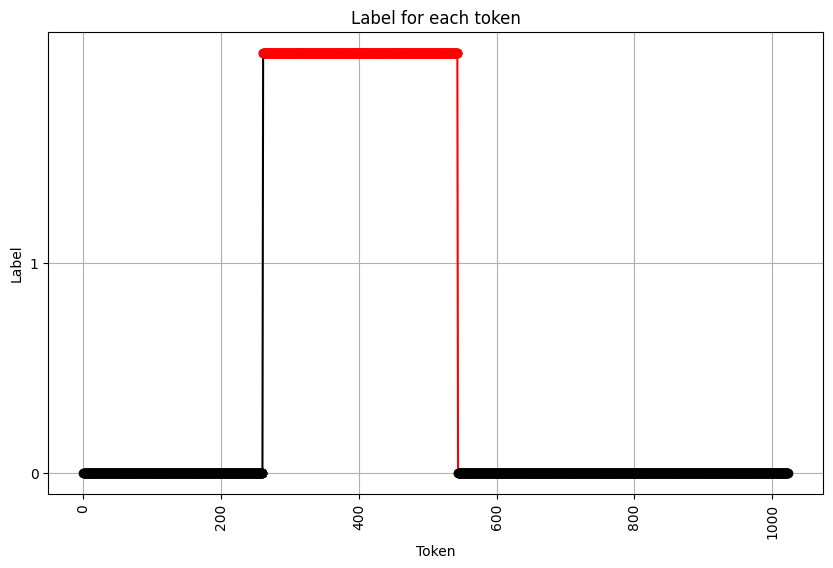

 37%|███████████████████████████████████████████████████                                                                                       | 17/46 [00:52<01:09,  2.39s/it]

MLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602753.1_cds_UVX31285.1_36 [locus_tag=A3d_00036] [protein=tail protein] [protein_id=UVX31285.1] [location=22885..25260] [gbkey=CDS]


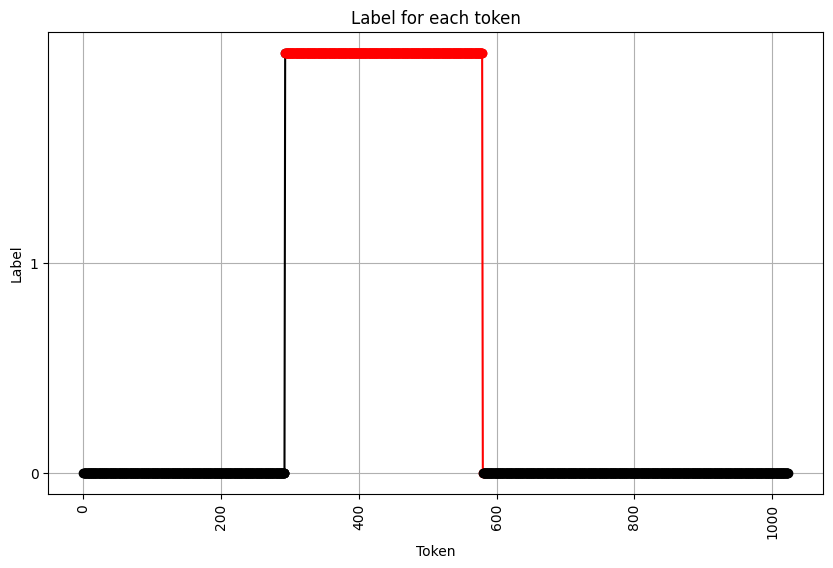

MALVSQSIKNLKGGISQQPEILRYPEQGSIQVNGWSSETEGLQKRPPMVFIKSLGDRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGERSYVTVNNPKDNLRMVTVADYTFIVNRTRQVRENQNVTNGGTFKDNVDGIINVRGGQYGRKLEVNINGVWVSHQLPPGDNAKDDPPKVDAQAIAVALADLLRTAHPTWTFNVGTGYIHCIAPAGVTLDEFQTRDGYADQLINPVTHYVQSFSKLPLNAPDGYIVKIVGDTSKTADQYYVKYDASQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHEWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVMSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFTCVLTKGAPSKVFIYKFLYMDENIRQQSWSHWDFGDGVEVMAANCINSTMYLLMRNAYNVWIAAVDFKKNSTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITTYEPMGDSWNSTPDIRISGDIAGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDAGRLQLRRAWVNYQDTGAFTVSVDNGSREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602753.1_cds_UVX31290.1_41 [locus_tag=A3d_00041] [protein=tail protein] [protein_id=UVX31290.1] [location=32636..35590] [gbkey=CDS]


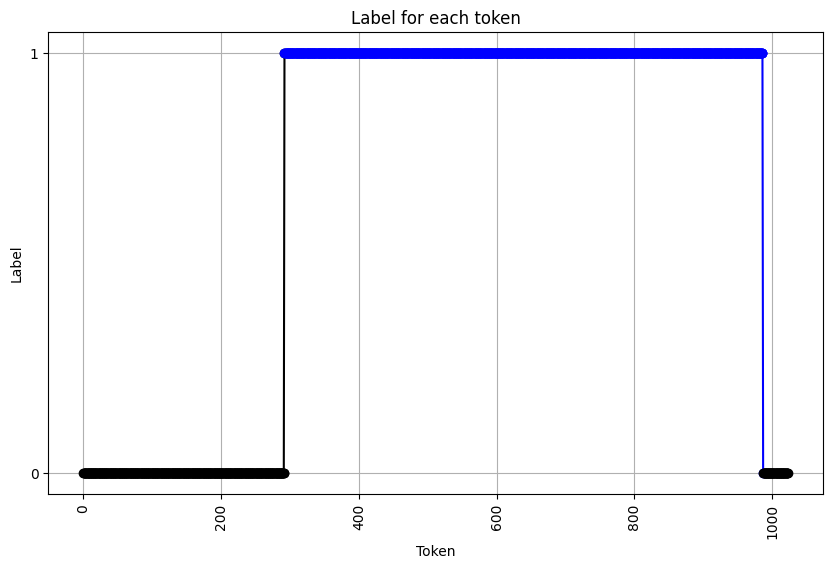

MDQDIKTVIQYPVGATEFNIPFDYLSRKFVRVSLVSGDNRRLLSNITEYRYVSKTRVKLLVATTGFDRVEIRRFTSASERIVDFSDGSVLRASDLNVSQIQSAHIAEEARDAALMAMPQDDAGNLDARNRRIVRLAPGVDGTDAINKNQLDTTLGEAGGILSEIKEEKDEFYEYLEKFADDTTMLRGVVWVYNSGSANGGETTLIINKPTSVFAVPYLEINGHRQEVGYHYDFNASTQTITLAKPLVAGDFVMAMTSESHIPLESLLAGPTGAASIGTREGGTVQDALDRIPKVVTPEQFGALPNGADCGEKMLLAWKYVATNGGTLVLGSGTYYVGKTRFHFNYSDGLKPHSVVGQGDSTIIKFGDIPPSGLQPGHNWVKEDPLVRYLGNSGTQYVPKVTLEGFLMDYSEQSNKGGTDLSSLDVTHPTPYSLGVWGIYFMYALQPTVKNVSMNQIYGDGVFIRKSTMPHVTGCRLFDVSAGNIITRVNPNMASDSNGGGIFIWACHGGLVEDNICWNTRVYKASVTSIDNGTQIKNTLCGYIGIWSEFGSNQNTPSESPPPLLGYVNQSNVDNGWNFESLGCVIRNNTVYGYTIGIKTEGFNEAHIKDNVALNAYLPIYAANTRSVVSGNWTDMLYCDNRTCPQGGFQSVRASILANNFVNTFDGARVGVTLKDNKCYCTNYAGFRVNRTAAVIEGNMFRFARGAAWPFDVNLSAQINGVLIRDNLFFFDSTVTSVVTANLQYHVGTQFTGNRFINRSQSLVTLAFRANCSGLNISENLFDGALFVSVQGTAVVSRNTFADSATYKGMRFNVTAPSVVRENSFKFELGAAIDNISLQADNVHFLNNTIEMTGSGTTPNGAAVSMPGSNKGATLVGNTIQGNPAGIPMFYLFGAHFPHIDRNKNSGSPLLRYSGTIYAPVHIGYNVASSVFQTEPASELNAIGNISTEFTPYVGMRMNYLRPDSGGKEGLVYTTTGWKSFGSIS*


lcl|ON602753

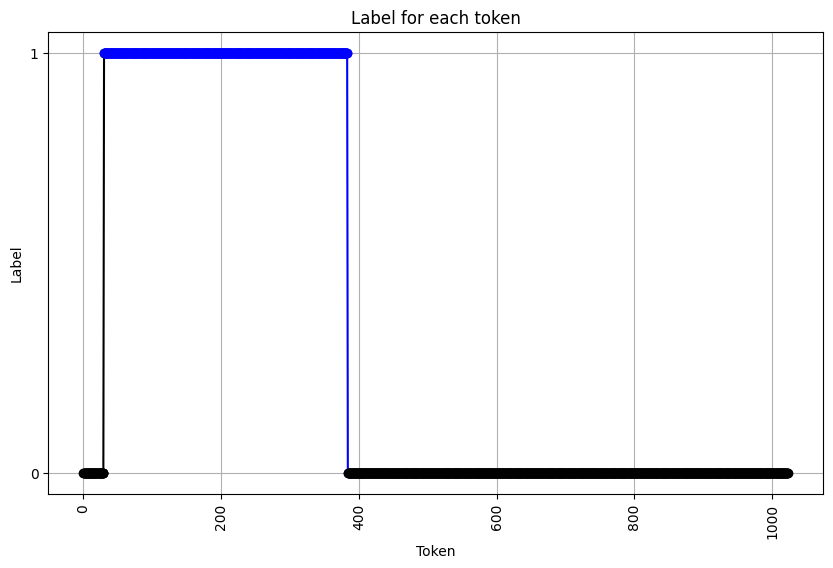

 39%|██████████████████████████████████████████████████████                                                                                    | 18/46 [00:57<01:31,  3.25s/it]

MIKSDFNQPKGSTIGVLKDGRTVQQAFDWDENFVTLERFGFINGSTTDQTDAIQKAVYYAVNNGMTLIGTPYAKGYTTKGIILPPTLRADWRGFTIKTTTSGITAVTVASGDAPIVLPFVAGTPLENLRVEGRFLAGTTATPDETFNSDGLSFGDTGSAQVSDMIIKGLTVAGFRDDLVFRGPSVYLLKFFGPKIGVAWRRGISWLASVDSGENVQFFGGSVYNCINSTLTAVGVHHSPESTGLEMCFNGTSFDYNDQDLFQIHSTFRFDKCHFENNNNQPKITIQNTSQRPASILQIRDSNIVGGPGGSPLNADREDSLGRPCFIDVLGANTSVLVTDCTAGKWMLGAQKTQVVRNASGHQMRALRVTTVADVGPAATQGWPLNHSFALNQLYVAPNGSFNGWTQTVGSGVVFSSDTSVKAPHDTGSRVMTRPAAAGATSMSFYQDIPVRPGQSVIIKSWLQTSGVVSIGGRAGIRAVFLDSTKAVTIYDQVQPRQVTADGSITECATILCVPNGAAFIRVQTYVQNIPTGTDAVVYSSGERVWVS*


lcl|ON602738.1_cds_UVX30242.1_34 [locus_tag=S13a_00036] [protein=tail fiber protein] [protein_id=UVX30242.1] [location=21283..25005] [gbkey=CDS]


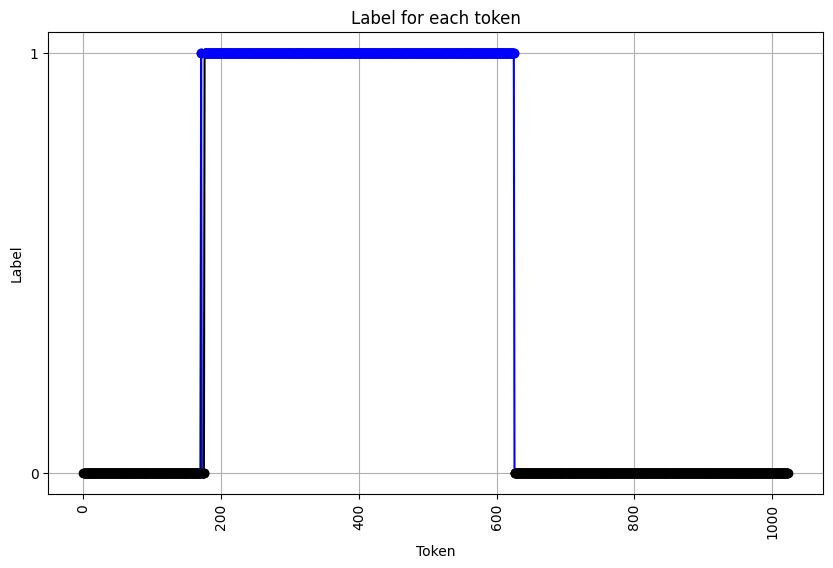

 41%|█████████████████████████████████████████████████████████                                                                                 | 19/46 [01:00<01:20,  2.96s/it]

MATNPTNNPIPSEDPRDLKFNAGKIDEEVNGSADYYTDRFGVQRLTNAGRNHQFQDAQTERSSIFTEQLTSQEEEFTTQLSGQEDQFNQQISEQHSEFTAQITEQRNEFNDMLAASGYSWLADYVDGPVTFTNRSQVTVYNGVAYRLSAATDIPFTTTGNNATSWANDSTHLVAIGDNDIRQQVQYQFGQWLPSVVAMLISNDTYSSIRTRGFYAPNDGGDGVWIATGNTVPSKAGTHDPAKARIYNANGVEYQLNVQSGFEINAKANGVKAVDDVDAETEDFVCLGEAINGITSRVKTMVNDEDLKTYLKVIIPSEYPLRIGKTSIKAYSRLKLDFQQASIYDRPSPSNRQEVTGVYMNAIERGIEDVRAISARFGGATSYSNMTLSDFHIEGGKFYGDHTTDKGVADCSTGTGLFTYNMENSSIRNTWFQGFACGRQYNRTGPGYYFDNLGNKVVGTLVPEATTSGAGSYEGVKEWSVTAYGCRYLYLRVLSNWARFDNCKFGTYADWSSSPDGNQCEYFIENRGAGVVFSGGVIEANTAAANPTKGYVRDFARGCTFEGVYYENCLSAGWVVAIPEKSQYNRANGLFLTAIGSQFTLSSKGAPLIKFEEGYFGSYNPATGLYETGGWETNYQYAGGVNTWSVGQPVVDSGAFPHGGYDFKYGTYGIHYSGSVPDVDSLRDTPEGNEFLSQYGLPVNSGILLFTTLSPAYQSNIVVWYKDLTGNFDPRNIVVGDFDNNNVSDGTSNALYRTNGFHYYDYGNGYKAAIVPYVNPRALDNRMTTSAGRKLKITVTSDAPIILKNIQAFVGGTPLFPPALKEYVPRSQRDRVWGTMSAGSTDSGAYYGPLVGGGIFRPGDVVLPFVPFSNAALMNPASYTDISAGYGSNTDTAVITGGAAWGAGLAGATFTLTVEAQDTTNNWTTVSVPSAYLPYVFTGMPVNVTANSSGGATGLINTVRRIINSDGTMSNKYVLSGALGAAGTTLTASTNGSYTVRSGVS

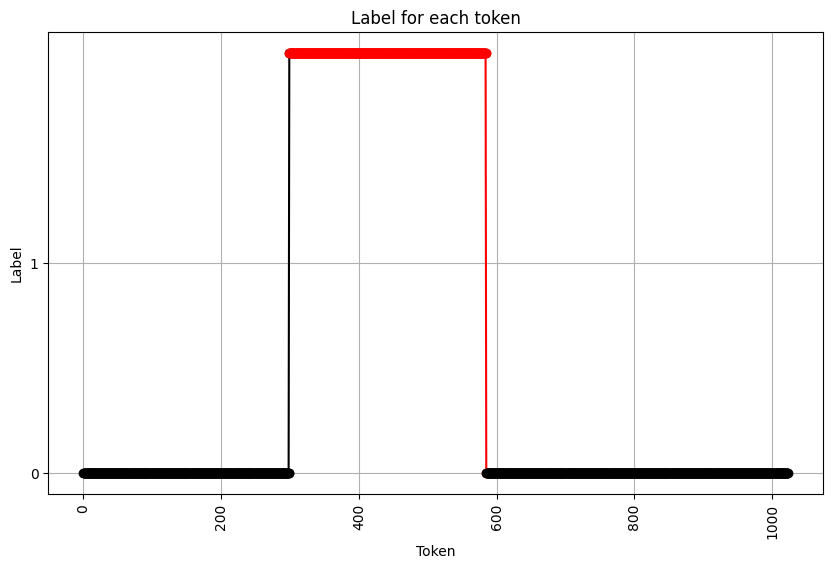

MALVSQSIKNLKGGISQQPEILRYPEQGSLQVNGWSSETEGLQKRPPMVFIKSLGDRGYLGDRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGDRSYISVSNPKDNLRMVTVADYTFIVNRTRQVRENQNVTNGGTFRDNVDGIVNVRGGQYGRKLEVNINGVWVSHQLPPGDNAKDDPPKVDAQAIAAALADLLRVAHPTWTFNVGTGYIHCIAPAGVTLDEFQTRDGYADQLINPVTHYVQSFSKLPLNAPDGYTVKIVGDTSKTADQYYVKYDASQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHEWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVLSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFACVLTKGAPSKVFIYKFLYMNEDIRQQSWSHWDFGDGVEVMAANCINSTMYMLMRNAYNVWIAAVDFKKESTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITTYEPMGDSWDSTPDIRISGDISGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDSGRLQLRRAWVNYQDTGAFTVSVENGNREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602755.1_cds_UVX31391.1_44 [locus_tag=A3c_00044] [protein=tail fiber protein] [protein_id=UVX31391.1] [location=33598..36225] [gbkey=CDS]


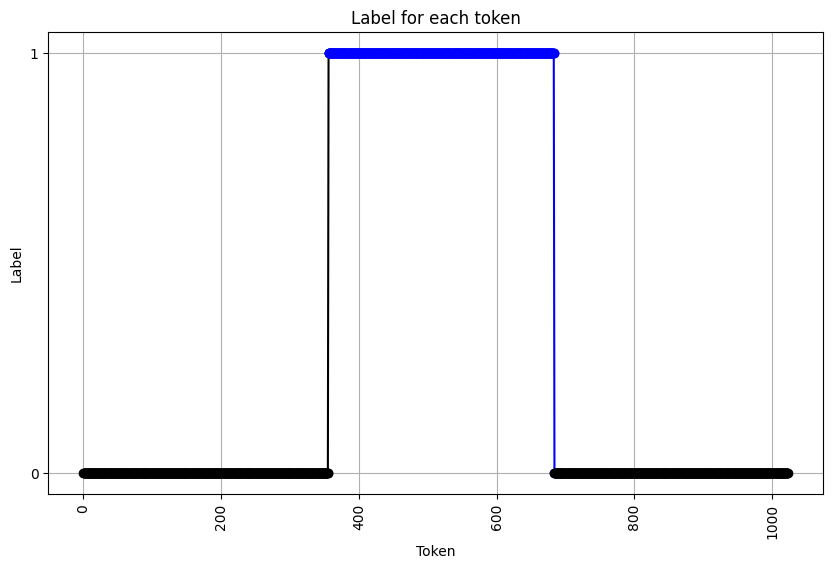

MDQDIKTVIQYPVGATEFDIPFDYLSRKFVRVSLVADDNRRLLSNITEYRYVSKTRVKLLVETTGFDRVEIRRFTSASERIVDFSDGSVLRATDLNVSQLQSAHIAEEARDSALLTMPQDDAGNLDARNRRTVRLAPGVEGTDAINKNQLDTTLGEAGGILSEIKQTEKDIQDYIENFADDTTSLKGINWVYNNGSANGGETSILITRDGPVFAVPTIYINGDRQSVGYHYSYDSGDKTIHLVKPLTAGDFVECVTSEGVLPLSNLLSTPDGASQIGTKSGLTVQDYLNGVKSATILRNIEPVIDGQRIVLSEISPTLGPKSGGTLVYDQSDTSSVDDGYTVFVTAGGKRWKREESYIDVAWFGPNFGLALQTAVNLVDNYVRTVGFYSRKTIYIAAGTYTTDRQVDIPSYVSVVAIGNVSINGSELPVNSYVLRITNKVGGIVTTHHSGWNLGAVGGTLRLVGNGNTGQVDGLYVGGATSMSDVRNVSLYAVSTSGVRYGLTFGSTNTYLFTATKCHFETSLVNLYIPGTTSSNSGEKMVFNDTVFGGSSRNHVEVSTPCMDLTFNNCSFDFTSGSVLYGTETWGYAKVGLNNCHFEGFNSLWIKVDAPQGGFIGSNRAITVSNATVLPRLRSNTTGTNSASRMHIDAKSTPVYISGLDLRHEVVPYTEEIFMASAETTLSLQGYLKDPYFQIPSAAHIQNRGWNIADETTGTVVNSPATLDSLTRFTCTERNAMSAAVVDGGTSGKLLAMTGAGGYFTLVTKGFIPVSTFQRIGGAMSVQAAASTGNIQCTIGVQWFDYDGNLIGTNQAFAINMREVFNNSSLPNFAEGNNRFISTSARTFRAPAGAAKCKPLWRISGHTGVVNISRLASFVL*


lcl|ON602755.1_cds_UVX31392.1_45 [locus_tag=A3c_00045] [protein=hypothetical protein] [protein_id=UVX31392.1] [location=3

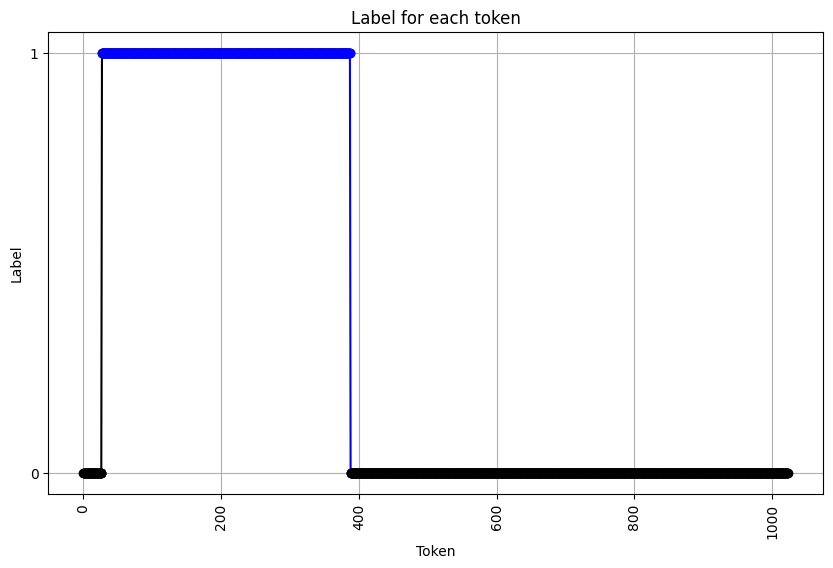

 46%|██████████████████████████████████████████████████████████████▉                                                                           | 21/46 [01:05<01:08,  2.73s/it]

MLNDFNQPKGSTIGVLRDGRTIQQAFDWDENFVTLERFGFTKGSTADQTDVIQRAIYYAVANGLTLIGTPYAKGYTTRGIIIPPTLRADWRGFTIKTTTSGITAVTVASGESTIVLPYVAGTPLENLRVEGRFLAGTNATPDELFTSDGVAFGASGSSQVSDLVIKGLGITGFRDCAVFRGPSVYLLTFVGAKIGACWRRGVSWLASVDSGENIQFFGGSVYNCISSNLTAVGIYHSPESTGLEMNFNGTSFDYNDQDLFQIHSTFRFDKCHFENNNNRPKITIQNTSQRPASILSIRDSNIGGGPGASPLNSEREDSDGRPCFIDVLSANTSVLITDCTPGKWMLGAQKTQVVRNSAGHAMRALKVTMVSDVGAASTQGWPLNPSFFLNRLHVVPNGSLTGWTQTVSSGVIFSSDTTVKAPHDSGSRKLLRPAEVGATSMSIYQDIPVNPGQSAIVKAWLQTQGIISVGGQAGLRVLFLNSSKDVTIEDNVQPRQVSADGVLTECATVLYVPNGAAFMRVQSYATNMPIGTEAALYSSGERVWLS*


lcl|ON602740.1_cds_UVX30347.1_5 [locus_tag=A1l_00005] [protein=tail protein] [protein_id=UVX30347.1] [location=complement(8381..10741)] [gbkey=CDS]


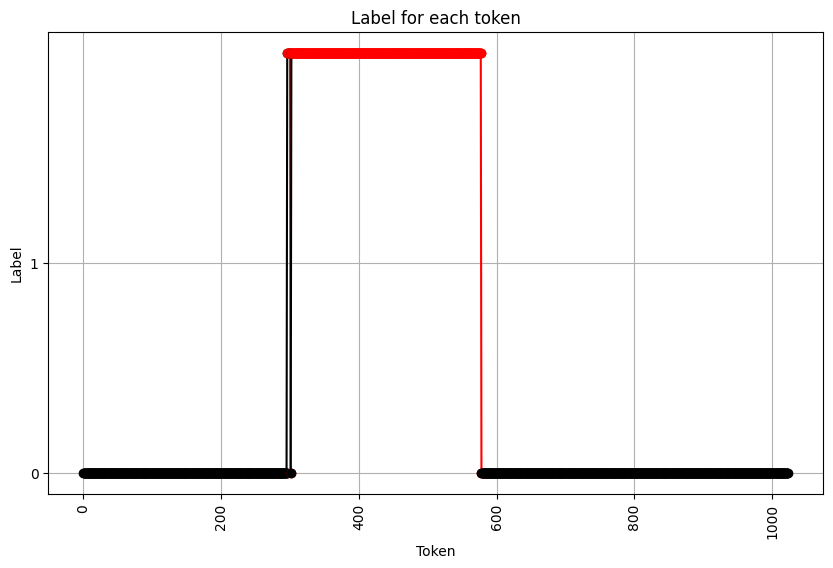

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIASLTYILNTEMTPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDREQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLVVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602740.1_cds_UVX30400.1_58 [locus_tag=A1l_00058] [protein=tail fiber protein] [protein_id=UVX30400.1] [location=complement(42405..43229)] [gbkey=CDS]


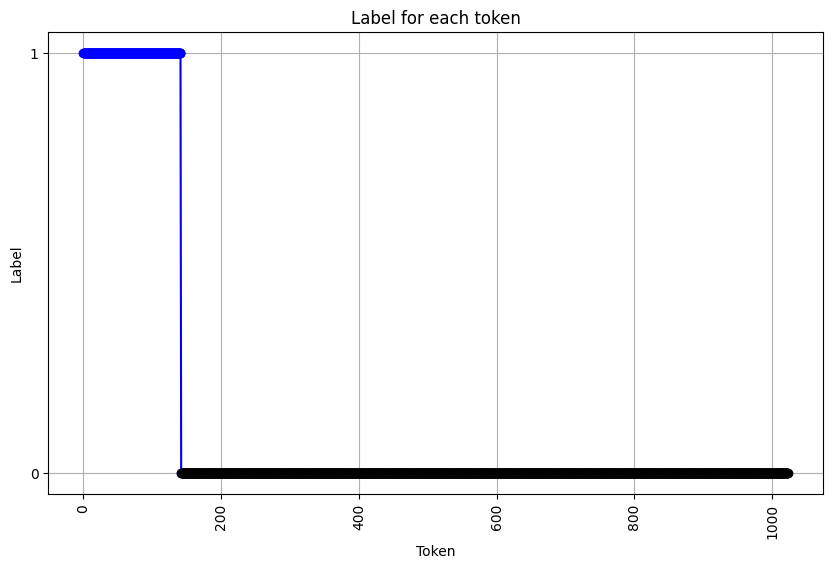

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 23/46 [01:08<00:50,  2.21s/it]

VVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAVVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSCTLSTSGANSDEKTFIATGSRLGGFTGTSWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFAVSSDGARSQYSEPLVRKLEITARNNTSTGSVSRFYADLIISRESATAAVAVDASSVKTHSTLSGGTWGLAGASPTGVSVTPTISSDGSTLTVTLTAVDGAPRLIWAQLRG*


lcl|ON602733.1_cds_UVX29715.1_2 [locus_tag=A3a_00002] [protein=tail protein] [protein_id=UVX29715.1] [location=1548..4493] [gbkey=CDS]


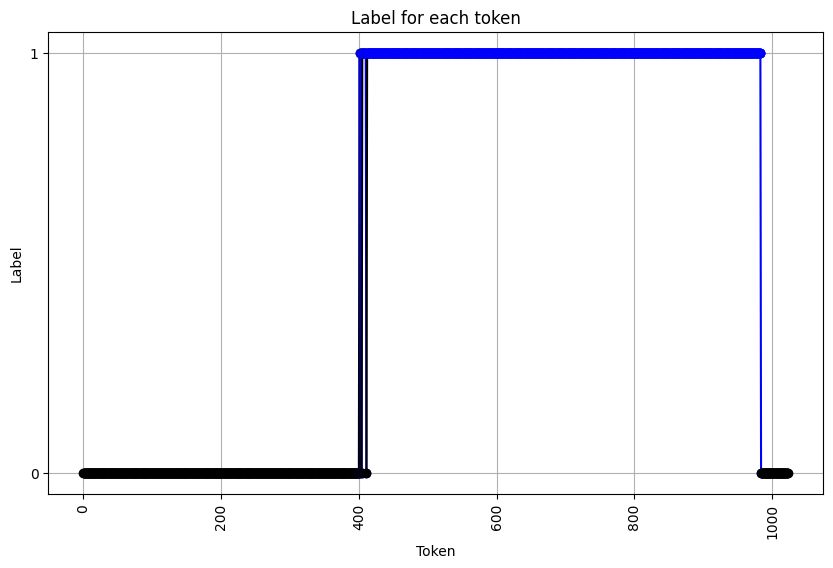

MAITVRTVTTFPLDDAQRDFNINFDYLARKFVQVAVIDSTLSKPRKELVLGTDFRFTTKTALNTTIAWGPNDGYDRIEIRRVTSTTERVVDFADGSILRATDLNASQVQAIHIAEEARDAALLAMPQDDQGNLDARNRRIVRLADGIESTDAINKGQLDSTLGEAGGILEDIQQLEKDIHGYLENFADDTSMVRGVSWVYNGGSANGGETSFVIAKEGRIVAVPYIEVNGSRQLRGYHFDYDSITKTITLAKPLVAGDFVVCQTAESVIPFLDLIAGPTGASQIGVAGGGTVQDTITHVTPEMFGAVGPDHTAALKSAFAYPNVQLKPGKVYTVSEVLPASNLKNLKGNGATIKYVGPVTSGMTLISMGKSKGALTGLSIPVTAGSATVTIPGISAIATVGDLLSIRSSTQRLSAPESNYMFGQRCVIQSITGDTVRLVEPFFESFTAVSCTVHSGVPLSVDGLTIDMTSVGTTTSLVETLSMTGVRLSVSQCAIYGSPYGSAGLVLQGCNARVDRSVIFGFLNANGVSSGGRTGYGVYIDCNNTVIDGNSIGGCKHAITCASRSFVMRGLVVTGNNVSSIGATNPEAVLDLHANVLGSPVFSNNTISASRSAFGIRNGGAKIVDNTIYCDRSGEATPALIGLDEYPDVYSVEVSGNILKCSSNLRLLSISEINSLNNLVVSGNRGTIGSIIDQAMNLVSINDLTIENNVLSGMYGILNASRRSVASTQPMFSKLDRARIKNNRFDCGANTVASNVISLWSNANTPASSKLNVIDLEFDGNHITSAHTPIFLDLVRLVGVTSFSNNTLSHATSAGTTTPPTQSSIALTNVNVEMLEAHGNVMSGRIRFTTAVTQRSTNLAYPTEDFALAVRILGNSGLGVTFENLTTTGFGFKIDHSAVRGNTFVSPYGTTIGVVTSNGLTGWTGGVLDISDNTLLPASGNSVGIGVGFQTHSIVIRGNLLGAPIADSSTPRVPPAFNTSL*


lcl|ON602733.1_

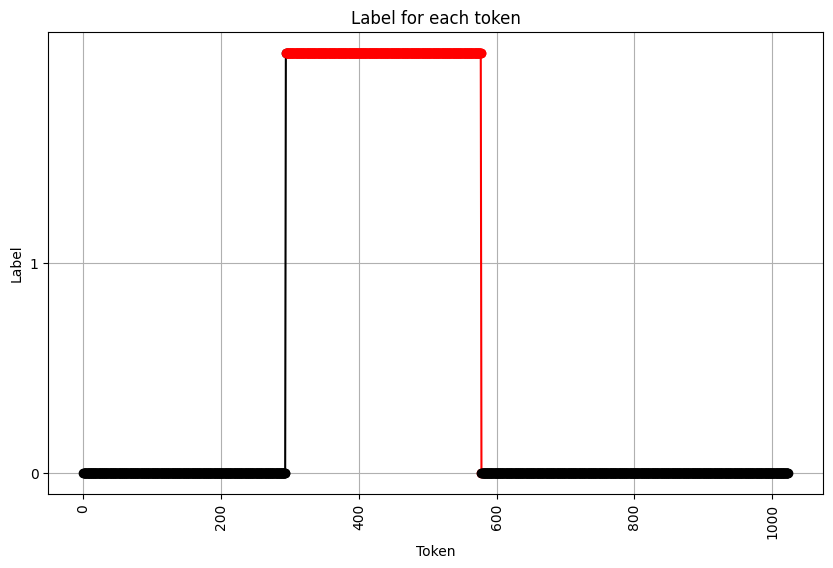

 52%|████████████████████████████████████████████████████████████████████████                                                                  | 24/46 [01:12<00:57,  2.60s/it]

MALVSQSIKNLKGGVSQQPDILRYPEQGAKQVNGWSSETEGLQKRPPVVLKKVLGDAGYLGSDPMVHLINRDENEQYYVVFTGSSIRVFALDGTERTVRGDFSYVTTGNPQKDLRMITVADYTFVVNTTKTVEVNDGSLSNGGNFQDNVDGLINVRGGQYGRKLVVTINGTTVEHQLPSGSNATEDPPKVDAQAIAEALAVLLRAALPSWTFDVGTGYIHVQAPSGTTINEFITKDGYADQLISPVTHYAQSFSKLPLNAPDGYLVKIVGDTSKTADQYYVKYDKTQKVWKETIGWNVTTLLHFHTMPWALVRAADGQFDFNWHNWEPRKAGDDVTSPHPSLVGSQITDVFFWRNRLGFLSGENVVLSRTGRYFDLYPPSVANLSDDDPIDVAISHNRVSILKYAVPFAEELLLWSDEAQFVMSASGVLSAKSVELNLTTQFDVQDGARPYGIGRNIYFASKRATYSSVYRYYAVADVSEVKNAEDITTHIPQYIPNGIFSINGSGTENFCSVLTKGAPNKIFTYKFLYIDEQIRQQAWSHWEFPEDVRVLAADSIGSTMFLLMKNHTHSWLGQVDFTKDTTDLPNEPYRLYLDLKKEYTIPSSAYNWDTNETTVTLSSVFGMTLGGNSKLSMVEEDGKVTTWDTYGSTVSMIGDYSGKHVFFGVHIPFTYEFSKFLIKKTDEYGSTSTEDSGRLQLRRAWVNYEDSGQFTVSVQNLSRTFEYDMGGNRIGSDKLVLGKLNLGTGQYRFPVVGNARVNTVTIYSEAPTPLNIIGCGWEGNYTRRTSGI*


lcl|ON602765.1_cds_UVX31968.1_8 [locus_tag=A2b_00008] [protein=tail fiber protein] [protein_id=UVX31968.1] [location=complement(6907..9219)] [gbkey=CDS]


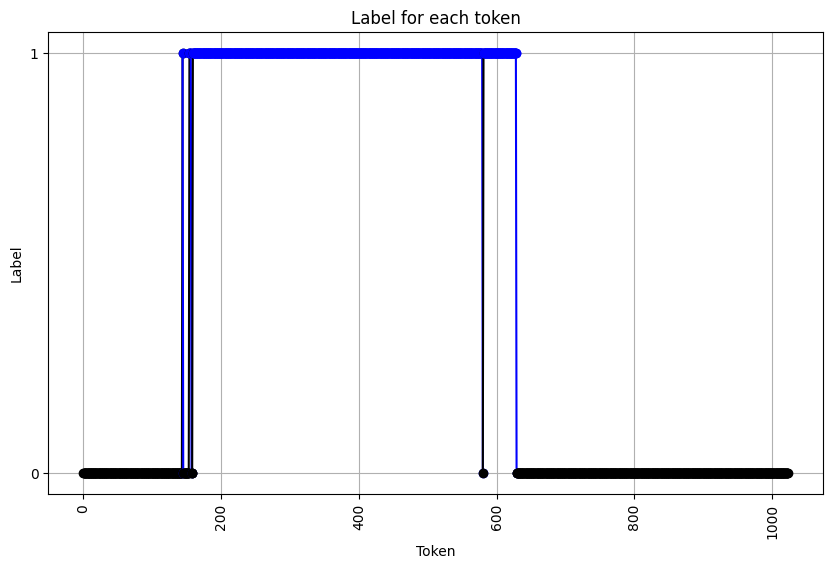

MALTKATMVSANLVRRFKADGTDGNTLADRWSRALRSSDFGIKCDGSDETAKYRAAIAECNAKKLPLLFDNDGTGTLLLSGSDNITSYYSVDFGGNKIDISQFTGKFLIERPPEYAPTTYLASSPEVQAIVTKGEMLWGGVINAWASLTNLKNAYIKITTNVNAFEYRNGLFPVVARNLLYRGGILAHHLDYPIFPSSIVSIQLFPVPDKVTTFGNAVVVKESDPRDFIVAKGSRLRIHDLQLNHNSQTVSTGMIWINNEECYDLELDNLTTPYGTKYMPGGTIAASYTFRVSDSYNVYMHDLHSNGGEWGTIGTDEVTNCHLERCSLSRYDSHRPFHGTLSGVDCNFGMRGLSIQGAGDKMVWSRCYFLDASSNDYTPNFALPYIFNSRGDMGGICDVDAILDNCTFANNLNQTIHVFAQTVGPEFSNGLPSGSPYRQVSFRTITIINPTVKTIPGSNSSVIDFGLRESRAGADLPVTAQNSPDMPFNITLNNVKSRDGGLCSFSINNTRPASASRATSVTNATTNPYEMITNLEINMTDCVWTDRDVSMAITDTTDTYSLRMNMKNVRQMSDIQPVFMRLYMPALISGTGCRIREIRPFFNSATLLKPMGFSFSNSEIYPNGTIFISWSETANNRFCNLSACNIIGDSMAALSKMAAYKLAGCQYFIIGTGKVNVPISSVLTGDTGSFLYPTWLNMDNNYQLATAQGSFPIKVPAPGSAIYMVVGFTEDGTIIKRVKVYRSTGTGGGIALTKFPTDSAAPILDAIYLP*


lcl|ON602765.1_cds_UVX31982.1_22 [locus_tag=A2b_00022] [protein=tail protein] [protein_id=UVX31982.1] [location=complement(22541..24925)] [gbkey=CDS]


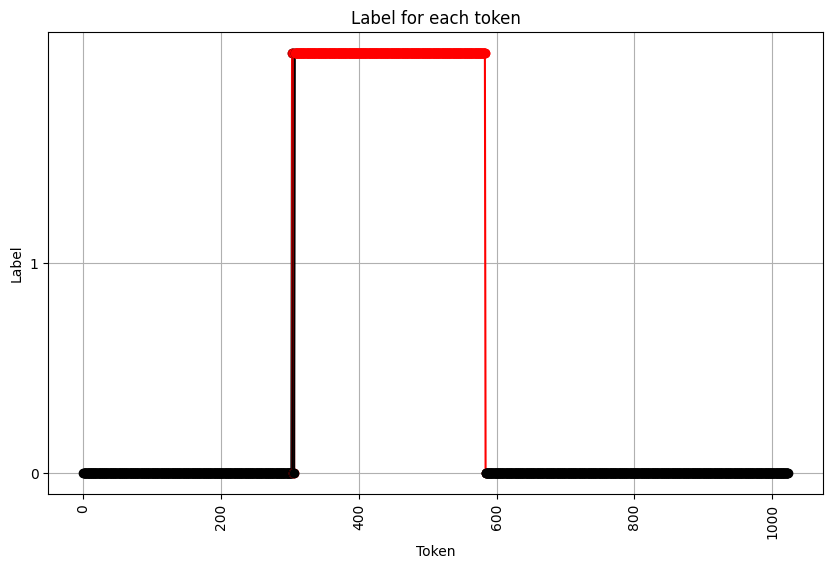

 54%|███████████████████████████████████████████████████████████████████████████                                                               | 25/46 [01:15<00:58,  2.78s/it]

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQDNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAASYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGGSASDVETIRTEVIAEQLYTNLLTWAGASDYSISRMGTTIVISSLSGASFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPAGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFNGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDELTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYALKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602736.1_cds_UVX30045.1_147 [locus_tag=M5a_00170] [protein=tail spike protein] [protein_id=UVX30045.1] [location=86523..88430] [gbkey=CDS]


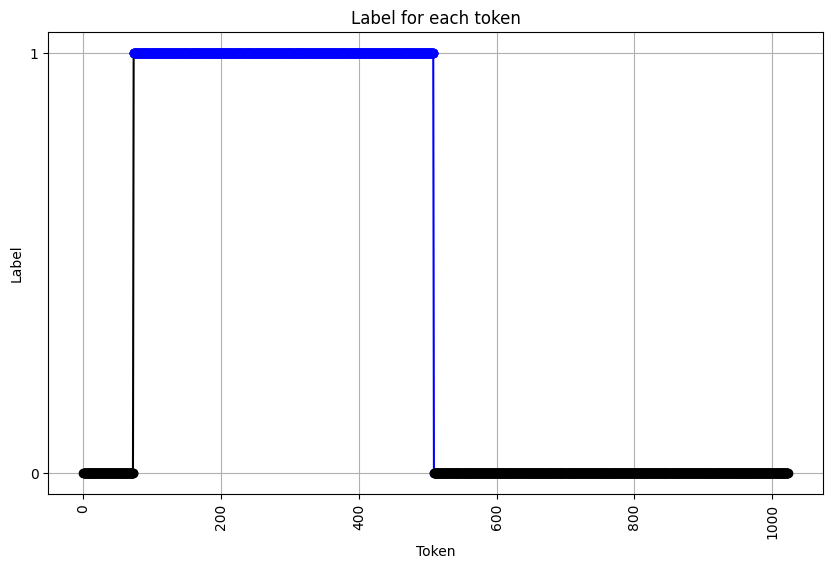

MLQSVKISELPSADTLTEDDLIVVDQPDDTKKATLFQVVNEFSEQIGQNILSDLKQSSGAGEIGAEKGGTVEDYLIDISVDALGDFKNDQDGCAEAIMAEIQRITGMIDSAYVAGQKKFISVRFGNGNYTLKDCLLYPGVKYSQAPFGRIRPHPDGQWAFTTEGTAGVPLWQRLMYAEIDTMVIGDRWEKTGDMPAGKGGINLKFASYFRLRNIACRHLDGMAIYGGEIFDCPFDNVSIMYCGNNDDPNNLVPCFRLDNAGGTDATNACHFNRFHLEANHAGMVLNKCRHLIFTAPKIERDETSHLLQGCQGVTFSNAGLTWNYDDKPQFLISEVTGVSPSDSRGVKFEAPSCISSSRGKGWYFHHDGNAAPLEINNHFASGIKRLATGRRIKIFGGSAYDCGPTMVVGDNNVTVDNVEWRALRAVTVGDGSDDTIIFKGTGCAARKCKIESQAGSATDGGAFINTTATTDTEATGNTFGGYRQYGVRGALSNDVRDNKIDPANAHVGAITNQSSSKYTLTNTNKTGLGVGSINSGVYTLAPGTNLSPAIVGGCSKILARVIIGGQASSAEFLADSSISGLGVGPILGTLLSFSAGSAGDGLVHITKPSTGGSVTITNNSVSTATVVILAITAHG*


lcl|ON602736.1_cds_UVX30050.1_152 [locus_tag=M5a_00175] [protein=tail fiber protein] [protein_id=UVX30050.1] [location=96188..97225] [gbkey=CDS]


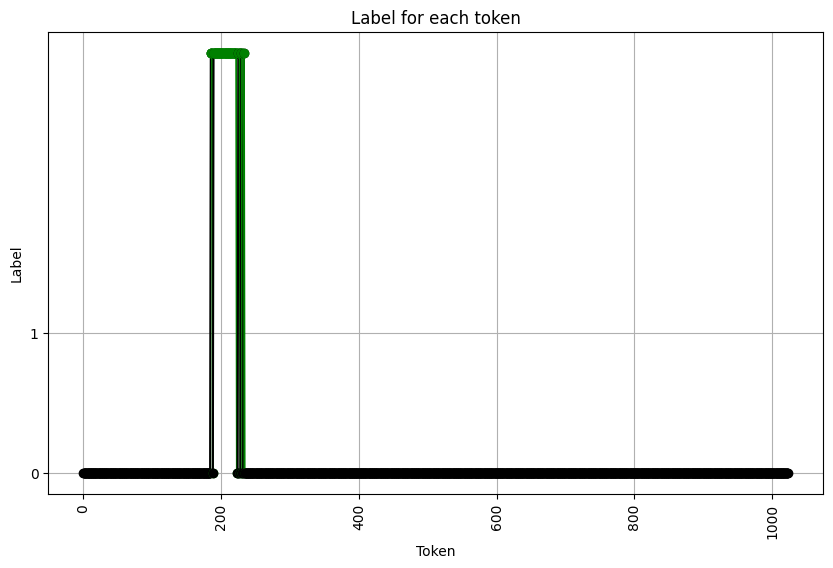

MAIPTIPLQIWAESDVVLPNAHTANKISPIADLWDKGWDLGEKPACEELNYVLNMMTWWMTYISEEQIPGLSNDYLRKDQNLSDVSDIPTARSTLDVYSKSESDSRYVNVDGDTMTGPLTVPRINFPVGTSDSAYITTTLGNDITMLDFVIGDNSGTAGSATVDSIRFRFSPTDTSSTFTMMELNATGTNTALLRVQGNITATGTMTTGTLASTTINNGGNIQTTSLGVGGTATLQNLVVNSNNATIGGRSVVRAVNSTAANANGDVSISIGVSDIRWSGEQNKVQVNFENYGSSGRLARGPDGSVLTGLIDANASGDLYLHDIDEIRFRFLQKALDGIWYTVGL*


lcl|ON602736.1_cds_UVX30096.1_198 [locus_tag=M5a_00221] [protein=hypothetical protein] [protein_id=UVX30096.1] [location=complement(125811..126230)] [gbkey=CDS]


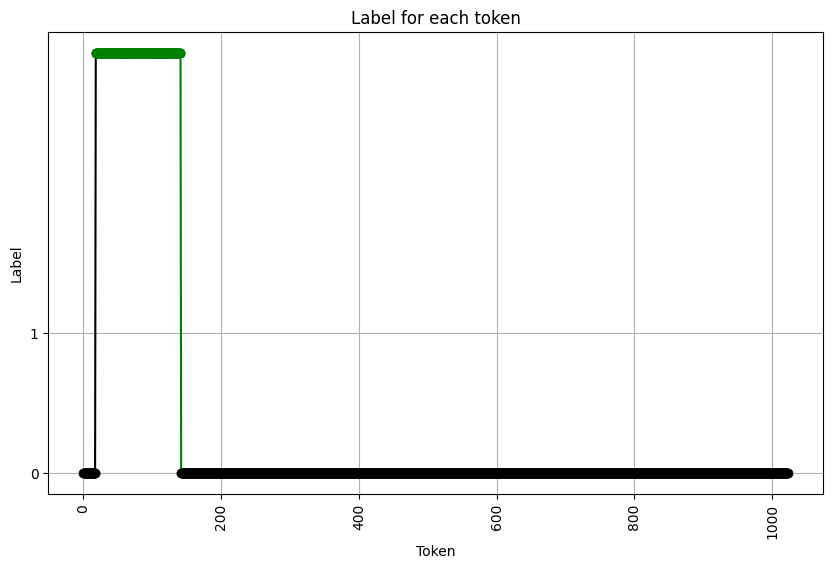

 59%|█████████████████████████████████████████████████████████████████████████████████                                                         | 27/46 [01:19<00:45,  2.39s/it]

MGLREYLAVKLKHAKEQSMVKVDGNTITINGDTVVNGDIIGRDLSISANGDKILINGKEVYTTSDKNIIVVIHGNTGSINTTSGDVKVYGTAGNVKTVSGDVRIETGSLADVTTVSGDVVAETIEGNVRTVTGDVSHRR*


lcl|ON602752.1_cds_UVX31228.1_36 [locus_tag=A1b_00036] [protein=tail protein] [protein_id=UVX31228.1] [location=22532..24898] [gbkey=CDS]


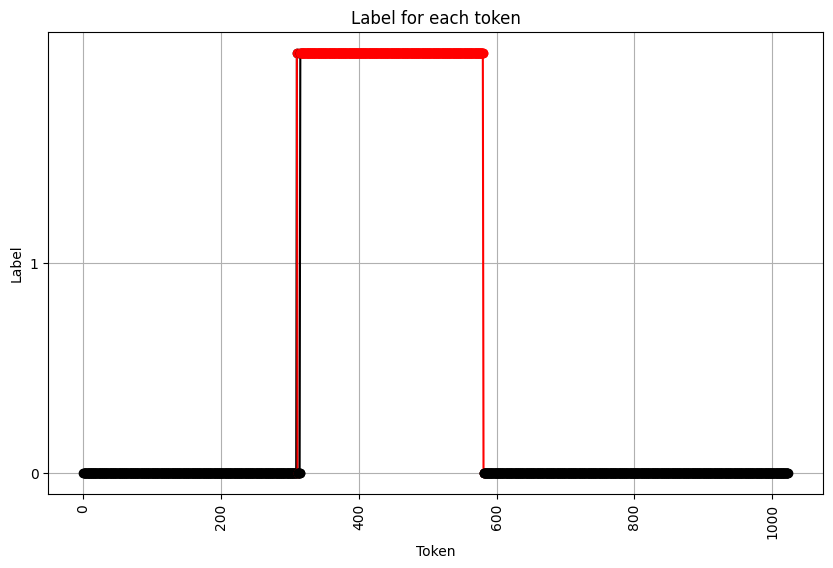

MAQTPIRALEGTIQSLLQGVSQQVPRERQPGQLGEQLNMLSDPVSGIRRRPPAEVRINPGIPGFNLDSLFVEYVERGTDGRHLLINTDTGNWWLLSKDTQVIVNSGQDDYFKASLGQTSLQTTSIAGLTYILNTEKAPTITRDNGDKIDPATTGFFYVKTSAFQKRWTVTVTTGGVDYTAFYNAPAAGTTAGNAEEVSAAYVIEQLRLELINQGFPAANVSTRGAYMFFFGMTNCVVGTDAGDTYAIVSNQSKVTLESDLPAQLPAEADGAMCQVGQASSEAAWYKYDFASRTWSETGAYGSISSIGNMPRELAADDQILVRAWEGRLSGNDDNNEDPGFVVNGYITGIAAFQGRLVLLSGSTVDMSASGLFQRMYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVIFANSMQAVIPGSVVLTPTNASISITSTFECDSRVTPIMAGQTVIYPSRRNSSYASVLELIPSPYTSSQYTTVDSTVHLPRYIPGRIMQMQTSSVTNMAFMRYTGQRNALLVYEFMWGGGDGAKVQSAWHQWTLSYPILGVQALEDLVYVYMQGPGNALLVAAMDPREGYTLGQEYDTAYSDFPTTVTVSGGQFTVPSIFRYTNYHLSIKEELVLTYPQGTAMAATEVGLNEFLGANIVSVVRGVPDGTYVLGRRYKSAMTLTTPTLRDRNDKLVGSGHVRLLRLDVALRNSGHFDVHVTDTPRDVDWGGELSGILMNSKELVLGRTLRVDLAVVTVPCRTNADTTEIQFSTNGSQELNILDISYILRYNQRRQRI*


lcl|ON602752.1_cds_UVX31240.1_48 [locus_tag=A1b_00048] [protein=tail fiber protein] [protein_id=UVX31240.1] [location=36872..38674] [gbkey=CDS]


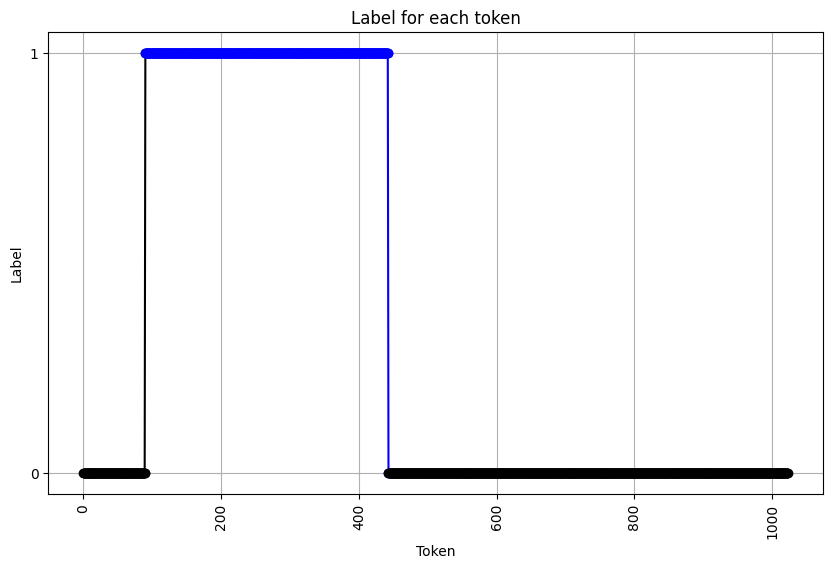

 61%|████████████████████████████████████████████████████████████████████████████████████                                                      | 28/46 [01:22<00:47,  2.63s/it]

MGLVALVGDIWSPDGIKHIGRCASVASLRTIEPTQNIQLIRTISYYEGLAPEMPRGGGDYEYDPDDTSTPDDGILTIVTTGGARWKRVLTNLSLTCFDAGVYPSGGDDTEALNNLFSTVASYRLTHGRFRLDMMGLDFTSTVGNTIEFDPNRIELVDFTIENTLYETTTAFAIVRCKPTIPFQSGIEYVKGNVDRLIIKDATRHTDSPVTALHLTSDVNGAFSSVIFNGLNIASPKNGIAFGNHCYLVTFNNAHITAYSDLTDAITAGLETTITDAGENYVFNAPVFSGTQIFNWDNIEGEFNVYGGSGDFIKGGINKRSGFVLGWYGGHFEFNNVYEKWFESSAVATVIFKPSRVLSVSGSATDFFYDSSSSGNSLKVDLDIGSWGGNTVGAMINTMLRSDRCASIQGFQPPVRGRLNRYLVDGTFKESSIMDGWYADANASRTSRLVSDTTTLTRGTTTNGNGNTVGCLTMTKLSTVGSGFPSGSHLICKVPRGDTPAHVKFKYTAPADTPITVTVRLVSIISIDGNGVPTFGKRVITAAATTLTASTTEKEYVSSVGLNVDSDYQRYDYVQVSISMFSAAANSAPVSIYDVLINKIG*


lcl|ON602757.1_cds_UVX31465.1_12 [locus_tag=A1e_00012] [protein=tail fiber protein] [protein_id=UVX31465.1] [location=complement(6743..8497)] [gbkey=CDS]


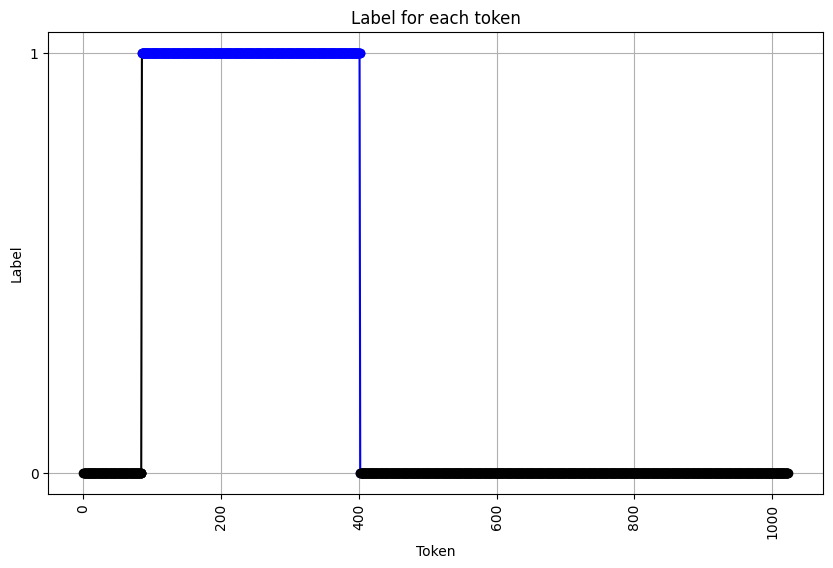

MALTKLVAVQSPTGNQRDCANIAALRAFTCSHVGQEVTLREHTSGQGSGGGVWYCHALTAGSAVDDNGCQIINNAGQVLRRRDLKELTSSYFGLKAGDIIDPVLDNMYKASRTFNIYEAKIENPGFDKGYLLTGGKRYYCGDKPFYILSYSIGTLRGPNIWHTGDNVGITFSRFKTDGTSEQAWSGGGIRGFRIWGAASYLVQGNEGVNAAPVRLSDMWQGEACDLWVTGYTGNTNGAVVSLYNEYAWTEGAIVENIMVRQSLRGLTFLRNHGTTATDSFFRVVADISFNAGVSGKATQVMVVGDGTAAGACLVYGHDIKLTQWMSAGSWHDIVRLEDYSIIAETGVIKIVADGYGISKTTVPSTEVVHSINVRGLNARFRSRVENWSNQAGGWGLDFLNIIFQSSMYTNAMTFYESDFDALPTINPVGMKIRYNGTFTVAERQSGKVYTLNGLIPGTTLKVKLTSRNGGDLNDAVVQEWKVFVRSTNLPCIVVPMSGSANIATTDGLAVTNISPVQTATFLKTVTPTQARNFIGQNYGLTVKNANDDNSLSYAVNSGRKIRFILPANPGATTTSPYSVEIEVL*


lcl|ON602757.1_cds_UVX31477.1_24 [locus_tag=A1e_00024] [protein=tail protein] [protein_id=UVX31477.1] [location=complement(20454..22814)] [gbkey=CDS]


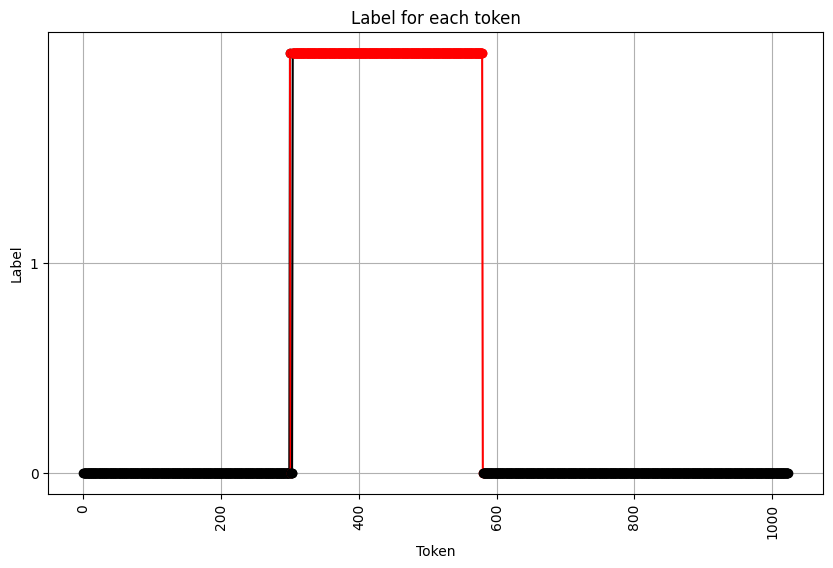

 63%|███████████████████████████████████████████████████████████████████████████████████████                                                   | 29/46 [01:26<00:48,  2.87s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGYYTAPAAGTTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGMEYRGAYSDLQKQVQVQDGVFTVPAVLRPVGWADRYREEIILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILLDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602745.1_cds_UVX30692.1_36 [locus_tag=S11a_00036] [protein=tail fiber protein] [protein_id=UVX30692.1] [location=complement(19886..21787)] [gbkey=CDS]


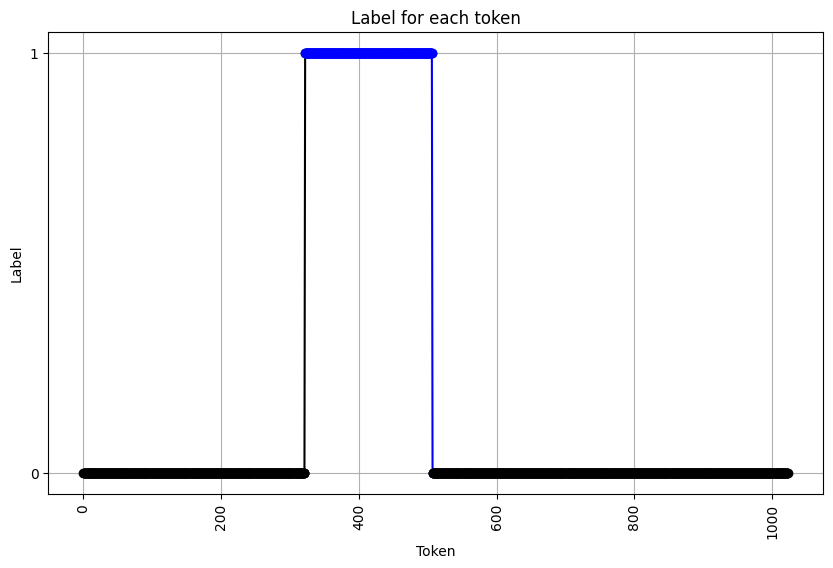

 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                | 30/46 [01:27<00:41,  2.61s/it]

MSSGCGDVLSLEDLKTAKKHQTFEAEVITGRAGGVSSGAEIDFATNQVTGQVQKTLPAILRDMGFNPAAFDFTTGGTITARDTVVYNPADNNWYSWAGALPHVVTPGANPLLDANWKPRTDQLLRQELSSETGALMVHRNNSPLDRIIRASLFEYLTESDQQALLTTAGAVVAADYALKAAIAAGVMILDIPWNLGIIELGSDPATLPLGFSLIGWGCRRPYTIAGDSSFINCGVVIRVAAGASFPFYSTGRHVFRDIVFDGRDKTTYLFYSADTSAQFNGTRLEGCGIYRFAVGVGWSRYMGTVKAFFCSISGNVDGVRNLIDSMMIACTINANDRGVALTGGANNNFFGGCRNEWNSGDNWYAFQSVENQISGELCDRAGRGGVVAAGQSSWILNGVNVRRSGANQPVGNDYSANFIIIDDGKIELSGVRTGVGANDSGDGGTTSPSFNISVLGSGGGSLLVSGSDMTGFVTSAINQKATTLNKSITGNLGMDDDVNIGMTQVVKGRRIIGSQSSGTLAGSAGATLSLTKTNISQNAYDTYVTRTVLIECRIGSSALGDDIKIPVRIRREGSYYIDVITAGIVASSGRIGISGTGVTVALSIDSATGLITVLLTNVDGQARTVNVSMLPSM*


lcl|ON602732.1_cds_UVX29661.1_2 [locus_tag=A1a_00002] [protein=tail protein] [protein_id=UVX29661.1] [location=562..2943] [gbkey=CDS]


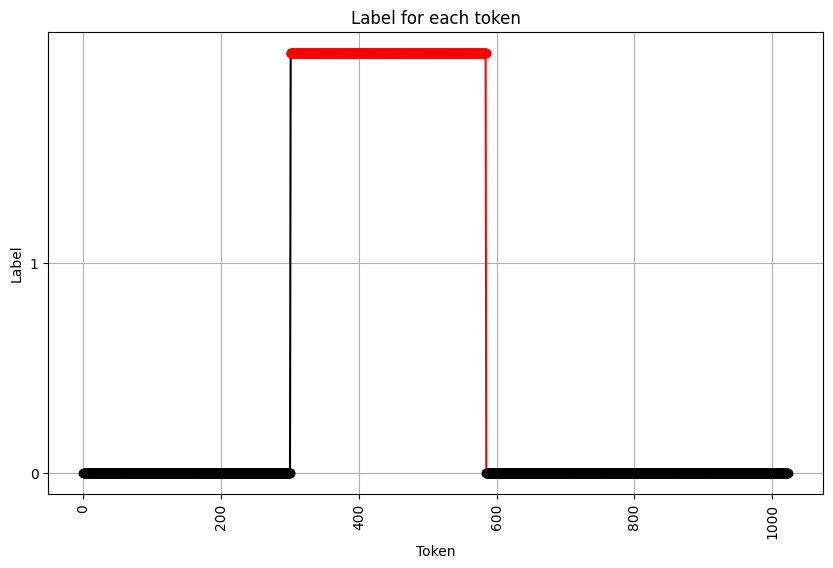

MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPPAEIVWESSIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTIVNSGNDPYFVTTVGQTSIQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYIKTVAFQKRWEITVSWTGGSVVGYYNAPDASNGSSSAEWVSAPYVVNALINGDPNGSGIGAAITAAGGSVSSFEGYMYISGLPNLVVSTSAGDTYAVASGQSRVPQEQDLPAQLPSQANGTMCRVGTASSETAWYQFDYSARTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNQNPGFVENGYIAGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTSSQYATQDATVHLPRYIPGRVLQMQNSSVTNMAFVRMSGQRKNLLVYEFMWGGQDGGKVQAAWHQWTFPYNILGVQALEDEVFLYLQGPSPGNKLLILSMDPREGYNLGSEYTDAYSDLQTQVTVSGGVFTVPAALRPVGWADTYKEDLILTYPANSPMGPTEVGLKDIAGTNQLSVVRGVPDGQYILGRRYNSTFTLTTPVLRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVHVTDTPRDVDWSGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRI*


lcl|ON602732.1_cds_UVX29673.1_14 [locus_tag=A1a_00014] [protein=hypothetical protein] [protein_id=UVX29673.1] [location=14914..16896] [gbkey=CDS]


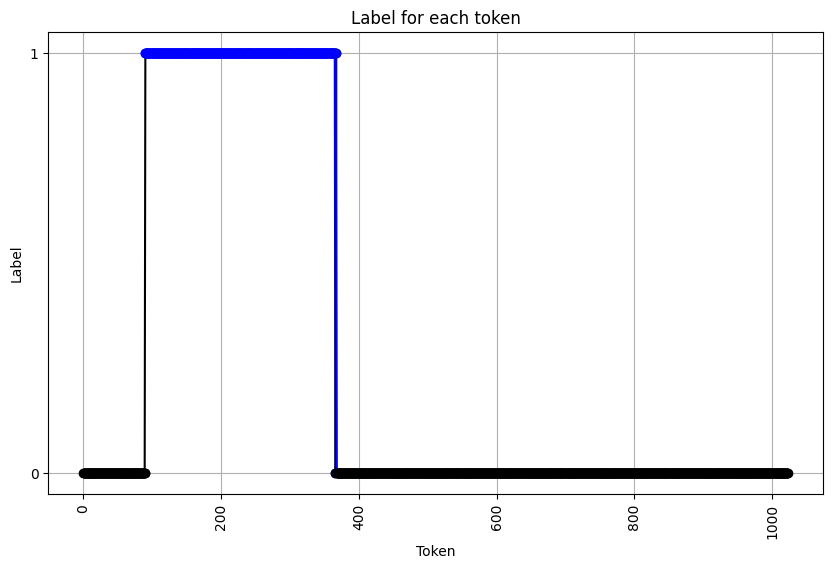

 70%|████████████████████████████████████████████████████████████████████████████████████████████████                                          | 32/46 [01:31<00:31,  2.24s/it]

MALVNLVTVNPRDLTHVQSYAELTTTVPKAAGERIVLLQYAPGLAPTYTQYVAKAKDGAVDNGGTVCVPAVGDFQWVLVTEDGEVGPNHAEAVRPEWFGADPTGQLNSAPAFKRTFAAYSKVVLSGGTYLYSDLTPIDKGSFTILGRGSRINLVDGAQFFVCTGTVGRIWVEHLYLSGGKSFFDFRAATANSFNDVRGFYDLNLADYTEVAIRYTDRDCPWWSVDKCVFAARTNEGTIGLWDNGSDNNVVRDCKFYKNQYHISAKLGSGTYKIETCDFGQFFTTGDGVNRANIWIRVPTTAPTPTGVTGMFLVRDNKFGNENERSSDVKLLLANESSSMPVYGSYSGALPAVHFVFGGNYSTGYGNYPAHWMRSVGGWLPQTFTFEGDNIQYADISKGKYFCFMDNVTRSTPYSILFNRKAARDSQLLWRGAVSNDPLVSFTLTDPSASILAGDPLVHSPYSAGVGSGTIDITKNKMPSVTYAGVGMTIAASADFLGRSEAVRGNYTQRFNNIFQSLETVTAYQPGFIQGEAKLADDAAFDSAVYLIDYAQDAADQVVYNQFPIQLRKGVWTSYCFPVMFMPNKANHCLVFKPNTQDTTSYPNSVVWSRSRAYLGKTPGLVGVQRLGSLILNEVPLAATGLPVGSVWVDAAAGNVLKIVT*


lcl|ON602751.1_cds_UVX31118.1_20 [locus_tag=P4b_00023] [protein=tail protein] [protein_id=UVX31118.1] [location=complement(27849..30365)] [gbkey=CDS]


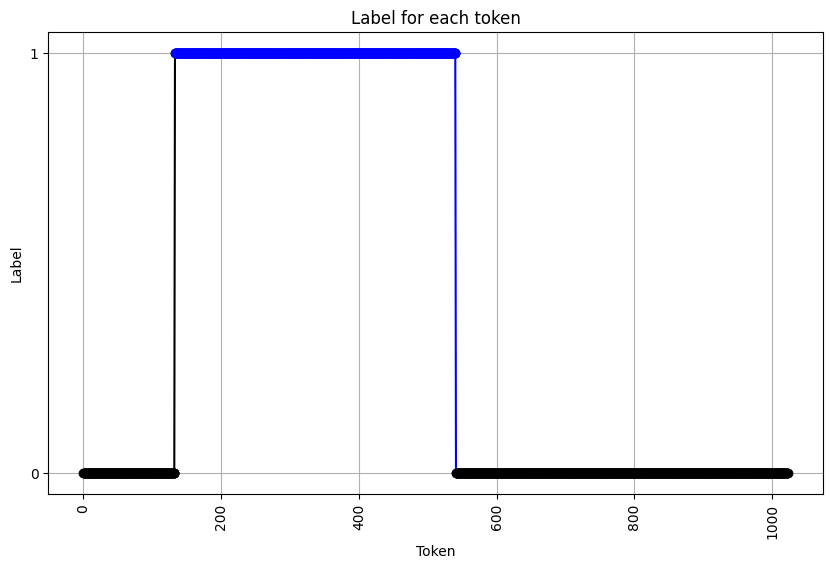

MNKMFTQPSGPVAKQTNKQAIARVNSIKQSEVCILNTLTAVDSYKILYDTATQTSWFRGEASGIPTSWTVSGNSLTLVTSSGEFVLQLADLRQNLASIEDGMGSYMVGAARNPLAAAISTAISVATALSSISVSIWEFRNHVTDRPDEEDQNTWDWSPAIEAAFNSIGTYLPYTMGTNTRHASATLLFPPGYYRCSEQVLADFSSYSGYVYGRPRLTITGYGASIGCGVEQDFTWKVIGTLLNMSGLDFVTDPTVNYSYAMKLGDETKTTSNYAVTGVLRDIRGFNLTKFVTFGWAFDMRIEGPYATGFKQDPAATEPATYFEILEHVSDNCNHLVFIRPQGETANTKNFEYFRINGNSHLSTHHNIHMFGGHFESHQYGIKFVNAVKNASGRPAVHQCSFNGVVFLENGSGDAALDALTPAASTHMLELDQASSIELNCCRVATTNTTTETFDSSKHKALIKYSGSALSLVIRGGYFVTAFASVAGSNQNRYTLIDISEHSAGKRAVEFAGRYSMNNFSTAHSTGRVLSGWVSGNRKWIEEVSDDGLEYSWSYSTSSDLTGTPTKIFSVDSTGTFSINGIKVSTFDASSVLRIGYNNTTPGQRSINFYGAGTTDLTGQVYGNSAGSITVTSTNNIFLSPNGGSGETMYTGNLKPNATGSYSLGTSSFYPNNIYSQNAVTVVCDVNYKANVKVLSEEEEYQTLISAVGSVPFSAWQLKSAIAEKGVDSARWHVGVIAQQVKSAITDAGLDWTKYGLITYESFSQIVSKGDDGYYYPVVDEEEASKIPVNASGYIDAIDGADSVITADDGTITYTREIYMLRMEEFFTLRMAHIESKLS*


lcl|ON602751.1_cds_UVX31120.1_22 [locus_tag=P4b_00025] [protein=tail protein] [protein_id=UVX31120.1] [location=complement(30645..33209)] [gbkey=CDS]


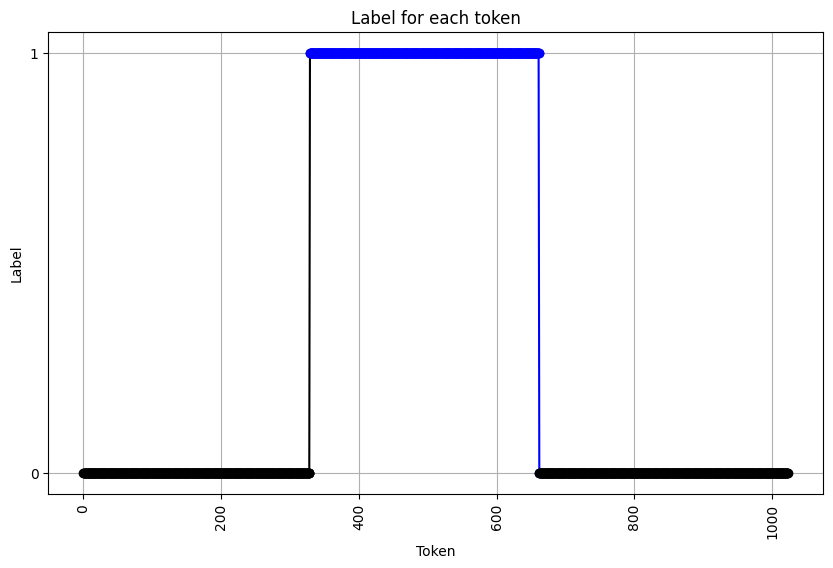

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                       | 33/46 [01:35<00:34,  2.64s/it]

MNSHNPFNTGGSGCTNDFRSGDQLVDRIIGDAYHVVKEVYLALGNLSYIYNYLQKYGLIITVDSEGAIKDIPLSIGKFARVYSKSDTVGYYFTDYLYVEDDTTGIPPNDPTATGSWISTKATGSNASFVRIWKYRAVTDGETVIQLPTDMPIVDVQTIYVQGIRQDIDEGFTYNEGDATITLADELEAGNLVTVIIGITDPDLDIDIFAVLKGTDGASNIGTATGDTVEARLASLDLKVDPTLRQNLGSGEGFKLIGQFNSVDELRNYVPLVAGESVLVKSYHPGWAAVSDSPCGGGEFYYDANDTSSADDGVFTFVTAGGHRLKRKGLNGVVSLAQAGAPVDGTSNADEAFARLHNAILARTDLWQVDGENLTYVRTTPLLQDISRYSVNNMYLMYTGVTDFGPDNPFYAWKPSDSIGTSKRTFTRKMKNVTFHGPGYRIDTNIHALLLHMQTESETLRQMKFENVNVRDFNKGHVYGDHAYLITFENCNIWRCYAGLSDREIVEGASLTDSGENIRYAECLLDSLHQCANLGTQELNITFDTTSFDYTGRTSTESFIQWIIGGTHEITLRDCFIESGNVNAGWYNYGFYTTAAANIRIIRGIIRLVSTTYNTCPSFFYDASGLASFEIDGTTINGWGVKKWANTGLRKFRPTLKGLTSQFTLYTTDDPILWNPTKVNNLDYQVRALTTSTYTNKYTNERIKVEPSSITKEDGTVIPTLLVTKLAGYGQFADFIVKVRKPVKADHNASMHGKITFVPGTAMSSARVITAITGCCTPGKVNNVGVMSEFASTTITSTQLSLLDSVNWYDINASWGANKSASFLTFEEDMIRLDLSNLALGDAIHVHSLQWFGAF*


lcl|ON602759.1_cds_UVX31607.1_21 [locus_tag=S13e_00021] [protein=tail fiber protein] [protein_id=UVX31607.1] [location=14101..16419] [gbkey=CD

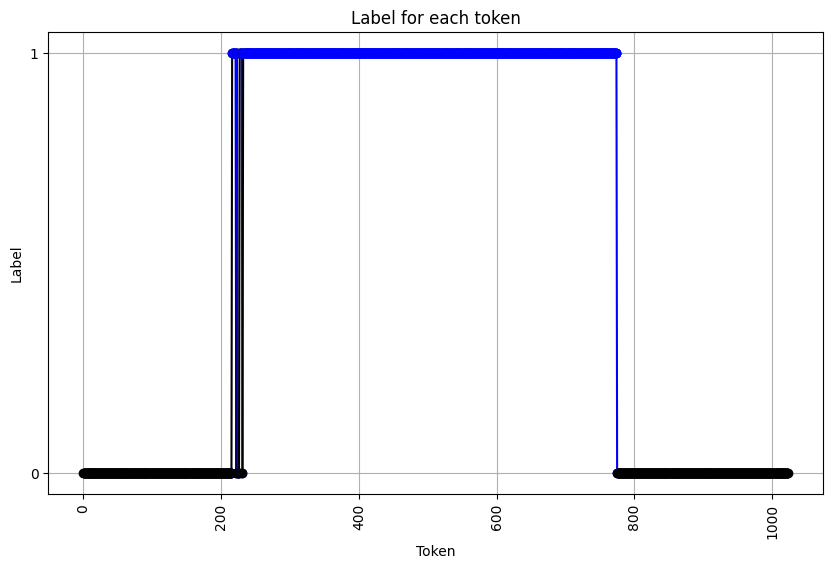

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 34/46 [01:37<00:29,  2.46s/it]

MATTPTNKPIPSEDPRDLKFNAGKIDEEVNGSADYYTDRFGVQRLTNTGRSNQFYSAQLDRANRFEQFLLSSGYVFLGDYEDGPFQFSERNQYIRYNNQYYRLNASTDVGFTTTGTDATSFANDVTHFVLMDGDTLRQNLGSGDGFKLVGQVPSFEALKSIQPYSGQRILIAGFYSGETKGNGEFVGVAGSAEDVPGQIAVVNANWYWKRITQVVKTSDCGLRKSLRANVTAQSGELFDVSDDLQKIISYANKNHLEFMADDTWDPSNPGFEAEGYYITKGIAFDLLTSSNVSGNKYVRTGMKRISGNLVLLLNSNNFTGISTPEGPFAVTHRCGTFNSEGKYYFGTLNTSCVSDNITVRDCSTSNGNPGRAVELSGILWMTLGFNYKQLTAYGFNGHSVRNFSYDGIAQSTRGEQGGNINKFSIYSSTYPYADKADESNAITFTELFAHNSFEKSWYIAGTKTSVDRFHDEALTCTIDSPPNPFGIESRNGYGYTSAYFSSIGGNLGTGTFSSFKDTTVTPVITIGIVSNTANTIYCGGARVSIISGDPGPQGGSIGTISNIGGETRIVSGARVTIGYSRSATLLLLDPDSRVMGGGATSATTCYGKLERFSAGALTVNTGGVVEDGSCTALSAYSTGISAFNINRLRVNGNAYLSSLNYRSFLKNSWVTGDLTLANNSYLDIENNTIHNMPAGSNTGMNVNMKGGVYDTAVITSGFMLDPVPSFNVSLGGFTAPVSGTTSGAIGRKTTNPNTGVTYMCLGGTVWKTLTYS*


lcl|ON602760.1_cds_UVX31720.1_56 [locus_tag=S13d_00057] [protein=tail fiber protein] [protein_id=UVX31720.1] [location=29391..32099] [gbkey=CDS]


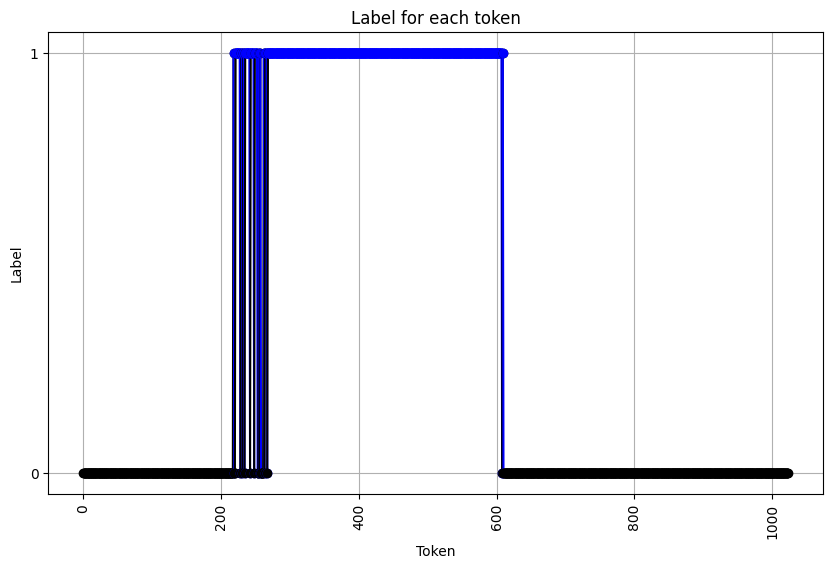

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 36/46 [01:39<00:18,  1.82s/it]

MATTPTNKPIPSEDPRDLKFNAGKIDEEVNGSADYYTDRFGAQRLTNTGRNNQFQTAQDEREAEFVASQENKELRFQQFLLNSGYQFLGDYENGPYTIDAINQVIRYQGEFWRLNASTTPPYTTTGVNSSSWAVDVTHLVSVGDAVLRQELSKVITWLDLNSFDDLDKTGATSVTSQLSTIFANAYAQGIRKVVDTTPGNPVYRIGGSEDFVIPGLTFEMENSEFIYDVNWTGQLVITDPSTPVTVYDSSTTEGAALLSKINGSSSQSKLAQSMQIDGLVDDTTLNNNVCVFDSGIGAYYSRGNIRTWKHIALISTRGLMSDALYYSLTGTVSSVTAWQVKPNTTIIKLPKFNFEEKPHAVNVLLKGLSRYEIWGPNVSKRPLIDDGSEYVISMVNCFDCEVRWGYDIHPNVALNGSGQLAYSSYTLNYNFCLDCRFINQYSMGFGWGSTAGEVCSNTTFINCKLNRFDFHEPMQGRTSLIDCTAGDKGISMCGMGRLDVIRCDLKPETLNAPYPPTETTMIKTRDDIGGWFDGDIYIENSIVSGGFTYNDNNAIPSYFIGGMINMSSTNPAGDILPPGSPVVPRLFRDVTIKGFKHLRRYTGERYSRFIYSNLPQYLKHPESITLDDFDYFCDQPLVFGFGNWLDTYYTDDTTSPPMAIDTTCHVTINRGAFAGLTFAGTGNKQNISVKINQVRDLRYGKKGVAIVASTRGVYDISDSDITSLSAVFGSSQPTVPNVIKVTGGTFKVFNSAIMPMTANDTVYHDVSAANVAFLGDFSASTITATNLNLAKWFKLSGCQFFTTTGAKVPYMKLFSGSIGTTPVSVSVPIRNGNDIVTQSVYNSLTTNDTFKISSLSGNLGRKLYNGADGGYFLNISITGNRALINSATASAAAMLREIYLAA*


lcl|ON602743.1_cds_UVX30533.1_9 [locus_tag=A1h_00009] [protein=tail protein] [protein_id=UVX30

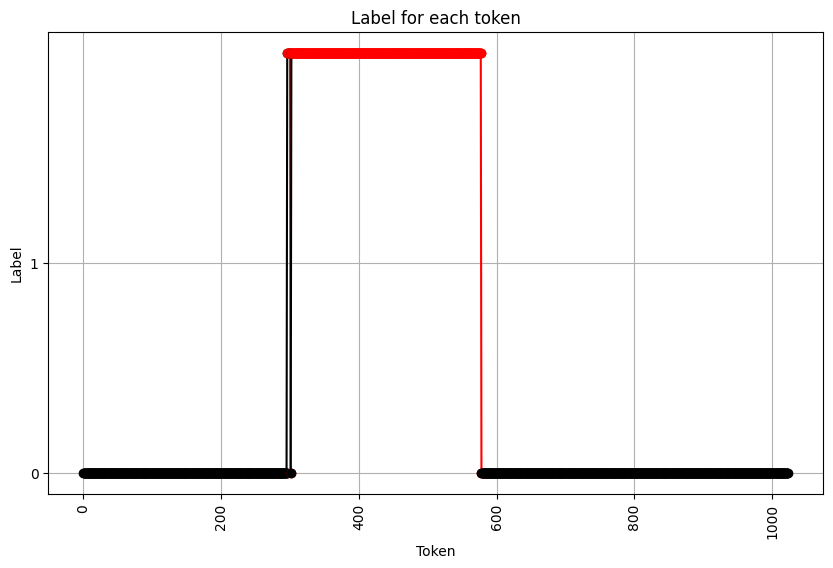

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTVVNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYNTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTDGSMELNVLDISYILRYNQRRRRI*


lcl|ON602743.1_cds_UVX30537.1_13 [locus_tag=A1h_00013] [protein=tail fiber protein] [protein_id=UVX30537.1] [location=16665..19211] [gbkey=CDS]


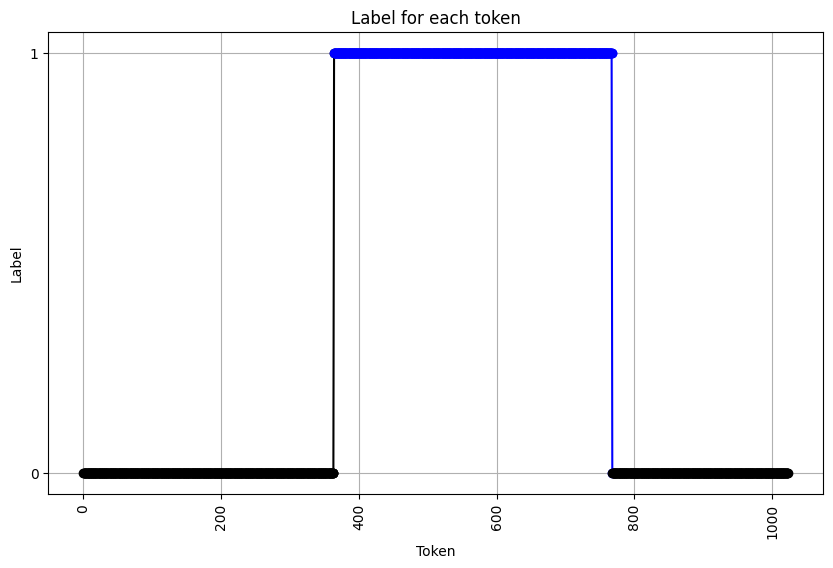

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNTQFLHLAQELVEGRSIEGFYGDINMHRYRITNLGDPVDARDAANKQYVDAGDARLDQRIDAEHAAWVAAVANEAAIRKSADDALDVRTTNLEQTYFNANTNSFPWWTVLTADTDTVTPGMPFTKAKVRVNGVTQTAGYSYTVNAGVVKFAEVLPAGTLVDMTIGIDTEADTSAVSTILGMLSDQTLPGTSLVRHSSGYNVAQLLSYNVPEAASVAELRTRVGSPGWRIKLREYSAGAGPQTGGELAWVSNTTYVDDGVVFFRVNSSGGWIRNWSNGINAEWAGPIVEVPDASPALNRISVALKTFNAEVKLPAGNIYVGDTWWISTGQLKVTGCGSNTWLIGRPTDSSGATTNSPIMRCSDTRWDSVTVNGQYRMQDIDLRDFCIAGKNYPLNPTTQSFGQSSRDGLFLGGIGWDFQVQRIWFYNLGRRAVVAEDLWDGDFLECKFHEIGVDKTFAPGDLAPQAMAFKRKVDSCNAVRITSCHFEHCYRGAISIQDLCYSFFLSGNKFEAQNQNADYPAEYVIYVGNNHRNFVWEGGMAVVTQQRNYLHYARIWGDATTVRDVKFTYPNNNGGAALLDLSYGNYQVGATISISGDVRGDLVDASGNPVAPILSRTGRNDFSGTQLKVYNPGLVFSLASSANSDDVSKVRILGIGTAVSQPIVHVANAIHRINGLRYSGVAYTSLHDATTKADREEYAMLYNLSTTVTFNIGDIVASSSLAPAAATGENSGAGAAVAGNWVCMGYCPPNKVSLFKRIS*


lcl|ON602743.1_cds_UVX30545.1_21 [locus_tag=A1h_00021] [protein=tail protein] [protein_id=UVX30545.1] [location=23181..24914] [gbkey=CDS]


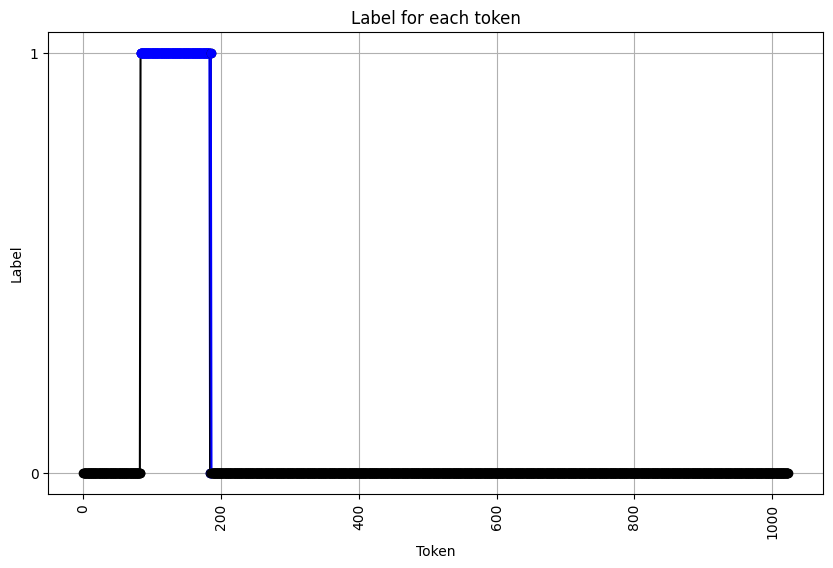

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 38/46 [01:43<00:16,  2.02s/it]

MALVDLVRAGGYSIEYPQFSSMAKLKAFPHSEDGQLVRLLSWHEGVGLGGGLFKVSTSSTATGNDGTVVVASNGVRLLRVVNGPIWADMFGALPNSDIDSMPAVAAAYAYAASVNTDLYIGVATYKFKGSTPINIDPSRAGIIGYQGKVRIDCSEFTGSVVFSINSSYSYTPAAYYNNLSPALQGLYVFGAKTSGVDGLLVGRETVGSDKSYNGQTEVRECTFDKFDRNIRMGHNSWRFVFYKVNSLNALNPNGILYVPAGLDDSGEILSFYHCQFFDGAGSNIRLSCSSYTMVFNTCSFLNITFFVDSASSATVTCNGCNFENPGSASTRRYVDISAGHTNVFNIIGGSIVTNSNPGQTQALLYVSTNNLLNLVGVTVPYGGHYQQEQELGYHAFIGGAGTVTTSGVMLQLLNGAGTCPLHSSLSTFSNWDFGYGNLNAWTVDKGAGTSSVVEYLANAGPKGTEGAMRVAPVSVGTNVSQVQAVTNPGMFSMSCMVNIATTSGNAGQISIGFLDAAGNSLPGGVSANLGTTTGWKVIGKNTLRGKVPIGAKQIRVNIQTVAGADVKYAYLLCNVVK*


lcl|ON602739.1_cds_UVX30300.1_14 [locus_tag=A1k_00014] [protein=tail fiber protein] [protein_id=UVX30300.1] [location=complement(7073..9415)] [gbkey=CDS]


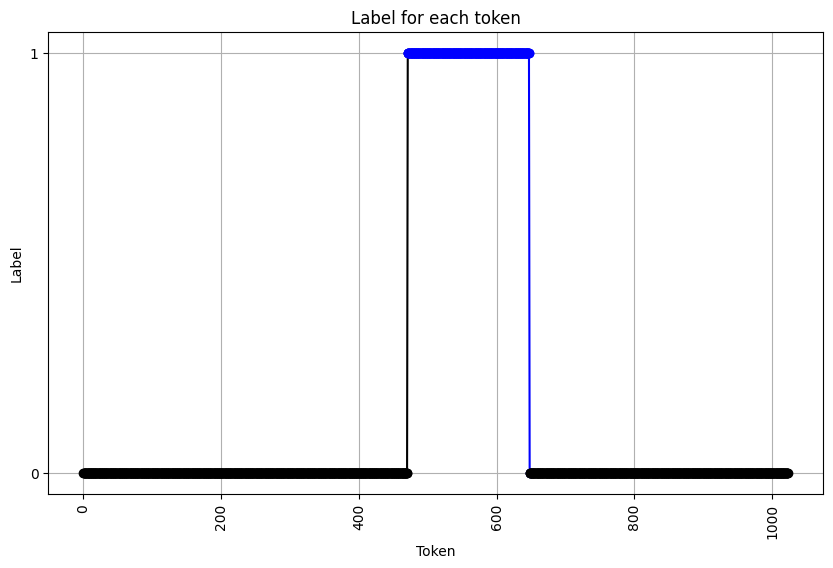

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSAETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNMQLLHLAQELVEGRYIEGFYGDINMHRYRITYVGDPVDALDAANKQYVDGGDARLDQRIDAEHAAWMAGDAALDSRVVNLEQTYFGANTNSFPWWTILTSDTDTVTPGMPFTKAKVRVNGLTKTAGYSYTVNSGVVKFTEVLPAGTLVDMTIGIDTEADTSAVSSILELLTAPSGASLISSGNAPVSVLLRRSIFEFMSAGDRTLITGTVGTEVLVDYALAAAVAAGVTELYFPPAPGIYVVGQTPVTLPAGFSITGVAAKPYTASSDASFNSRGTVIRLASGATAPFILTSRHRFLNVILDGRNSSVNLMKGVGSDQTQYCRFDSCGIYRWLNGIGGSSSSGYTATVQVIGCALASNYRGVRNVIDSRFTDCTINANTYNGVELNAGANNNSFLNVRNEWNGAHNYFASGAKRNVVCGELCDRAGLSGFVAVNGGQWVVCGVTVQRSGKNAVVGSVDDAHFQLAGGSSSIIINGVDTLAGANDDGSGTSTPSYTLSTSGANSDEKTFIATGSRLGGFTGTSWLRSGVVKNLSVLGCAGIPDVKNFGFSQSEDGATRLGDKVSSLALSGAGSTATLTFAVSSDGARSQYSEPIVRKLEITARNNTNTGSVSRFYADLIISRESATAAVAVDASSVKTHSTLSGGTWGLAGASPTGVSVTPTISSDGSTLTVTLTAVDGAPRLIWAQLRG*


lcl|ON602739.1_cds_UVX30304.1_18 [locus_tag=A1k_00018] [protein=tail protein] [protein_id=UVX30304.1] [location=complement(16456..18816)] [gbkey=CDS]


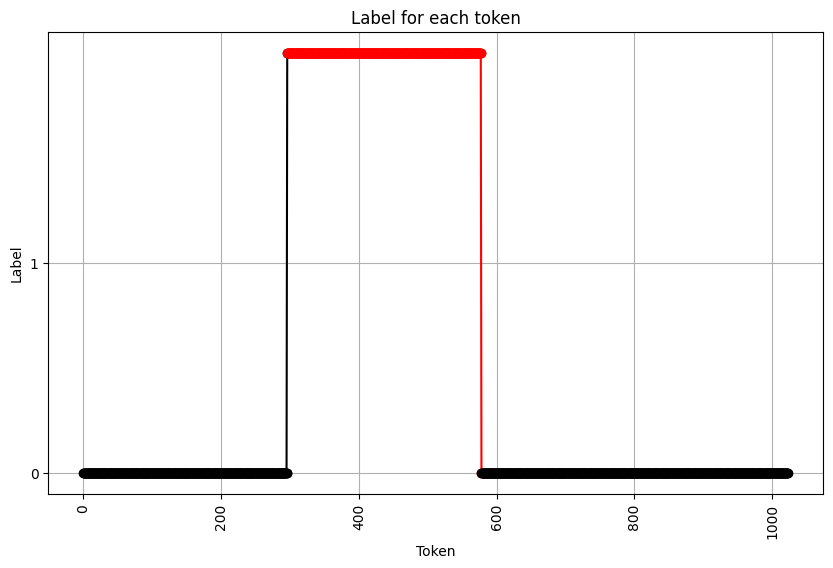

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 39/46 [01:47<00:16,  2.30s/it]

MATSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTVVNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYSAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602735.1_cds_UVX29830.1_7 [locus_tag=D7c_00007] [protein=tail fiber protein] [protein_id=UVX29830.1] [location=6265..8493] [gbkey=CDS]


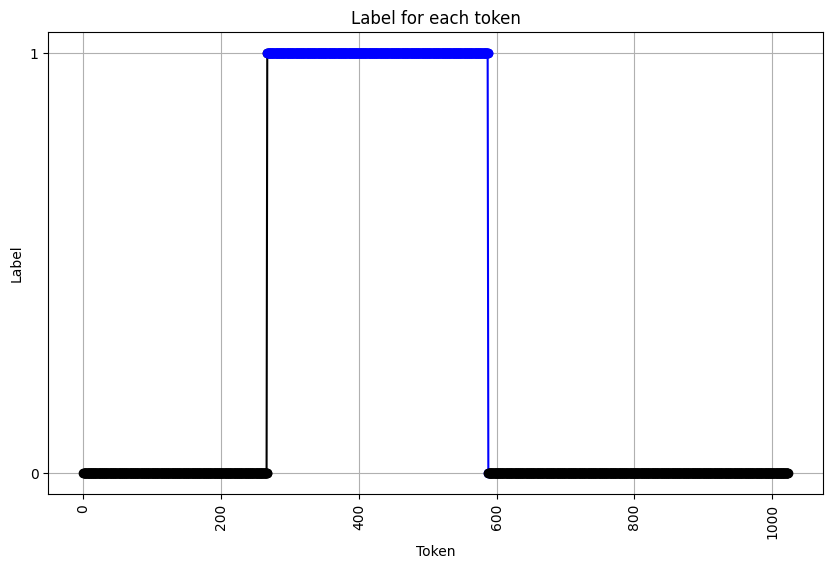

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 40/46 [01:48<00:12,  2.16s/it]

MALYREGKAAMAADGTVTGTGTKWQSSLSLIRPGATIMFLSSPIQMAVVNKVVSDTEIKAITTNGAVVASTDYAILLSDSLTVDGLAQDVAETLRYYQSQEAVIADAIEFFKTFDFESLQTLANQVRADSEAADASATAAAASESAAKTSETNAKASEMAAETAIDQVQQIINNAGEQSTLVVLAQTNGFKSIGQVESFNALRSVVPSYAGQRILLASHYEGWNALAHAPFGGGEFVARSGAAVDDGGYTCVPTGQTAFYWQRIPKNPGKVCATEFGLYDGAALDSILTNAINYCIKNSLGYLSIPALGPAGYTIAGGLEFINSTNGLVIEGPGMGGKGAAPVITHTGANIAMTFKRASQAQALFNTVLLKNFSIVGNALATAFVRFSDFYGGSVFDAMIRDYTIGTAIDVYNDKGWTEVIRVDNVVVRTSKRGIWFHSNPASTDWQTVSFYGAKISNFAFQHGIAGASEGIYVGDGSREDNLYNCDIDMMGWWEGGGDSTAIYVADKARIDGAANFRYDGFAASAITSGTQPCRLVKKAGTTGYVKLNCKNYKHEASLGLTAGVTQLTVRPWLAIAEIIAGVATPHPTLPGESIVNVPGMKCKLIGKLFKGQKSVISVAGLPPFHRYKVTTRCNLSSTAQQQYIVNIPNDNNGGITTRTDSVPDVTTNTDTIINGTTAESTSKSTAKNKNFGPIYISNAGGLVDNTYSVTSKQGFQINLDGTHSNVVNDEYPVSIEIEAID*


lcl|ON602744.1_cds_UVX30633.1_56 [locus_tag=S13b_00058] [protein=tail protein] [protein_id=UVX30633.1] [location=30249..32648] [gbkey=CDS]


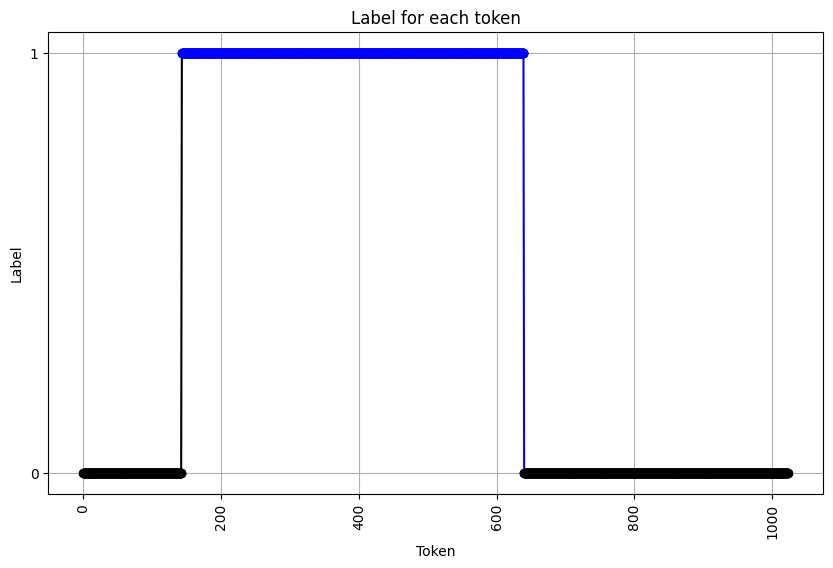

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 41/46 [01:50<00:10,  2.06s/it]

MATTPTNKPIPSEDPRDLKFNAGKIDEEVNGSADYYTDRFGVQRLTNTGRNYQFQTAQDERETEFVASQADKEARFQQFLLNSGYQFLGDYENGPYTITARNQIIRYQNEFWRLNAATNPPYTTTGINSTSWAVDVTHMVSVGDANLRQELTTLGDGKAADLIPLNQGGTIQDAISSISPLSKGGVPDNSSFDNASIIEQALASGKHVDLLGKEWFISRPIYLPNNCILENGKLSTQAASGSGFMAGSIFAPGNYHPDYWEEVPKVAVTATKGQSTLTLSDASIVSVGDIIRLSSTTGILSAGFFVAQYLQLARVLSKSGNVITIDGPVETSLTLEAANADQPSYQARFNKPLFCCRDTIVRNIEVNTWDYWTADSATYNCIFENIKGKAKGVVYGNTFCKTKFNRINIVFSGRISELAFGSHDTDLTDITAIASPSGVSENVMLGWAESGRRCTLDNFKFMFNSNANPSTIIRVSGHRDSRIKRGVIIINNNTNNILSAEQYGNAANSGPGGIGTGYRSEVENILFEDISIFAYGATAVICDTQKTADTSVLNGVEFSKIKYYGAIPSVALSRAIGTAANLTTGVKADISSDIGGSIVLTNSRYNTFKFSGPVTVPSIVAASAVNAISIISPSRLSAKANNYSLEASLSVSSTTSGNVIRDMIYPAGSLRLSDSIKIDIAGSTGGLLGTKTVQVGFIGSDSSFKYVEMAALASEEIYFDMDLDVTLLSTGSGQVSAFISGFISKGAASGASTTGSRVLAVVSDIVSSNLDLQIRAWKGNSGDGLTITKMMIKLNDLTS*


lcl|ON602729.1_cds_UVX29306.1_32 [locus_tag=M5b_00032] [protein=hypothetical protein] [protein_id=UVX29306.1] [location=15095..15502] [gbkey=CDS]


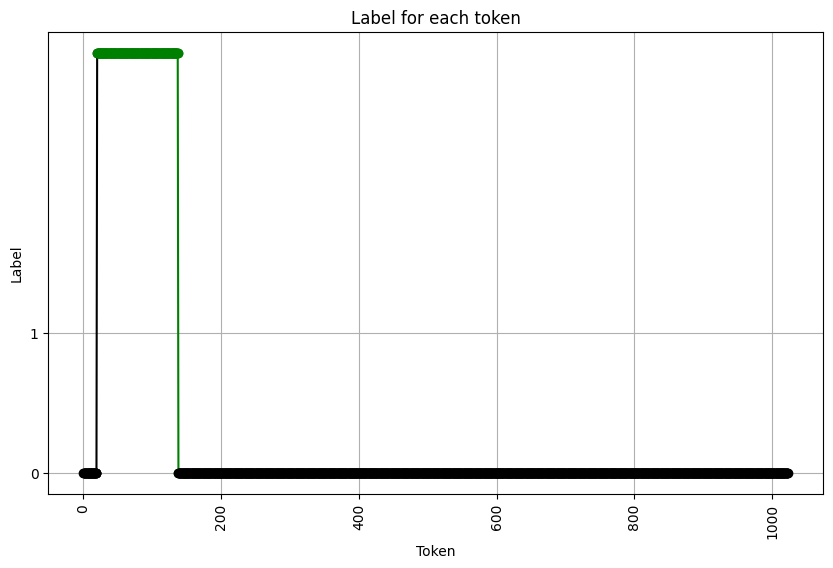

MGLREYLAVKLKHAKEQPMVNTITINGNTVVNGNIIGGDLSISANGDKILINGKEVYATSDKNITVVIHGNTGSINTTSGGVNVYGTAGNIKTVSGDVHVEKGALADVTTVSGDVIAETIEGNVRTVSGDVSHRR*


lcl|ON602729.1_cds_UVX29360.1_86 [locus_tag=M5b_00086] [protein=tail fiber protein] [protein_id=UVX29360.1] [location=complement(51837..53558)] [gbkey=CDS]


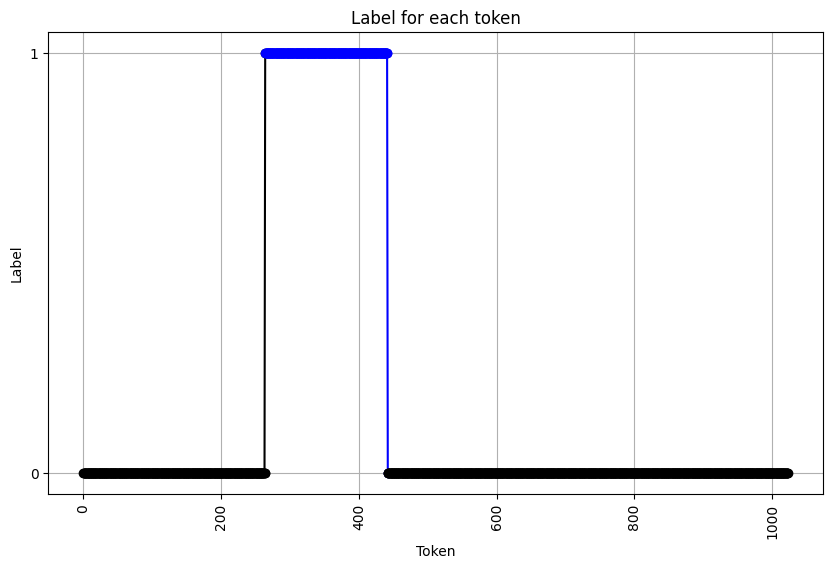

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 42/46 [01:52<00:08,  2.09s/it]

MLQSVKISELPSADTLTEDDLIVVDQPDDTKKATLFQVVSKIEESVENTTLDILSEPDGASKSYSKNSPVSLLLRRSIFEYMTEEDRDTISGTLGIEVIVDYALQNAINDGVSELHFPPVKGIYVLGQTQITLPSGFSMTGVSAKPYTASSNTSFNNRGTVLRLYSGASSIFIMTNRHRFFNIIFDGRDKSVNLMKGVGTDQTQYCRFDSCGVYRWLNGFGGSSSSGYTATLQLIGCAIASNYRGIRNLIDSRITDCNINANDTAGVELNAGANNNSFVNVRNEWNGTYNWFCSGGKRNIVVGELCDRAGTNAFAAVNGGQWIVNGVTVQRSGKNAIAGTADDAHFYIAGAGSVLILSGVYTLVGVNDDGSGNSTPSYILASDSSGTDDKTFIAAGSKLDGYSSTSYIRPGSAIAKTSILGCIGVQDTVNTGFHQVRNGRWHLGDSARNITLPAGVGSTVSMTFPATDSDFAQYSVGFSRSIEIMGRNGTTGSESRFFCKMMIKRESSSAVINPDAQRVESQVDLSGGSWGLSSSSPTGVSVSFAISTDARVITVTLTNVDGAARVVSAELLP*


lcl|ON602758.1_cds_UVX31542.1_31 [locus_tag=M12a_00031] [protein=tail protein] [protein_id=UVX31542.1] [location=complement(17974..20442)] [gbkey=CDS]


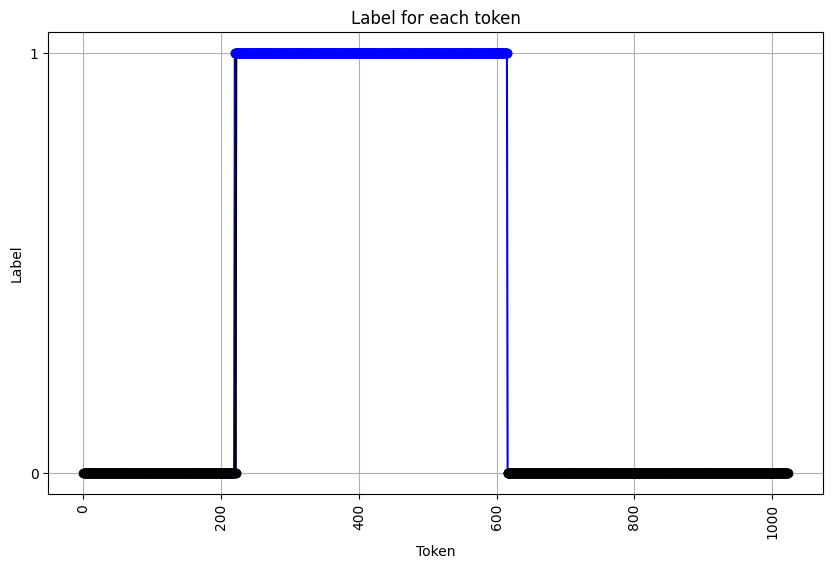

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 43/46 [01:54<00:06,  2.06s/it]

MTIIKRADLGRPLTWDELDDNFQQVDDLTAAASAAVSSAAASATTAAGSATNSLNSANSAASSADDAAASATVAINALMNSTFEPADFDFTSGGTLDSTDRNKAVYNPADNNWYSWSGTLPKIVSAGEDPTIDGNWRPRTDQILRQNLSSNDGFKLLGMCETVAELRTVEPSYPGQVIKLRRAVSGGPVLNAEMFYDDSDTSSSDNDFSVFVTPGGARWKPCFTDGINAWMAGFSESENNLAECINKIGQWYVDQSISDVQINNRKAVIYVPGLGYKTTYTMTSTVKLPPSLAELRPMCDMVFDYSASPGLDGIVCSHEYSGLTSGKGNSQNGDSADAGGAVINPIGVLYLKGPGITKSKDESGNVTSSTSSTGVGLVLGNRTRISAGAGYLNVRDAHARNVRIFGFMGGFQFGNYDTYLVTLSESNLYSNLHNHYQPNVTVANTGEGMYFDRVTLSNAGINNHYIDANGLDYWFKNTHIDYAYQDGVFFGPNAITEMVLTDCWVEGNDRYVFAQPTKTGTSGQCRILMQGGKIVPNRYGVTYRGVRPIFKSTVFNTFILELMDVDLNGGPAGYMCDDAYGTWVPYGDQTAIIARYRVSDTYKWLTRFVYGPGGYLLNSNFTFTGSAGATLPSSVSTADAASAYHWYAVTGGATVVFGDAADADSDGLIPVKITATNTSDIVYLFCANYVQFPRNGAYMKCKGSVKCAAAAGSVNVQAALRPLTYRSVVSTLNTSTNVITNTYNEVSLGTVTGDTIDVLGDILTKTYLTRTSNDYVSTPPLKIQNYFRGSLWGNPGLKFTGFTGTIYVKLPAYWFEGVHPNW*


lcl|ON602764.1_cds_UVX31929.1_22 [locus_tag=A2a_b_00022] [protein=tail fiber protein] [protein_id=UVX31929.1] [location=complement(15484..17796)] [gbkey=CDS]


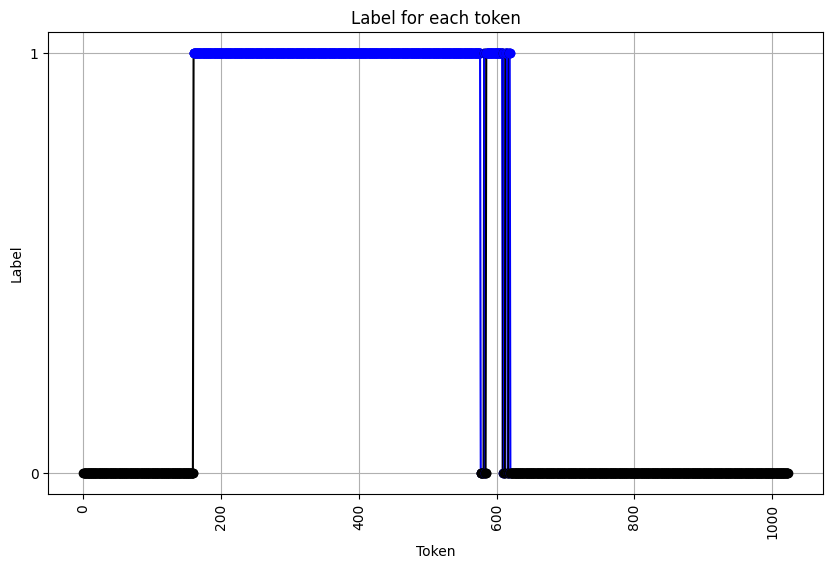

MALTKATMVSANLVRRFKADGTEGNTLADRWSRALRSSDFGIKCDGSDETAKYIAAIAECNAKKLPLLFDNDGTGTLLLSGSDNITSYYSVDFGGNKIDISQFTGKFLIERPPEYSPTTYLASSPEVQAIVTKGETLWGGVINAWASLTNLKNAYIKITTNVNAFEYRNELFPVVARNLLYRGGILAHHLDYPIFPSSIVSIQLFPVPDKVTTFGNAVVVKESDPCDFIVAKGSRLRIHDLQLNHNSQTVSTGMIWINNEECYDLELDNLTTPYGTKYMPGGTIAASYTFRVSDSYNVYMHDLHSSGGEWGTIGTDEVTNCHLERCSLSRYDSHRPFHGTLSGVDCNFGMRGLSTQGAGDKMVWSRCYFLDASSNDYTPNFALPYIFNSRGDMGGICDADAILDNCTFANNLNQTIHVFAQTVGPEFSNGLPSGSPYRQVSFRTITIINPTVKTIPGSNSSVIDFGLRESRTGADLPVTAQNSPDMPFNITLNNVKSREGGLCSFSINNTRPASASRATSVTNATTNPYEMITNLEINMTDCVWTDRDVSMAITDTTDTYSLRMNMKNVRQMSDIQPVFMRLYMPALISGTGCRIREIRPFFNSATLLKPMGFSFSNSEIYPNGTIFISWSETANNRFCNLSACNIIGDSMAALSKMAAYKLAGCQYFIIGTGKVNVPISSVLTGDTGSFLYPTWLNMDNNYQLATAQGSFPIKVPAPGSAIYMVVGFTEDGTIIKRVKVYRSTGTGGGIALTKFPTDSAAPILDAIYLP*


lcl|ON602764.1_cds_UVX31943.1_36 [locus_tag=A2a_b_00036] [protein=tail protein] [protein_id=UVX31943.1] [location=complement(31119..33503)] [gbkey=CDS]


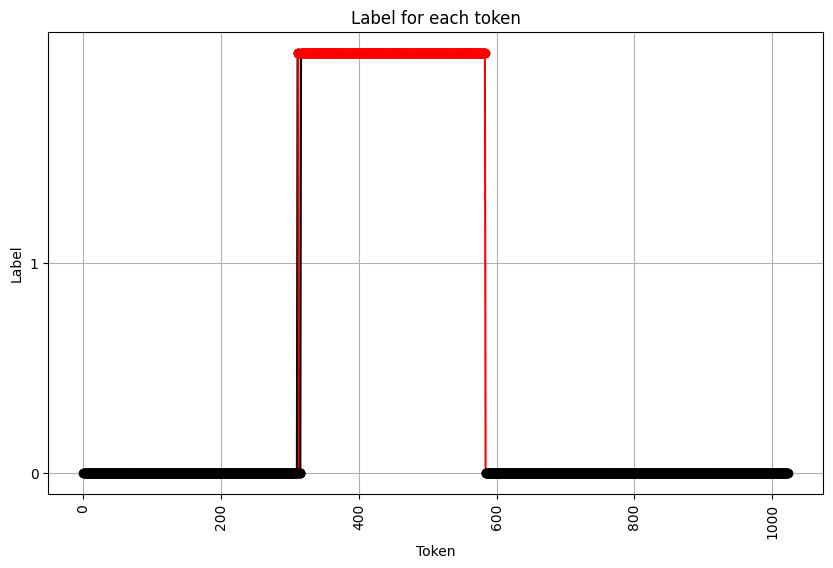

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44/46 [01:58<00:04,  2.45s/it]

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQNNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAAVYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGGSASDVETIRTEVIAEQLYTNLLTWAGVSDYTVSRLGTTIVIKRNDGANFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPVGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFEGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDSLTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYAIKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602767.1_cds_UVX32108.1_37 [locus_tag=A1i_00037] [protein=tail protein] [protein_id=UVX32108.1] [location=24618..26978] [gbkey=CDS]


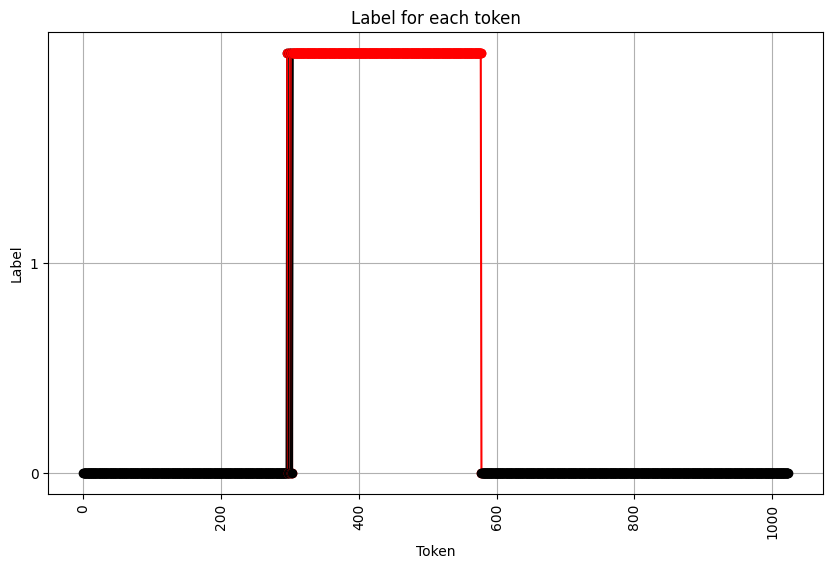

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMVPNTIVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYDSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENALRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDAPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602767.1_cds_UVX32112.1_41 [locus_tag=A1i_00041] [protein=tail fiber protein] [protein_id=UVX32112.1] [location=34020..36566] [gbkey=CDS]


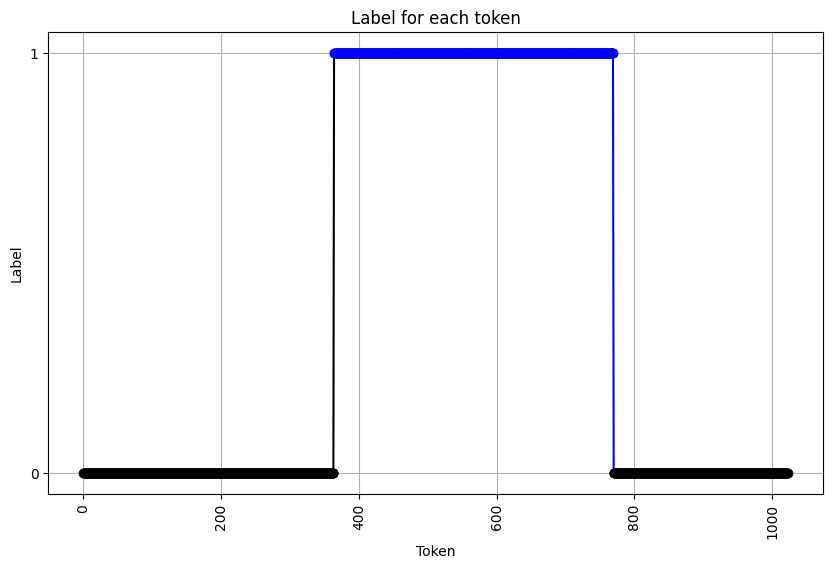

MAFSWQESVKPAGTQDIQCDIEYLDKSYIHVYLDGAETTAFTWTSSTNIRLNSPLSVETAVLLIRKTEREYLYIEFASGAPFIEGNVDTQNTQFLHLAQELVEGRSIEGFYGDINMHRYRITNLGDPVDARDAANKQYVDAGDARLDQRIDAEHAAWAAAVANEAAIRKAADDALDVRTTNLEQTYFNANTNSFPWWTVLTEDTDTVTPDMPFTKAKVRVNGVTQTAGYSYTVNAGVVKFAEVLPAGTLVDMTIGIDTEADTSAVSTILGMLSDQTLPGTSLVRHSSGYNVAQLLSYNVPEAASVAELRTRVGSPGWRIKLREYSAGAGPQTGGELVWVSNTTYVDDGVVFFRVNSSGGWIRNWSNGINAEWAGPIVEVPDASPALNRISVALKTFNAEVKLPAGNIYVGDTWWISTGQLKVTGCGSNTWLIGRPTDSSGATTNSPIMRCSDTRWDSVTVNGQYRMQDIDLRDFCIAGKNYPLNPTTQSFGQSSRDGLFIGGIGWDFQVQRIWFYNLGRRAVVAEDLWDGDFLECKFHEIGVDKTFAPGDLAPQAMVFKRKVDSCNAVRITSCHFEHCYRGAISIQDLCYSFFLSGNKFEAQNQNTDYPAEYVIYVGNNHRNFVWEGGMAVVTQQRNYLHYARIWGDATTVRDVKFTYPNNNGGAALLDLSYGNYQVGATISISGDVRGDLSDASGNPVAPILSRTGRNDFSGTQLKVYNPGLVFSLASSANSDDVSKVRILGIGTAVSRPIVHVANAIHRINGLRYSGVAYTSLHDAITKADREEYAMLYNLSTTVTFNIGDTVASSSLAPAAATGENSGASAAVAGTWVCMGYCPPNKVSLFKRIS*


lcl|ON602767.1_cds_UVX32120.1_49 [locus_tag=A1i_00049] [protein=tail fiber protein] [protein_id=UVX32120.1] [location=40536..42806] [gbkey=CDS]


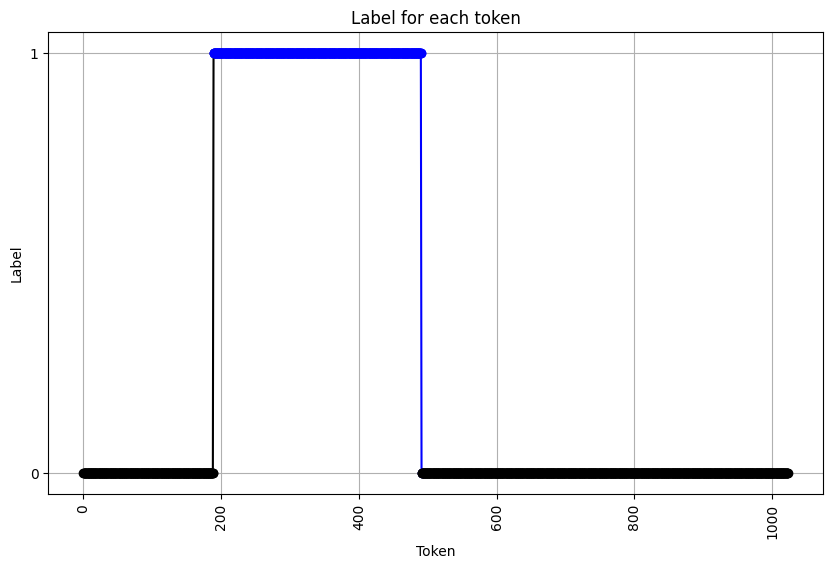

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [02:03<00:00,  2.68s/it]

MSLTGLVKAKDPVLQLDYLRVSDVGTVGAGGDDTAVILAAIARANAEKKSLQFPERAHLKISGNVPLRFKYGADFNHSTLDVDDFTSKIYIERPTELQPYTLSKTSPEVQAIVTKGETLWGGLINAWANNTSLKNAYLVIRTGTNAFEYRNGIFKVVARNRLYRGGALAHNFDYPITPASIESIDVYPVPDYETQFGNLVVHRTSDPKDLFQVEHSRLKMHNIQCNHDGGLVSTGMIWINADNCFDVTYDSICTPFGNRYLSNPADPSSLLASYVFRFGDSYNVHLKNLHSNGLEWGTIGTDEVTNCLVEDCTLSRYDSHRPFHGYLVMVGCHFGARGLSVQGAGSFMLLERCDFLNNSINDYSPNNGLPFFINSRGDAGGFVDVDLIIRDCRFVNNLGQAVHVIAQTWAPDFSSGLPAGSPYRNVTFRTVTIENPVVQTDPSNSASQVDFGVREALTGGSGTPTALNTPDMPTKITLINVNSRLTGKAVFTLVNTRPASPTRAVTVLDSDTNPMTIPTNLSVVMRDCVWAAEAGVPVTLVDATGTYSADIAWDNVRNSSDSNQLSMRLFMPARMRASKSRIREIRPFYNGITLIKPMQFLFDSCEIYPPDTLISWDSSKTNHVCSLTGCSVLGDTMAVLAKVAEYRLSGCQYFLTGSGKVRVPITTSLASGTGTFLSVANLNVDNLYMLNTAQGDWPLRIPAPANAAYMHVGFTEDGATAKRIKFYRSSGTGGGIALTLFPADGAAPLPTFVYLP*




In [31]:
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        if record.description.split("locus_tag=")[1].split("]")[0] in dpos :
            print(record.description)
            protein_seq = record.seq.translate()
            prediction, sequence_outputs = predict_sequence(model_classifier, str(protein_seq))
            plot_token(sequence_outputs)
            print(sequence_outputs)
            print("\n")

  0%|                                                                                                                                                   | 0/46 [00:00<?, ?it/s]

lcl|ON602724.1_cds_UVX29033.1_41 [locus_tag=A1o_00041] [protein=tail protein] [protein_id=UVX29033.1] [location=26268..28628] [gbkey=CDS]


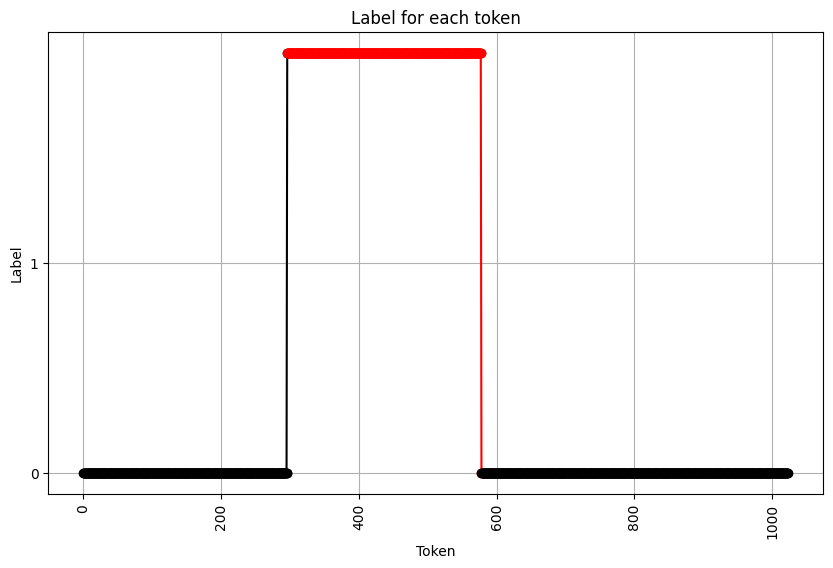

  7%|█████████                                                                                                                                  | 3/46 [00:01<00:21,  1.97it/s]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPSGNVGVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMSGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTIPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602748.1_cds_UVX30926.1_46 [locus_tag=A1c_00046] [protein=tail protein] [protein_id=UVX30926.1] [location=complement(35881..38196)] [gbkey=CDS]


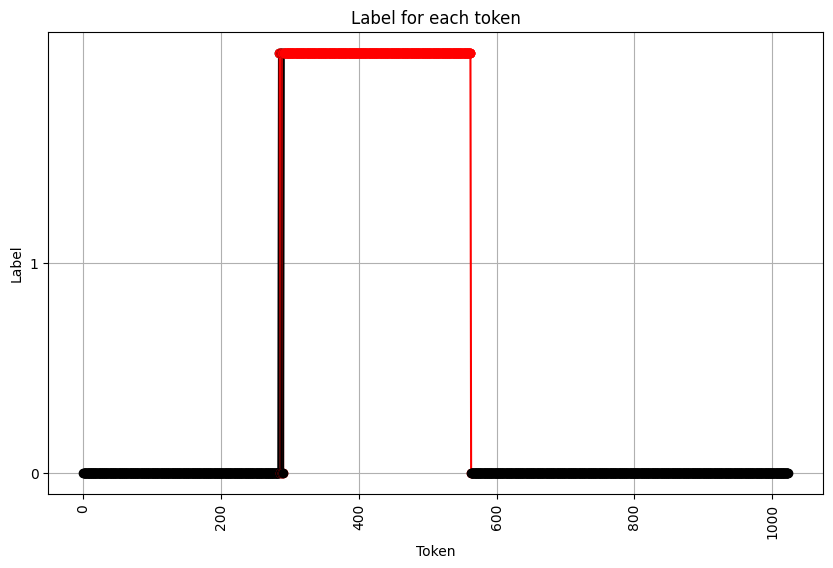

  9%|████████████                                                                                                                               | 4/46 [00:03<00:34,  1.20it/s]

VSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPPAEIAWQSTIDNPGLDELFVEYVERGTDGRHLLINTANGNWWLLSKNGQGIVNSGNDPYFVTTVGQTSIQTASIAGLTYILNTEMRPNTTVDNTGRTDPSTTGFFYVKSAAFQKRWNVTVTSGGTDYSGNYTAPAAGSTSGNAEEVSGAYVVAQLRDSLVANGLPAGNVSIRGAYMFFFGLTNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPSEANGAMCRVGTASSETAWYKFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNENPGFVENGYITGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRITPVMAGQTVIYPNKRNDRYAGVLELIPSPYTSSQYTTQDATVHLPRYVPGRVLQMQNSSVTNMAFMRFSGDRKSLLVYEFMWGGTDGAKMQAAWHKWTLPYNLVGVQALEDEVFLYMQGPSPGNKLLVLSMDPRAGYNLGEEYTEAYSDLQVQVTVSGGVLTVPAVLRPLAWADTFKEDLVLTYPADSPMGPTEVGLQAIAGENQLSVVRGVPDGQYVIGRRYKSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVTDTPRDVDWSGELTGILMNSKELTLGQTLRMDLATITVPCRTNADTTEVTMFTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602762.1_cds_UVX31814.1_13 [locus_tag=A1d_00013] [protein=tail protein] [protein_id=UVX31814.1] [location=complement(13839..16199)] [gbkey=CDS]


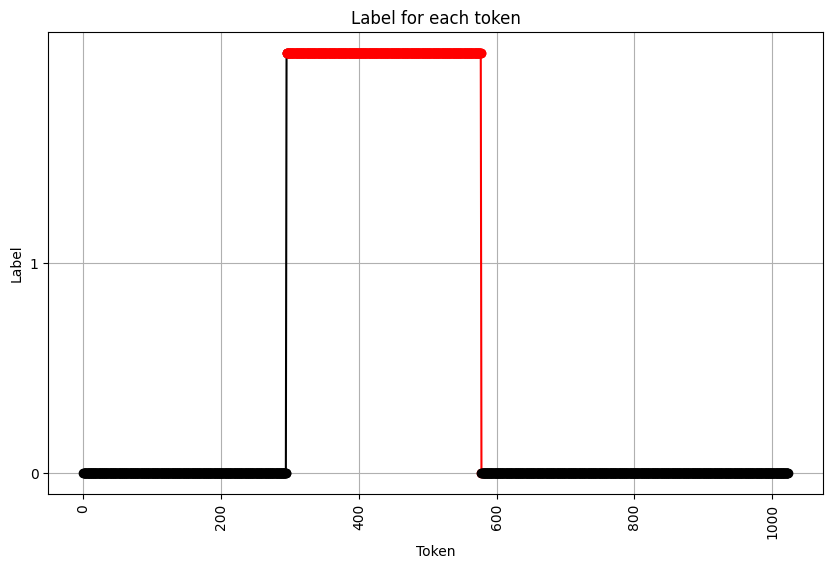

 11%|███████████████                                                                                                                            | 5/46 [00:04<00:41,  1.01s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNITVTSAGVDYSGDYSAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAEVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFEVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602726.1_cds_UVX29113.1_10 [locus_tag=A1q_00010] [protein=tail spike protein] [protein_id=UVX29113.1] [location=complement(4324..5277)] [gbkey=CDS]


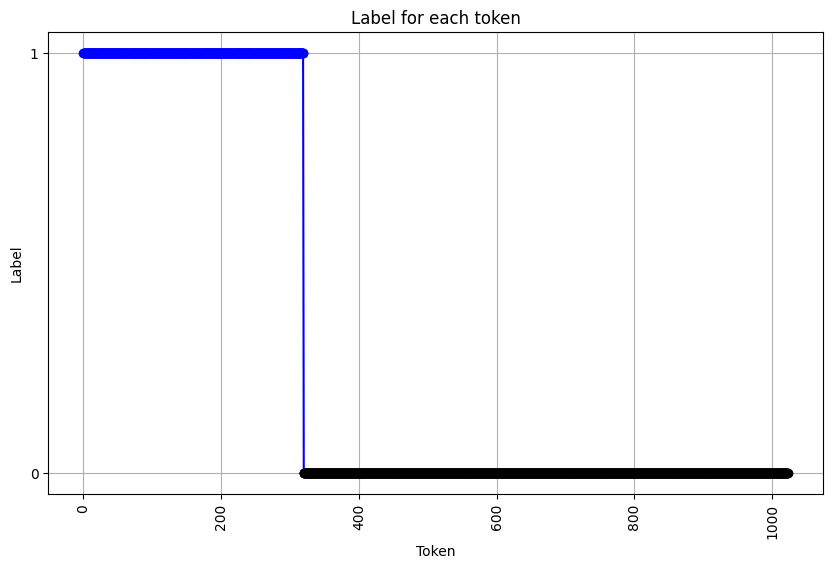

MALVENVQTRYYSQDDLWCRVADYLAKDAPVLTGLRPDSSGNYAAAIERVSAKGVKVLRVPVGSYYVGDCHLTNPMLFIGDDLEGVNPLGAVFIKPSTAAKMFYFDGTSTRGTGGGFLRMRLQGAVSSDSGLMVEVTSWSYFGAENSAFNNLAGSALVLRDCMESHISGNLFRRMGASNGSVILLGDYVDIPNNNVNNLHIQNNTFGLCSGAWVKSTTSSNPDLIWVTDNKFEWDSVPYGANTATQHVLDFGQLSRAWITRNGFTHFRPDSDHNLYAGCIRIRSGAVGPIVISDNKAYGCEGEFWTIEGGLCRCLRQ*


lcl|ON602726.1_cds_UVX29126.1_23 [locus_tag=A1q_00023] [protein=tail protein] [protein_id=UVX29126.1] [location=complement(18846..21206)] [gbkey=CDS]


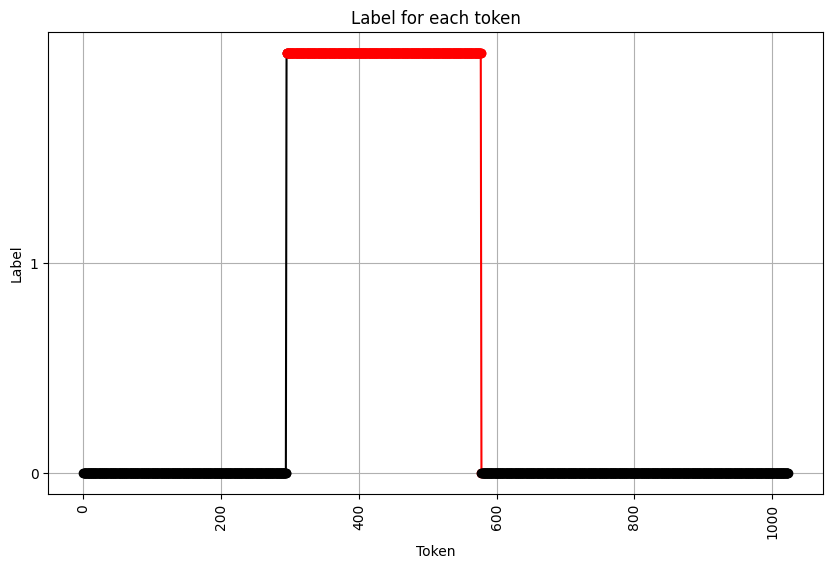

 13%|██████████████████▏                                                                                                                        | 6/46 [00:06<00:56,  1.40s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTILNSGNDPYFITTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNTAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPQDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602725.1_cds_UVX29059.1_13 [locus_tag=A1r_00013] [protein=tail protein] [protein_id=UVX29059.1] [location=complement(13856..16216)] [gbkey=CDS]


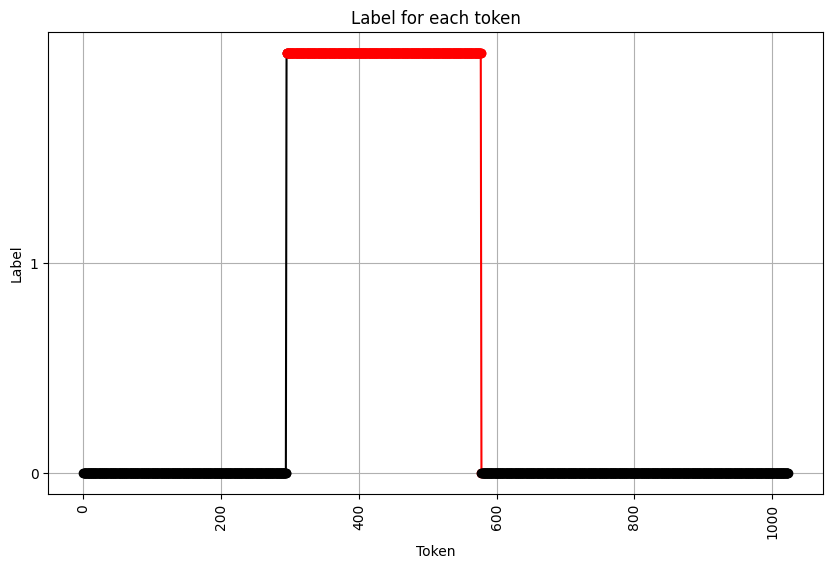

 15%|█████████████████████▏                                                                                                                     | 7/46 [00:08<00:55,  1.41s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTILNSGNDPYFITTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNTAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPQDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602756.1_cds_UVX31420.1_24 [locus_tag=A1f_00024] [protein=tail protein] [protein_id=UVX31420.1] [location=complement(20395..22755)] [gbkey=CDS]


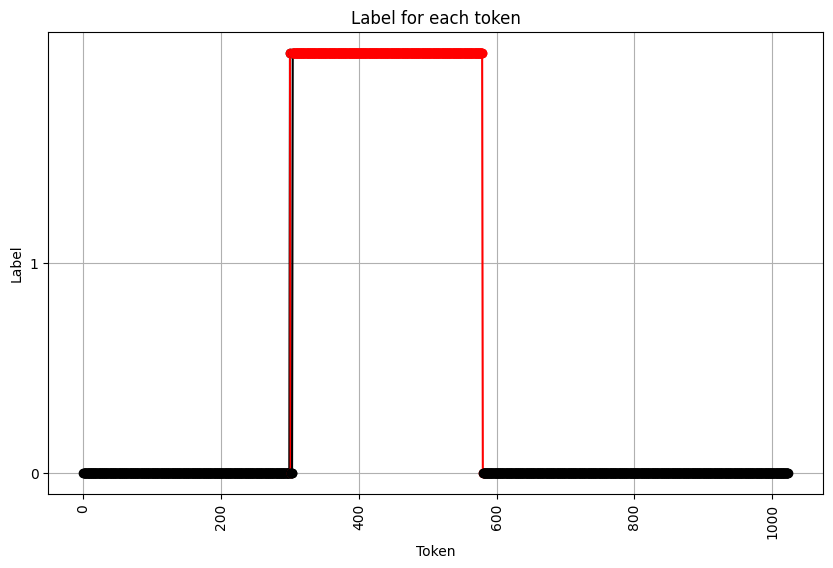

 20%|███████████████████████████▏                                                                                                               | 9/46 [00:09<00:39,  1.08s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGYYTAPAAGTTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGMEYRGAYSDLQKQVQVQDGVFTVPAVLRPVGWADRYREEIILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILLDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602761.1_cds_UVX31789.1_45 [locus_tag=A1g_00045] [protein=tail protein] [protein_id=UVX31789.1] [location=27287..29647] [gbkey=CDS]


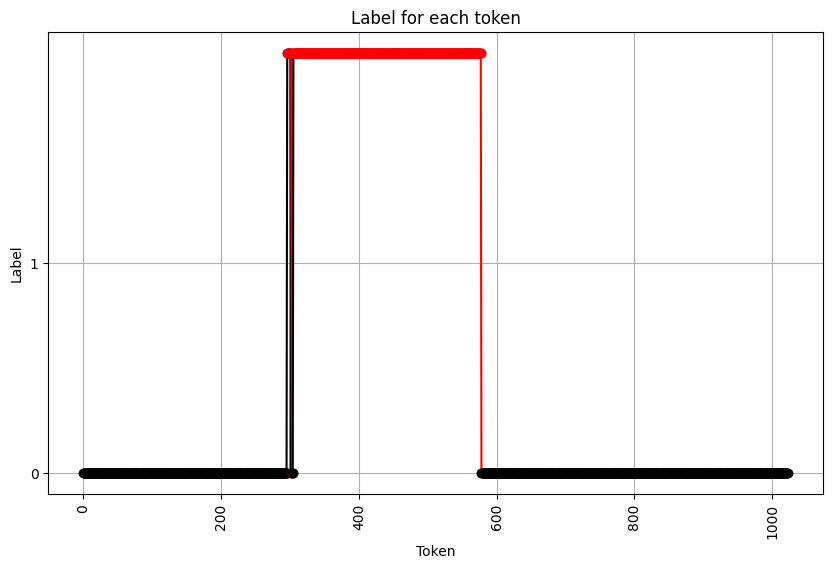

 22%|██████████████████████████████                                                                                                            | 10/46 [00:10<00:40,  1.13s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPSGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFNYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSDPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602742.1_cds_UVX30492.1_16 [locus_tag=A3b_00016] [protein=tail protein] [protein_id=UVX30492.1] [location=9964..12339] [gbkey=CDS]


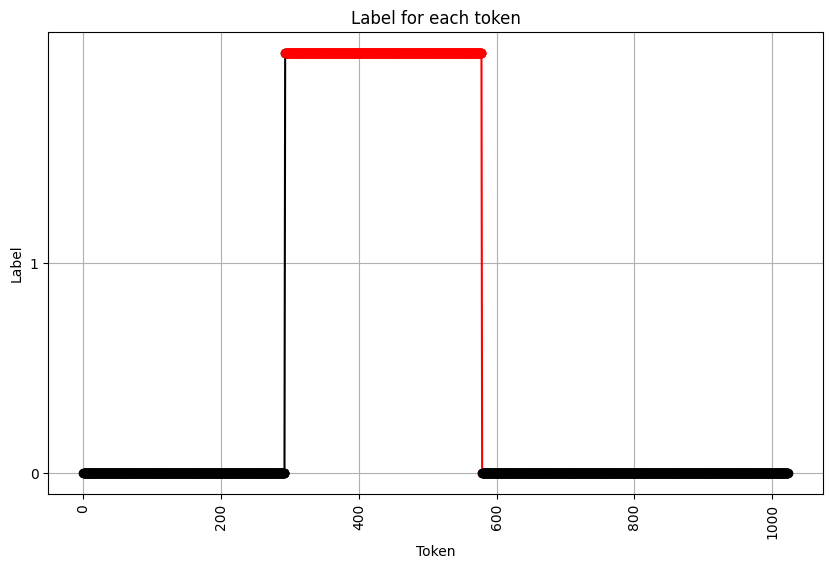

 24%|█████████████████████████████████                                                                                                         | 11/46 [00:12<00:42,  1.22s/it]

MALVSQSIKNLKGGISQQPEILRYPEQGSLQVNGWSSETEGLQKRPPMVFIKSLGPRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGDRSYVTVNNPKDNLRMVTVADYTFIVNRTRQVRENQNMTNGGTFRDNVDALINVRGGQYGRKLEVNINGVWVSHQLPPGDNAKEDPPKVDAQAIAEALATLLRAAHPTWTFNVGTGFIHCIAPADTTIDILETKDGYADQLINPVTHYVQSFSKLPLNAPDGYMVKIVGDTSKTADQYYVKYDKSQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHDWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVMSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFACVLTKGATSKVFIYKFLYMDENIRQQSWSHWDFGDGVEVMAANCINSTMYLLMRNAYNVWIAAVDFKKESTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITEYEPMGDSWDSTPDIRISGDISGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDSGRLQLRRAWVNYQNTGAFTVSVDNGSREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602754.1_cds_UVX31298.1_2 [locus_tag=A1j_00002] [protein=tail protein] [protein_id=UVX31298.1] [location=complement(1418..3778)] [gbkey=CDS]


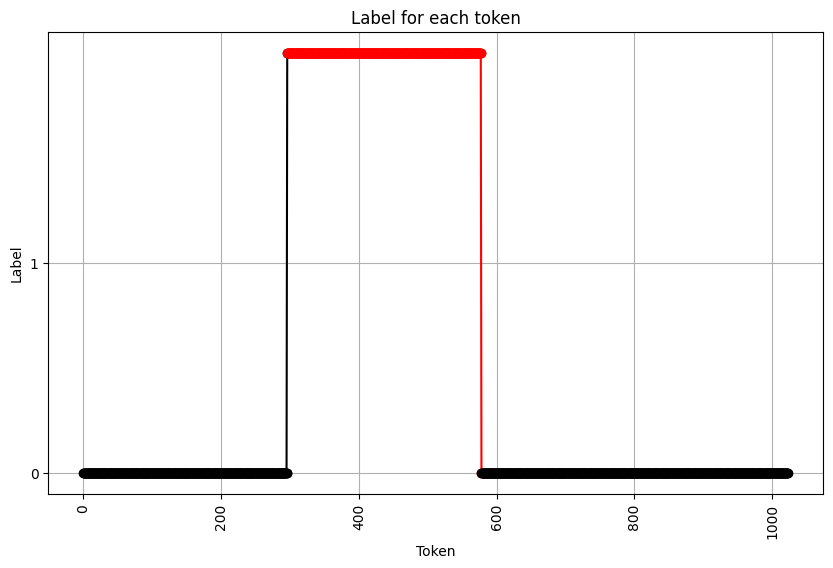

 26%|████████████████████████████████████                                                                                                      | 12/46 [00:13<00:43,  1.28s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATAHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602763.1_cds_UVX31864.1_10 [locus_tag=A2a_00010] [protein=tail protein] [protein_id=UVX31864.1] [location=complement(11758..14142)] [gbkey=CDS]


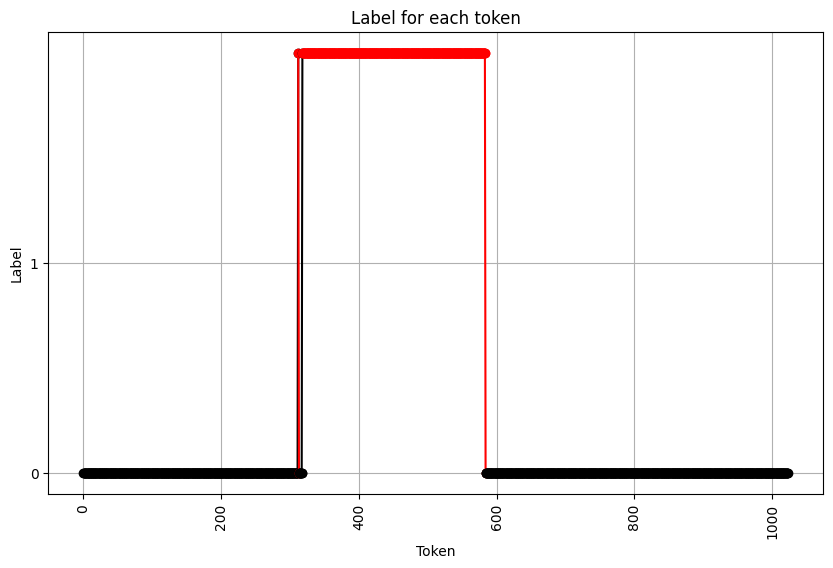

 28%|███████████████████████████████████████                                                                                                   | 13/46 [00:15<00:42,  1.29s/it]

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQNNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAAVYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGESASDVETIRTEVIAEQLYTNLLTWAGVSDYTVSRLGTTIVIKRNDGANFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPVGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFEGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDSLTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYALKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602727.1_cds_UVX29207.1_45 [locus_tag=A1m_00045] [protein=tail protein] [protein_id=UVX29207.1] [location=27634..29994] [gbkey=CDS]


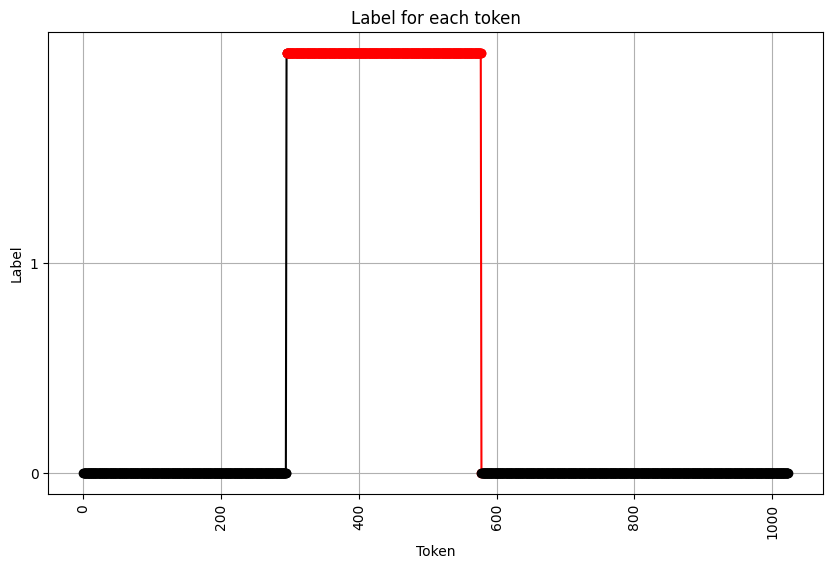

 30%|██████████████████████████████████████████                                                                                                | 14/46 [00:16<00:43,  1.35s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPTEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602728.1_cds_UVX29269.1_50 [locus_tag=A1n_00050] [protein=tail protein] [protein_id=UVX29269.1] [location=31872..34130] [gbkey=CDS]


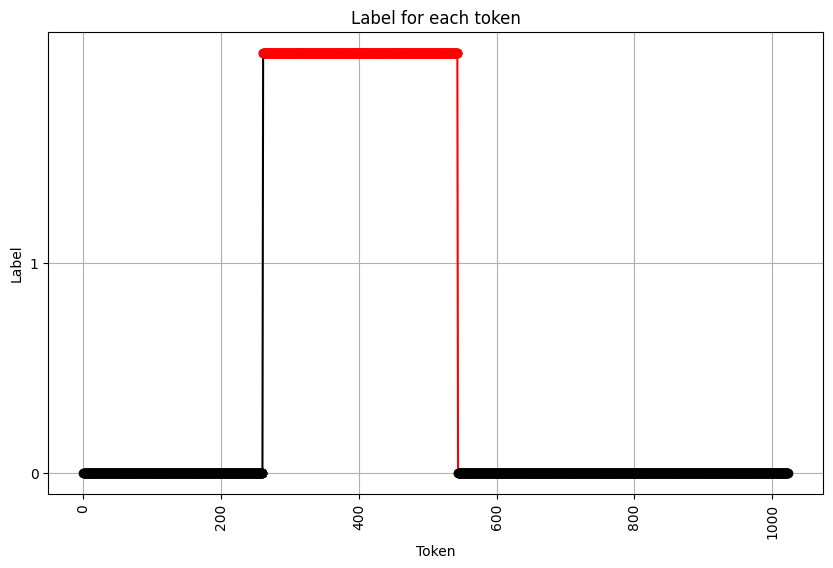

 35%|████████████████████████████████████████████████                                                                                          | 16/46 [00:17<00:31,  1.04s/it]

MLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602723.1_cds_UVX28987.1_55 [locus_tag=A1p_00055] [protein=tail protein] [protein_id=UVX28987.1] [location=32970..35228] [gbkey=CDS]


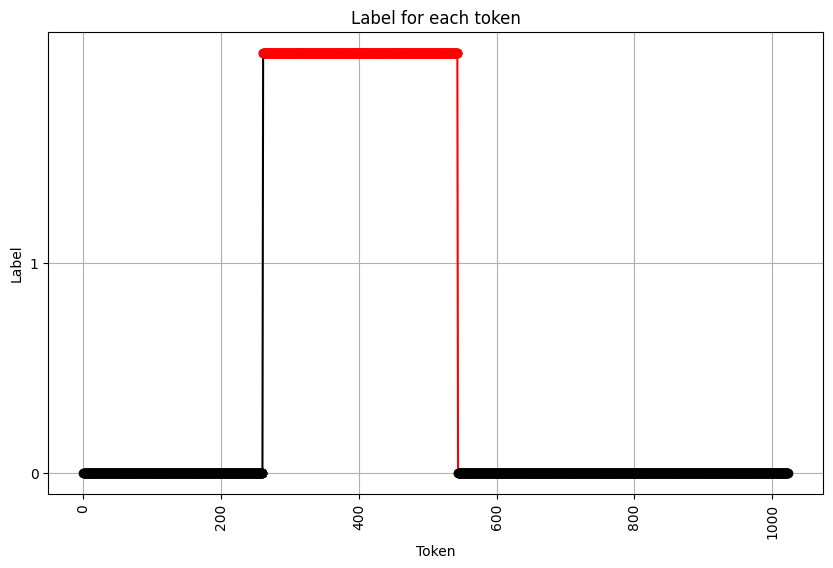

 37%|███████████████████████████████████████████████████                                                                                       | 17/46 [00:19<00:32,  1.11s/it]

MLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERSSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGAEYREAYSDLRKQVQVQDGVFTVPAVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFYVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602753.1_cds_UVX31285.1_36 [locus_tag=A3d_00036] [protein=tail protein] [protein_id=UVX31285.1] [location=22885..25260] [gbkey=CDS]


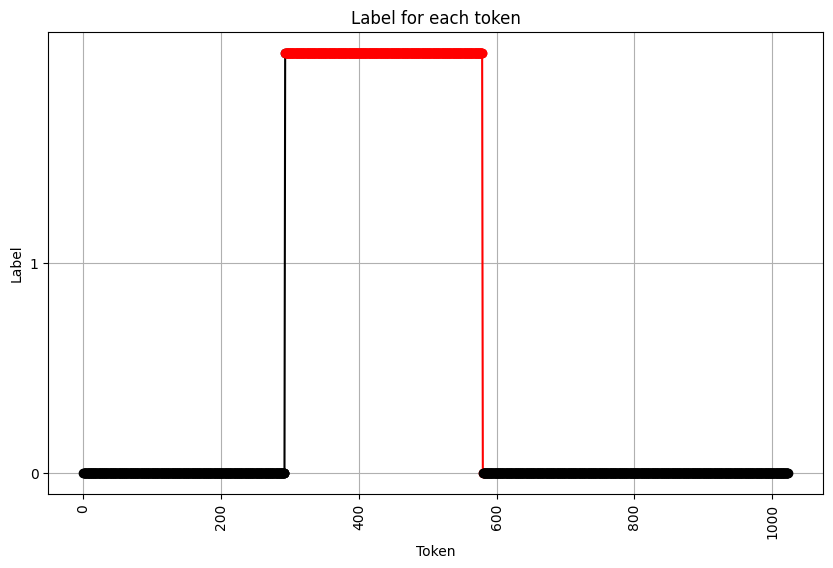

 39%|██████████████████████████████████████████████████████                                                                                    | 18/46 [00:21<00:36,  1.31s/it]

MALVSQSIKNLKGGISQQPEILRYPEQGSIQVNGWSSETEGLQKRPPMVFIKSLGDRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGERSYVTVNNPKDNLRMVTVADYTFIVNRTRQVRENQNVTNGGTFKDNVDGIINVRGGQYGRKLEVNINGVWVSHQLPPGDNAKDDPPKVDAQAIAVALADLLRTAHPTWTFNVGTGYIHCIAPAGVTLDEFQTRDGYADQLINPVTHYVQSFSKLPLNAPDGYIVKIVGDTSKTADQYYVKYDASQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHEWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVMSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFTCVLTKGAPSKVFIYKFLYMDENIRQQSWSHWDFGDGVEVMAANCINSTMYLLMRNAYNVWIAAVDFKKNSTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITTYEPMGDSWNSTPDIRISGDIAGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDAGRLQLRRAWVNYQDTGAFTVSVDNGSREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602755.1_cds_UVX31386.1_39 [locus_tag=A3c_00039] [protein=tail protein] [protein_id=UVX31386.1] [location=23812..26205] [gbkey=CDS]


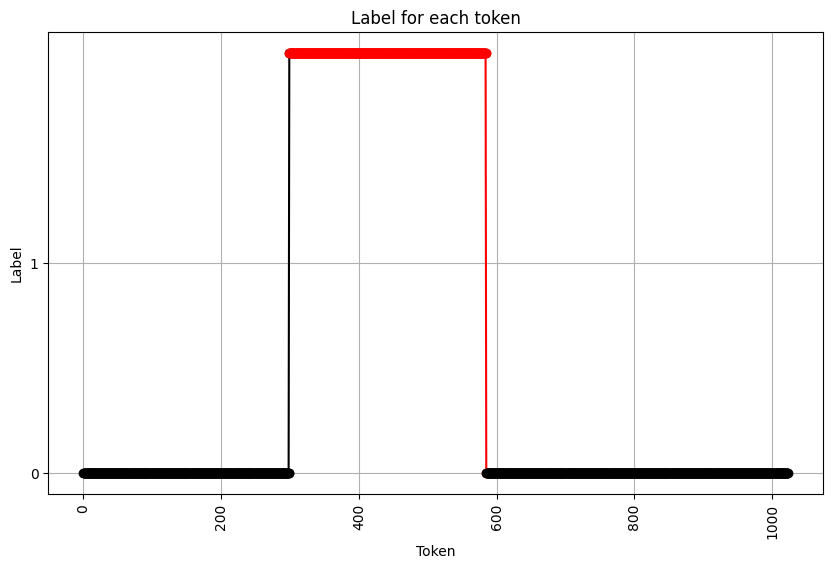

 46%|██████████████████████████████████████████████████████████████▉                                                                           | 21/46 [00:22<00:22,  1.11it/s]

MALVSQSIKNLKGGISQQPEILRYPEQGSLQVNGWSSETEGLQKRPPMVFIKSLGDRGYLGDRGYLGEDPYIHLINRDEYEQYYAVFTGNDVRVFDLSGYEYQVRGDRSYISVSNPKDNLRMVTVADYTFIVNRTRQVRENQNVTNGGTFRDNVDGIVNVRGGQYGRKLEVNINGVWVSHQLPPGDNAKDDPPKVDAQAIAAALADLLRVAHPTWTFNVGTGYIHCIAPAGVTLDEFQTRDGYADQLINPVTHYVQSFSKLPLNAPDGYTVKIVGDTSKTADQYYVKYDASQKVWKETVGWNISVGLEYHTMPWTLVRAADGNFDLGYHEWKDRRAGDDDTNPQPSFVNSTITDVFFFRNRLGFISGENIVLSRTSKYFEFYPPSVANYTDDDPLDVAVSHNRVSVLKYAVSFAEELLLWSDEAQFVLSANGVLSAKTAQLDLTTQFDVSDRARPYGIGRNIYYASPRSSFTSIMRYYAVQDVSSVKNAEDMTAHVPNYIPNGVYSINGSGTENFACVLTKGAPSKVFIYKFLYMNEDIRQQSWSHWDFGDGVEVMAANCINSTMYMLMRNAYNVWIAAVDFKKESTDFPFEPYRFHVDAKRSYHISETAYDIETNQTVVNVKDIYGASFSKGTVAICESDGKITTYEPMGDSWDSTPDIRISGDISGKDIVIGFLYDFQYVFSRFLIKQEQNDGTTSTEDSGRLQLRRAWVNYQDTGAFTVSVENGNREFNYLVNARVGSTGLRLGQKATTTGQYRFPVTGNALYQKVSLSSFNASPVSIIGCGWEGNYSRRANGI*


lcl|ON602740.1_cds_UVX30347.1_5 [locus_tag=A1l_00005] [protein=tail protein] [protein_id=UVX30347.1] [location=complement(8381..10741)] [gbkey=CDS]


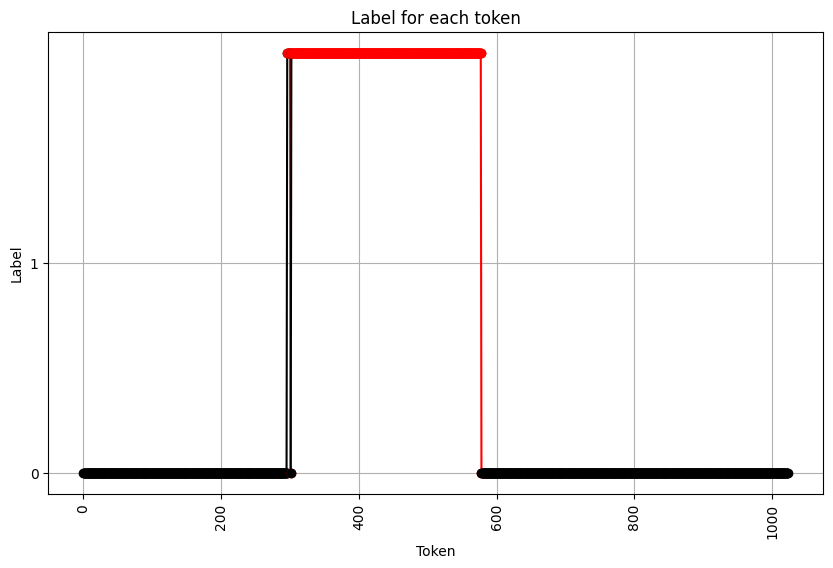

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 23/46 [00:24<00:20,  1.11it/s]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGIDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIASLTYILNTEMTPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDREQDLPAQLPAEADGAMCRVGTASSETAWYQFDYGTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLVVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPAVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602733.1_cds_UVX29758.1_45 [locus_tag=A3a_00045] [protein=tail protein] [protein_id=UVX29758.1] [location=32132..34498] [gbkey=CDS]


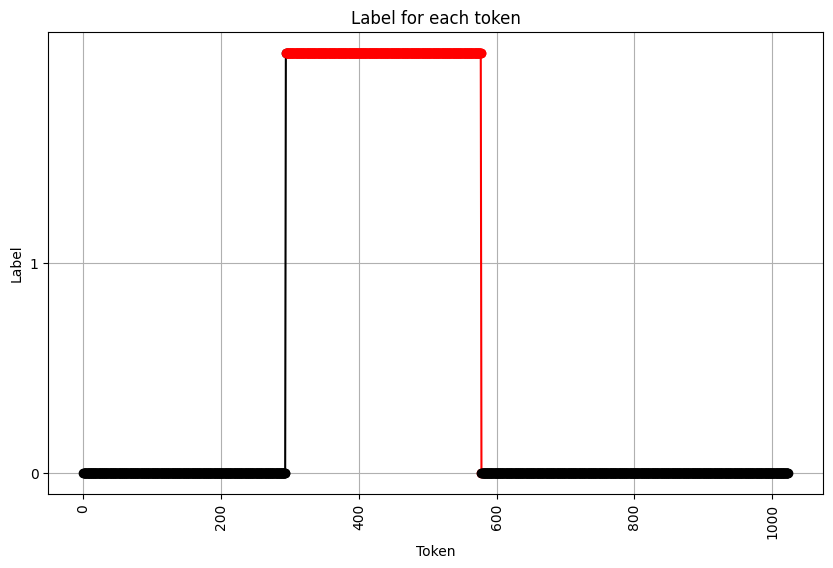

 52%|████████████████████████████████████████████████████████████████████████                                                                  | 24/46 [00:26<00:23,  1.07s/it]

MALVSQSIKNLKGGVSQQPDILRYPEQGAKQVNGWSSETEGLQKRPPVVLKKVLGDAGYLGSDPMVHLINRDENEQYYVVFTGSSIRVFALDGTERTVRGDFSYVTTGNPQKDLRMITVADYTFVVNTTKTVEVNDGSLSNGGNFQDNVDGLINVRGGQYGRKLVVTINGTTVEHQLPSGSNATEDPPKVDAQAIAEALAVLLRAALPSWTFDVGTGYIHVQAPSGTTINEFITKDGYADQLISPVTHYAQSFSKLPLNAPDGYLVKIVGDTSKTADQYYVKYDKTQKVWKETIGWNVTTLLHFHTMPWALVRAADGQFDFNWHNWEPRKAGDDVTSPHPSLVGSQITDVFFWRNRLGFLSGENVVLSRTGRYFDLYPPSVANLSDDDPIDVAISHNRVSILKYAVPFAEELLLWSDEAQFVMSASGVLSAKSVELNLTTQFDVQDGARPYGIGRNIYFASKRATYSSVYRYYAVADVSEVKNAEDITTHIPQYIPNGIFSINGSGTENFCSVLTKGAPNKIFTYKFLYIDEQIRQQAWSHWEFPEDVRVLAADSIGSTMFLLMKNHTHSWLGQVDFTKDTTDLPNEPYRLYLDLKKEYTIPSSAYNWDTNETTVTLSSVFGMTLGGNSKLSMVEEDGKVTTWDTYGSTVSMIGDYSGKHVFFGVHIPFTYEFSKFLIKKTDEYGSTSTEDSGRLQLRRAWVNYEDSGQFTVSVQNLSRTFEYDMGGNRIGSDKLVLGKLNLGTGQYRFPVVGNARVNTVTIYSEAPTPLNIIGCGWEGNYTRRTSGI*


lcl|ON602765.1_cds_UVX31982.1_22 [locus_tag=A2b_00022] [protein=tail protein] [protein_id=UVX31982.1] [location=complement(22541..24925)] [gbkey=CDS]


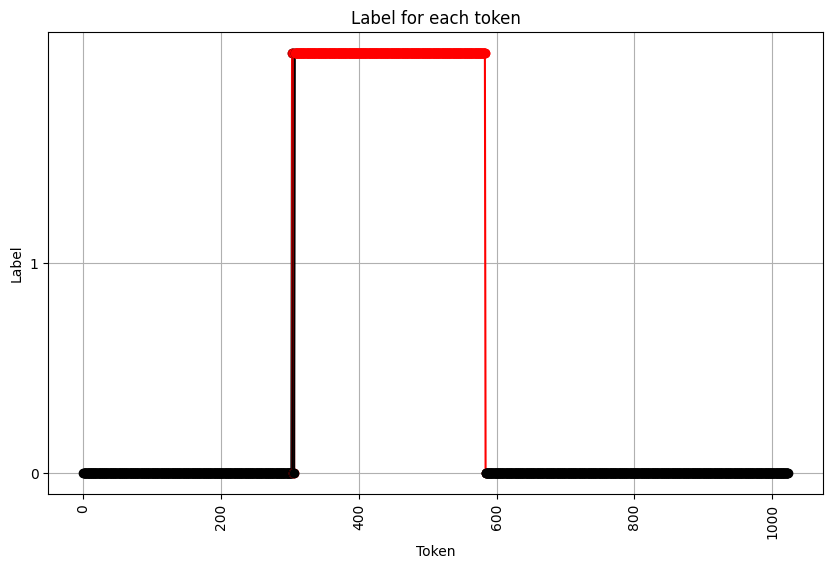

 54%|███████████████████████████████████████████████████████████████████████████                                                               | 25/46 [00:27<00:25,  1.19s/it]

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQDNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAASYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGGSASDVETIRTEVIAEQLYTNLLTWAGASDYSISRMGTTIVISSLSGASFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPAGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFNGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDELTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYALKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602736.1_cds_UVX30050.1_152 [locus_tag=M5a_00175] [protein=tail fiber protein] [protein_id=UVX30050.1] [location=96188..97225] [gbkey=CDS]


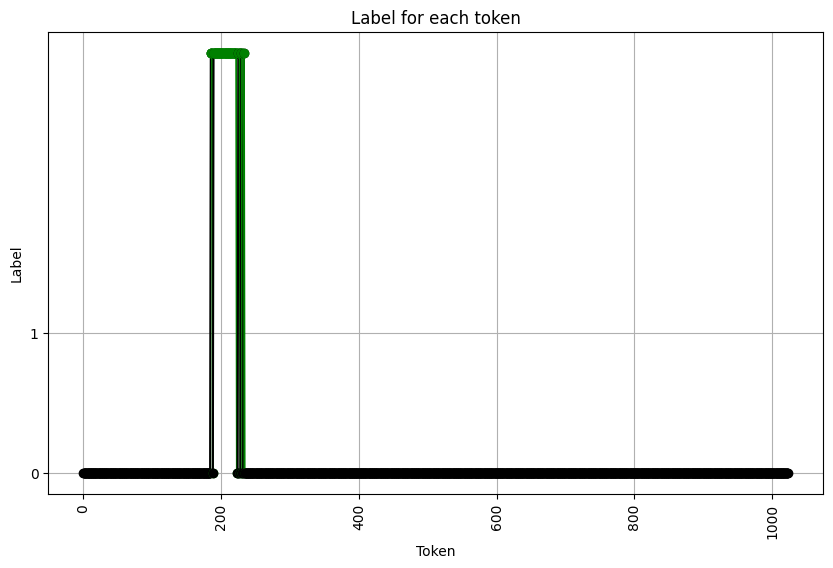

 59%|█████████████████████████████████████████████████████████████████████████████████                                                         | 27/46 [00:29<00:18,  1.03it/s]

MAIPTIPLQIWAESDVVLPNAHTANKISPIADLWDKGWDLGEKPACEELNYVLNMMTWWMTYISEEQIPGLSNDYLRKDQNLSDVSDIPTARSTLDVYSKSESDSRYVNVDGDTMTGPLTVPRINFPVGTSDSAYITTTLGNDITMLDFVIGDNSGTAGSATVDSIRFRFSPTDTSSTFTMMELNATGTNTALLRVQGNITATGTMTTGTLASTTINNGGNIQTTSLGVGGTATLQNLVVNSNNATIGGRSVVRAVNSTAANANGDVSISIGVSDIRWSGEQNKVQVNFENYGSSGRLARGPDGSVLTGLIDANASGDLYLHDIDEIRFRFLQKALDGIWYTVGL*


lcl|ON602736.1_cds_UVX30096.1_198 [locus_tag=M5a_00221] [protein=hypothetical protein] [protein_id=UVX30096.1] [location=complement(125811..126230)] [gbkey=CDS]
lcl|ON602752.1_cds_UVX31228.1_36 [locus_tag=A1b_00036] [protein=tail protein] [protein_id=UVX31228.1] [location=22532..24898] [gbkey=CDS]


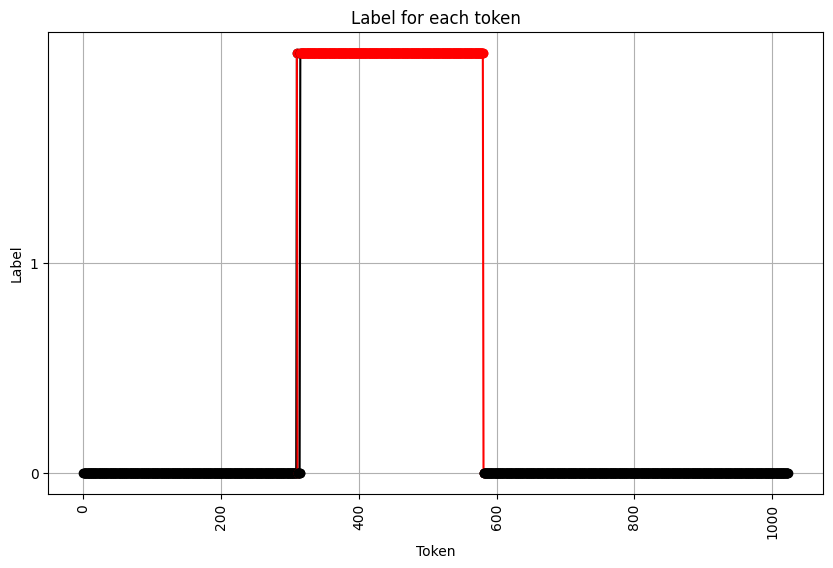

 61%|████████████████████████████████████████████████████████████████████████████████████                                                      | 28/46 [00:30<00:19,  1.10s/it]

MAQTPIRALEGTIQSLLQGVSQQVPRERQPGQLGEQLNMLSDPVSGIRRRPPAEVRINPGIPGFNLDSLFVEYVERGTDGRHLLINTDTGNWWLLSKDTQVIVNSGQDDYFKASLGQTSLQTTSIAGLTYILNTEKAPTITRDNGDKIDPATTGFFYVKTSAFQKRWTVTVTTGGVDYTAFYNAPAAGTTAGNAEEVSAAYVIEQLRLELINQGFPAANVSTRGAYMFFFGMTNCVVGTDAGDTYAIVSNQSKVTLESDLPAQLPAEADGAMCQVGQASSEAAWYKYDFASRTWSETGAYGSISSIGNMPRELAADDQILVRAWEGRLSGNDDNNEDPGFVVNGYITGIAAFQGRLVLLSGSTVDMSASGLFQRMYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVIFANSMQAVIPGSVVLTPTNASISITSTFECDSRVTPIMAGQTVIYPSRRNSSYASVLELIPSPYTSSQYTTVDSTVHLPRYIPGRIMQMQTSSVTNMAFMRYTGQRNALLVYEFMWGGGDGAKVQSAWHQWTLSYPILGVQALEDLVYVYMQGPGNALLVAAMDPREGYTLGQEYDTAYSDFPTTVTVSGGQFTVPSIFRYTNYHLSIKEELVLTYPQGTAMAATEVGLNEFLGANIVSVVRGVPDGTYVLGRRYKSAMTLTTPTLRDRNDKLVGSGHVRLLRLDVALRNSGHFDVHVTDTPRDVDWGGELSGILMNSKELVLGRTLRVDLAVVTVPCRTNADTTEIQFSTNGSQELNILDISYILRYNQRRQRI*


lcl|ON602757.1_cds_UVX31465.1_12 [locus_tag=A1e_00012] [protein=tail fiber protein] [protein_id=UVX31465.1] [location=complement(6743..8497)] [gbkey=CDS]


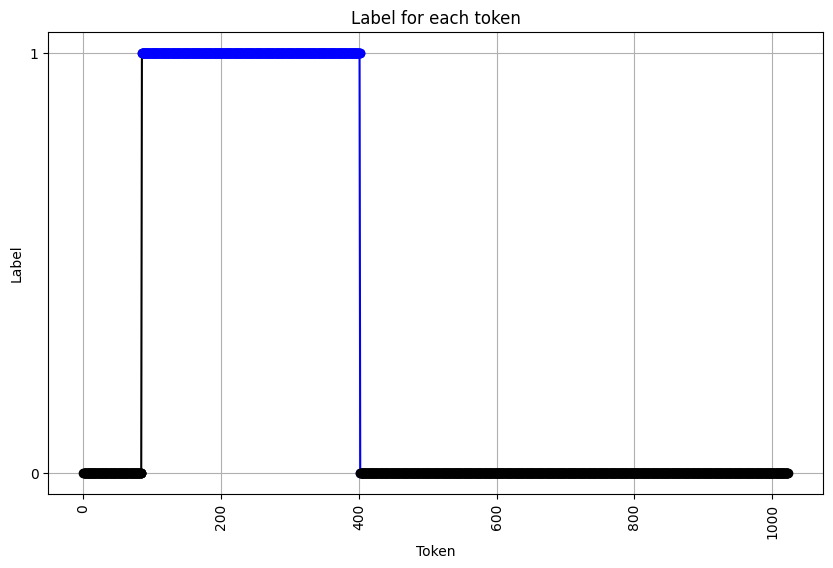

MALTKLVAVQSPTGNQRDCANIAALRAFTCSHVGQEVTLREHTSGQGSGGGVWYCHALTAGSAVDDNGCQIINNAGQVLRRRDLKELTSSYFGLKAGDIIDPVLDNMYKASRTFNIYEAKIENPGFDKGYLLTGGKRYYCGDKPFYILSYSIGTLRGPNIWHTGDNVGITFSRFKTDGTSEQAWSGGGIRGFRIWGAASYLVQGNEGVNAAPVRLSDMWQGEACDLWVTGYTGNTNGAVVSLYNEYAWTEGAIVENIMVRQSLRGLTFLRNHGTTATDSFFRVVADISFNAGVSGKATQVMVVGDGTAAGACLVYGHDIKLTQWMSAGSWHDIVRLEDYSIIAETGVIKIVADGYGISKTTVPSTEVVHSINVRGLNARFRSRVENWSNQAGGWGLDFLNIIFQSSMYTNAMTFYESDFDALPTINPVGMKIRYNGTFTVAERQSGKVYTLNGLIPGTTLKVKLTSRNGGDLNDAVVQEWKVFVRSTNLPCIVVPMSGSANIATTDGLAVTNISPVQTATFLKTVTPTQARNFIGQNYGLTVKNANDDNSLSYAVNSGRKIRFILPANPGATTTSPYSVEIEVL*


lcl|ON602757.1_cds_UVX31477.1_24 [locus_tag=A1e_00024] [protein=tail protein] [protein_id=UVX31477.1] [location=complement(20454..22814)] [gbkey=CDS]


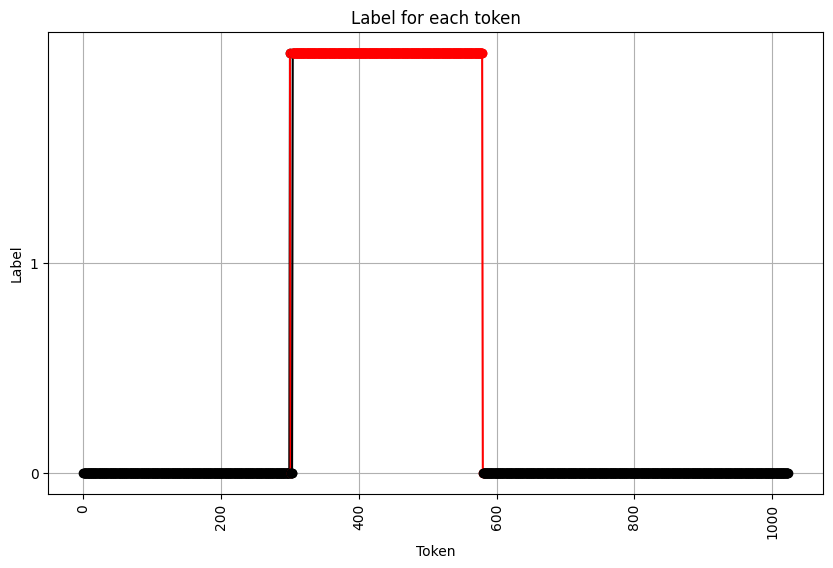

 63%|███████████████████████████████████████████████████████████████████████████████████████                                                   | 29/46 [00:34<00:27,  1.62s/it]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPNTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGYYTAPAAGTTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGMEYRGAYSDLQKQVQVQDGVFTVPAVLRPVGWADRYREEIILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILLDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRV*


lcl|ON602732.1_cds_UVX29661.1_2 [locus_tag=A1a_00002] [protein=tail protein] [protein_id=UVX29661.1] [location=562..2943] [gbkey=CDS]


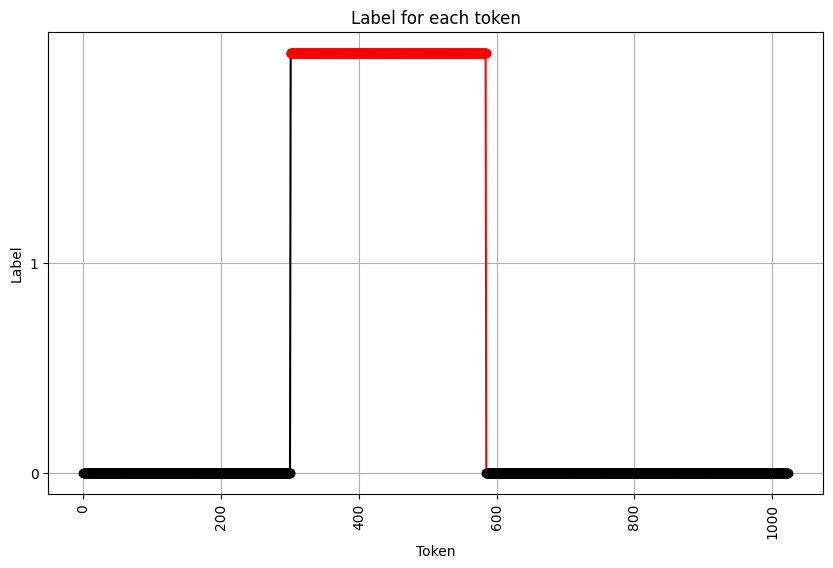

 70%|████████████████████████████████████████████████████████████████████████████████████████████████                                          | 32/46 [00:35<00:15,  1.09s/it]

MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRRPPAEIVWESSIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLSKNGKTIVNSGNDPYFVTTVGQTSIQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYIKTVAFQKRWEITVSWTGGSVVGYYNAPDASNGSSSAEWVSAPYVVNALINGDPNGSGIGAAITAAGGSVSSFEGYMYISGLPNLVVSTSAGDTYAVASGQSRVPQEQDLPAQLPSQANGTMCRVGTASSETAWYQFDYSARTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNQNPGFVENGYIAGIAAFQGRLVLLSGSVVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAIQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYECDSRVTPVMAGQTVIYPNKRNNSYAGILELIPSPYTSSQYATQDATVHLPRYIPGRVLQMQNSSVTNMAFVRMSGQRKNLLVYEFMWGGQDGGKVQAAWHQWTFPYNILGVQALEDEVFLYLQGPSPGNKLLILSMDPREGYNLGSEYTDAYSDLQTQVTVSGGVFTVPAALRPVGWADTYKEDLILTYPANSPMGPTEVGLKDIAGTNQLSVVRGVPDGQYILGRRYNSTFTLTTPVLRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVHVTDTPRDVDWSGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVTLYTKGSQELNVLDISYILRYNQRRRRI*


lcl|ON602743.1_cds_UVX30533.1_9 [locus_tag=A1h_00009] [protein=tail protein] [protein_id=UVX30533.1] [location=7263..9623] [gbkey=CDS]


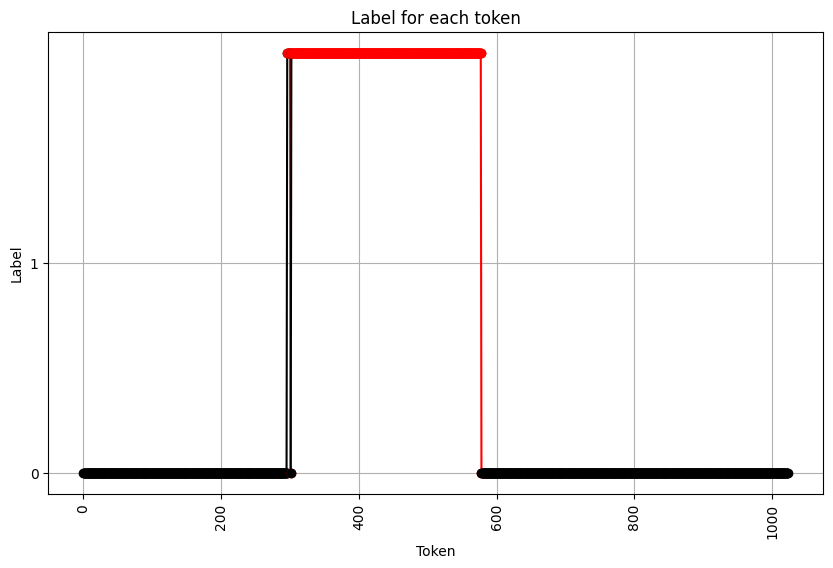

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 38/46 [00:37<00:05,  1.59it/s]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTVVNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYTGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYNTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQGGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTDGSMELNVLDISYILRYNQRRRRI*


lcl|ON602739.1_cds_UVX30304.1_18 [locus_tag=A1k_00018] [protein=tail protein] [protein_id=UVX30304.1] [location=complement(16456..18816)] [gbkey=CDS]


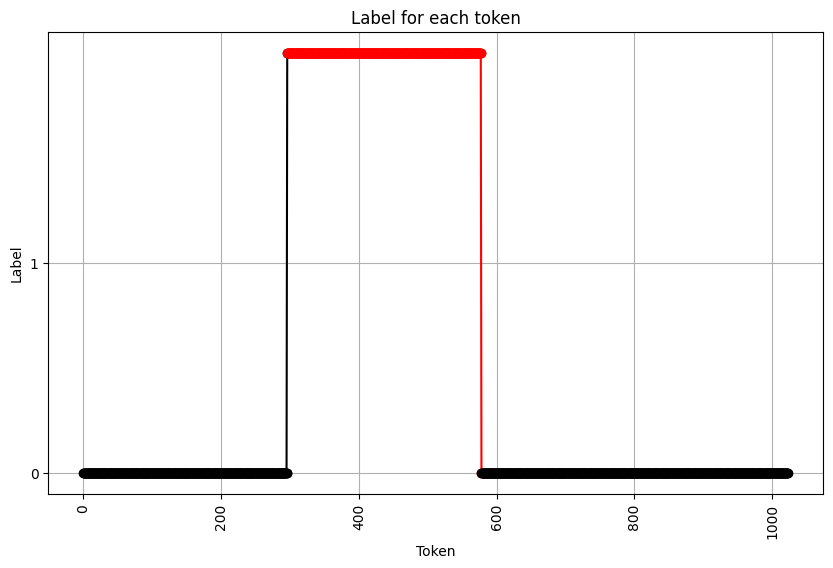

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 39/46 [00:39<00:05,  1.34it/s]

MATSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTVVNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMAPSTTVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYSAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAGVSNQSRVDQEQDLPAQLPAEADGAMCRVGTASSETAWYQFDYSTRTWSEVGAYGSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPGNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADRYKEELILTYLPSNPMGPTEVGIKEIAGENTLRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDTPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*


lcl|ON602729.1_cds_UVX29306.1_32 [locus_tag=M5b_00032] [protein=hypothetical protein] [protein_id=UVX29306.1] [location=15095..15502] [gbkey=CDS]
lcl|ON602764.1_cds_UVX31943.1_36 [locus_tag=A2a_b_00036] [protei

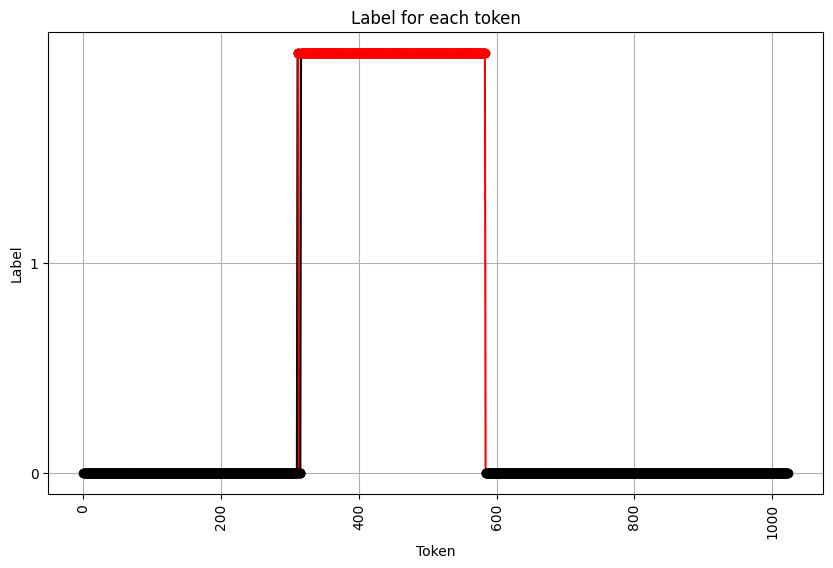

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 44/46 [00:40<00:01,  1.77it/s]

MEVQGSLGRQIQGISQQPASVRLPGQCTDAINCSMDVVEGTKSRPGTVHIARLGDLGLIQNNTNIHHYRRGDDVEEYWMITNPLGIPDIFDKQGRKCTVTETEGAAVYFNSNNPRVDYKFFTVGDTTFVVNRTKIVRARADKTPAVGGTALVFSAYGQYGTNYQIIINGVKAAEYKTASGGSASDVETIRTEVIAEQLYTNLLTWAGVSDYTVSRLGTTIVIKRNDGANFTVDTEDGSKGKDLVAIQYKVTSTDLLPSKAPVGYLVQVWPTGSKPESRYWLKAEAADGNLVTWQETLGADEVLGFEGTTMPYIIERTNIVGGIAQFTIKQGYWDDRAVGDSLTNPMPSFIDQSLSDIFMVQNRLCLAAGESCIMSRTSYFFQFFRQTVLSAVDTDPIDVFADASEVYAIKHAKVLDGDTVLFSDNAQFILPGDKPLTKATALLRPTTTFEVDTNVAPVVTGEAVMFATKDGAYSNIREFYTDSYSDTKKAQPVTSHVNKLIRGGIYHMASSTNFNRLFALSEDNRSRVFVYDWLWQGTDKVQSAWHKWEFYGATIGGLYYSGETLYLIIKRNDGVFLEAMYMGDPLLSGSDQVRMDRTVTVSLTWDEATLSWKSSPLPWVPTQVEMLEAVLTNGNPAYVGGAFLFEYNPSTRVISTKYGLGDTSQTLAAKVGQMYKVEFVPTDVIIRDSQDRVSYQDVPVIGLVHLNLDRYPDFTVEITNRKSGAVRVAKASNRVGGARNNVVGYVKPTSGTFSFPLRALSTDVEYRIISISPHTFQLRDIEWSGSYNPTRKRV*


lcl|ON602767.1_cds_UVX32108.1_37 [locus_tag=A1i_00037] [protein=tail protein] [protein_id=UVX32108.1] [location=24618..26978] [gbkey=CDS]


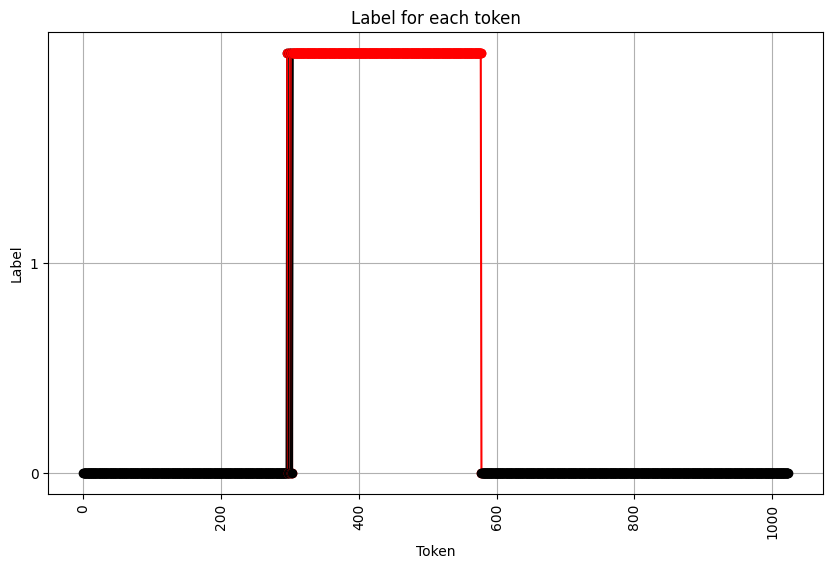

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:42<00:00,  1.08it/s]

MAQSLEGTIQSLLQGVSQQVPRERQPGQLGAQLNMLSDPVSGIRRRPPGEIVWESTIDNPGLDSLFTEYVERGTDGRHLLINTSNGNWWLLAKNGKTILNSGNDPYFVTTVGQTSLQTASIAGLTYILNTEMVPNTIVDNTGRIDPSTTGFFYVKSAAFQKRWNVTVTSAGVDYSGDYTAPAAGSTSGNAEEVSGAYVAQQLRDSLVANGLPAGNVSVRGAYLFFYGLSNCVVSSDAGDTYAVVSNQSRVDQEQDLPAQLPAQADGAMCRVGTASSETAWYQFSYSTRTWSEVGAYDSITKITNMPRELAADDNIIARDWEGRLAGNDDNNSNPGFVENGYITGIAAFQGRLVLLSGSSVDMSASGLYQRFYRSTVTSLLDTDRISISSASAQDSVYRTAVQFNRDLVLFANSMQAVVPGSAVLTPTNASISITSTYDCDSRVTPVMAGQTVIYPNKRNDSYAGILELIPSPYTAAQYTTQDATVHLPRYIPGRVLQMQNSSVTNMAFSRMSGERNSLLVYEFMWGGSDGAKMQAAWHKWSFPYPILSVQALEDEVFLYMQGPSPSNKLLIVSMDPREGYQLGSEYREAYSDLQKQVQVQDGVFTVPSVLRPVGWADNYKEELILTYLPSNPMGPTEVGIKEIAGENALRVVRGVPDGTYVIGRRYRSTFTLTTPILRDQNDKLVGSGHVRLLRLDVAVRNSGHFDVQVLDAPRDVNWGGELTGILMNSKELTLGQALRMDLATITVPCRTNADTTEVSLFTEGSMELNVLDISYILRYNQRRRRI*




In [34]:
with open("/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_plus.sequences.fasta" , "w") as outfile :
    for fasta_file in tqdm(os.listdir(path_out)) :
        fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
        tmp_results = []
        for record in fastas :
            if record.description.split("locus_tag=")[1].split("]")[0] in deposcope_plus :
                locus_tag = record.description.split("locus_tag=")[1].split("]")[0] 
                protein_seq = record.seq.translate()
                if len(protein_seq) >= 200 :
                    outfile.write(f">{locus_tag}\n{protein_seq}\n")
                    print(record.description)
                    prediction, sequence_outputs = predict_sequence(model_classifier, str(protein_seq))
                    plot_token(sequence_outputs)
                    print(protein_seq)
                    print("\n")

In [14]:
def find_longest_non_zero_suite_with_n_zeros(lst, n):
    # Initialize variables to keep track of the longest suite
    longest_start, longest_end = 0, 0
    longest_length = 0
    # Initialize variables to keep track of the current suite
    current_start = 0
    current_length = 0
    current_zeros = 0
    for i, num in enumerate(lst):
        if num == 0:
            # Increment the count of zeros in the current suite
            current_zeros += 1
            # If the number of zeros exceeds n, update the current start index and length
            while current_zeros > n:
                if lst[current_start] == 0:
                    current_zeros -= 1
                current_start += 1
                current_length -= 1
        # Increment the length of the current suite
        current_length += 1
        # Check if the current suite is longer than the longest suite found so far
        if current_length > longest_length:
            longest_start = current_start
            longest_end = i
            longest_length = current_length
    return (longest_start, longest_end)

In [20]:
test_labeled_tokens = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

test_labeled_tokens = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



test_labeled_tokens = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
find_longest_non_zero_suite_with_n_zeros(test_labeled_tokens , 10)

(346, 529)

***
# Run the T30 on the server for the best boundary predictions : 

In [11]:
with open(f"{path_bea}/DepoScope_predictions.bea.full_seq.0709.fasta" , "w") as outfile :
    for fasta_file in tqdm(os.listdir(f"{path_bea}/genomes")) :
        multi_fasta = SeqIO.parse(f"{path_bea}/genomes/{fasta_file}" , "fasta")
        for record in multi_fasta :
            locus_tag = record.description.split("locus_tag=")[1].split("]")[0]
            protein_seq = record.seq.translate()[0:-1]
            if record.description in dposcope_df["protein_description"].to_list() : 
                if len(protein_seq) >= 200 :
                    outfile.write(f">{locus_tag}\n{protein_seq}\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.68it/s]


In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.bea.full_seq.0709.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb



In [ ]:
path_fasta = "/home/conchae/PhageDepo_pdb"

fasta_seq = SeqIO.parse(f"{path_fasta}/DepoScope_predictions.bea.full_seq.0709.fasta" , "fasta")
for record in fasta_seq :
    sequence , prot_name = str(record.seq) , record.description
    prediction, sequence_outputs = predict_sequence(model_classifier, sequence)
    if prediction[0] == 1 :
        start , end = find_longest_non_zero_suite_with_n_zeros(sequence_outputs, 10)
        with open(f"{path_fasta}/Bea_big_predictions.tsv" , "a+") as outfile :
            outfile.write(f"{prot_name}\t{start},{end}\t{sequence[int(start) : int(end)]}\t{sequence}\n")

#!/bin/bash
#BATCH --job-name=Bea_T30__
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=20gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=Bea_T30__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/deposcope_beaphages.py

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/DepoScope_predictions.bea.domains.0709.fasta.out \
/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea 




***
## ESMfold on the unpredicted ones : 

In [3]:
import os
from tqdm import tqdm
from Bio import SeqIO
import pandas as pd 
import DepoScope_functions

path_bea = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea"

dposcope_df = pd.read_csv(f"{path_bea}/DepoScore.adjusted_boundaries.tsv" , sep = "\t", names = ["protein_description","boundaries","type"])

dposcope_df

,protein_description,boundaries,type
0,lcl|ON602737.1_cds_UVX30183.1_55 [locus_tag=S1...,"(170, 625)",1
1,lcl|ON602746.1_cds_UVX30809.1_96 [locus_tag=S1...,"(206, 529)",c
2,lcl|ON602724.1_cds_UVX29033.1_41 [locus_tag=A1...,"(286, 577)",x
3,lcl|ON602724.1_cds_UVX29037.1_45 [locus_tag=A1...,"(319, 648)",c
4,lcl|ON602748.1_cds_UVX30914.1_34 [locus_tag=A1...,"(90, 570)",c
...,...,...,...
68,lcl|ON602764.1_cds_UVX31929.1_22 [locus_tag=A2...,"(34, 650)",c
69,lcl|ON602764.1_cds_UVX31943.1_36 [locus_tag=A2...,"(304, 583)",x
70,lcl|ON602767.1_cds_UVX32108.1_37 [locus_tag=A1...,"(290, 577)",x
71,lcl|ON602767.1_cds_UVX32112.1_41 [locus_tag=A1...,"(397, 769)",c


> Get the multifasta for esmfold

In [10]:
with open(f"{path_bea}/DepoScope_predictions.bea.to_esmfold.fasta" , "w") as outfile :
    for fasta_file in tqdm(os.listdir(f"{path_bea}/genomes")) :
        multi_fasta = SeqIO.parse(f"{path_bea}/genomes/{fasta_file}" , "fasta")
        for record in multi_fasta :
            locus_tag = record.description.split("locus_tag=")[1].split("]")[0]
            protein_seq = record.seq.translate()[0:-1]
            if record.description in dposcope_df["protein_description"].to_list() : 
                type = dposcope_df[dposcope_df["protein_description"] == record.description]["type"].values[0]
                if type == "x" :
                    outfile.write(f">{locus_tag}\n{protein_seq}\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.13it/s]


In [9]:
with open(f"{path_bea}/DepoScope_predictions.bea.domains.0709.fasta" , "w") as outfile :
    for fasta_file in tqdm(os.listdir(f"{path_bea}/genomes")) :
        multi_fasta = SeqIO.parse(f"{path_bea}/genomes/{fasta_file}" , "fasta")
        for record in multi_fasta :
            locus_tag = record.description.split("locus_tag=")[1].split("]")[0]
            protein_seq = record.seq.translate()[0:-1]
            if record.description in dposcope_df["protein_description"].to_list() : 
                boundaries = dposcope_df[dposcope_df["protein_description"] == record.description]["boundaries"].values[0]
                start = int(boundaries.split(",")[0].split("(")[1])
                end = int(boundaries.split(",")[1].split(")")[0])
                if len(protein_seq) >= 200 :
                    outfile.write(f">{locus_tag}\n{protein_seq[start : end]}\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.31it/s]


In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.bea.domains.0709.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023

rsync -avzhe ssh \
/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.bea.to_esmfold.fasta \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023

***
# Extract the representations : 

In [12]:
import torch
import os 
import pandas as pd
from tqdm import tqdm 


path_esm = "/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/DepoScope_predictions.bea.domains.0709.fasta.out"

embeddings_esm = {}
for file in tqdm(os.listdir(path_esm)) :
    path_file = f"{path_esm}/{file}"
    index = file.split(".")[0]
    embb = torch.load(f"{path_file}")["mean_representations"][33].tolist()
    embeddings_esm[index] = embb
    
with open(f"/media/concha-eloko/Linux/PPT_clean/in_vitro/Bea/Bea_phages.esm2.embedding.csv" , "w") as outfile :
    for index in tqdm(embeddings_esm) :
        outfile.write(f"{index},")
        for _,  emb in enumerate(embeddings_esm[index]) :
            outfile.write(f"{emb},")
        outfile.write("\n")

100%|███████████████████████████████████████████████████████| 71/71 [00:00<00:00, 759.71it/s]
